In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir


Welcome to JupyROOT 6.22/06


In [2]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon,ThetaPQ ):## '__init__' is the constructor of the class
        self.virtual_photon = virtual_photon
        Nu = virtual_photon.E()   ##components of a 4-vector TLorentzVector
        Q2 = -virtual_photon.M2() ## magnitud squared of a 4-vector TLorentzVector
        self.proton = ROOT.TLorentzVector()  ## proton is an attribute of the class 'particle' just created.
        self.proton.SetPxPyPzE(0,0,0, 0.938)  ## SetPxPyPzE is just a function of ROOT
        self.W = (virtual_photon + self.proton).M() ##.M() return the magnitud of a TLorentzVector [W2=(p+q)2]
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect())) ## sign returns -1 0 or 1 if the input is negative, zero or positive.
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        photon_pz = np.sqrt(Nu*Nu+Q2) #direction is positive by definition
        self.bcm = photon_pz/(Nu + 0.938)#photon-nucleon center-of-mass velocity 
        self.ycm = 0.5*np.log(( 1+self.bcm)/(1-self.bcm)) #photon-nucleon center-of-mass rapidity
        self.LorentzVector = fourvector #hadron four-vector. 4-vector is an input of this class
        self.PhiLab = self.LorentzVector.Phi()
        self.ThetaLab = self.LorentzVector.Theta()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.vector.Dot(virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.mT = np.sqrt(self.LorentzVector.M2() + self.Pt*self.Pt)
        self.y_star = self.y - self.ycm
        self.Pl_star = self.mT*np.sinh(self.y_star) # y is rapidity
        self.Xf = 2.0*self.Pl_star/self.W 
        self.pid = pid
        self.Zh = self.E/Nu
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.P = np.sqrt(self.LorentzVector.Px()**2+self.LorentzVector.Py()**2+self.LorentzVector.Pz()**2)
        #self.Nphe=Nphe
        #self.deltaZ=deltaZ
        #self.fidCut=fid
        
    def redefine(self, new_virtual_photon):
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        part1 = new_virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = new_virtual_photon.Vect().Cross(self.LorentzVector.Vect()).Unit()
        sign  = np.sign(part1.Dot(self.LorentzVector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2)) 
        self.Pt = self.LorentzVector.Vect().Perp(new_virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.Pl  = self.LorentzVector.Vect().Dot(new_virtual_photon.Vect().Unit()) #pL with respect to photon direction (in lab frame)
        self.y =  0.5*np.log( (self.E+self.Pl)/(self.E-self.Pl)) #rapidity in lab frame
        self.ThetaPQ = np.arctan(self.Pt/self.Pl)
        self.virtual_photon = new_virtual_photon
        
        return
        
    def print_properties(self):
        print ('Hello, let me introduce myself, i am particle pid = ' , self.pid, ' with index ', self.index, ', from event  #', self.ievt, ' Nu and W', self.Nu, ' ' , self.W)
        print ('zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y)
        print ('pid = ' , self.pid)       
        
    

In [3]:
def getDataframes(filename, Target=1,maxevents=1e9,tree_name='ntuple_data',isMC=False):
    dphi = np.array([])  ## standard way to create an array using numpy ('nampai') numerical python
    
    ParticlesFromPrevious = [] ## square brackets is for lists in python, we can use '.append' for this for example.
    
    try:
        myfile = TFile.Open('%s'%filename,'READ')
        myfile.Print()
    except:
        print("could not open file")
    mytree = myfile.Get(tree_name)
        
    print (filename, ' has ', mytree.GetEntries(), ' entries')
    
    tupla = {}  ## this is how you define a dictionary, with curly brcaes {}
    tupla['dphi'] = []  ## this is how you create a new entry to the dictionary and how you set it to be a list ([])
    tupla['dphi_lab'] = []
    tupla['drap'] = []
    tupla['h1_z'] = [] 
    tupla['h2_z'] = []
    tupla['h1_cm_pt'] = []
    tupla['h2_cm_pt'] = []
    tupla['h1_xf'] = []
    tupla['h2_xf'] = []
    tupla['h1_rap'] = []
    tupla['ycm'] = []
    tupla['h2_rap'] = []
    tupla['h1_pid'] = []
    tupla['h2_pid'] = []
    tupla['h1_cm_ph'] = []
    tupla['h2_cm_ph'] = []
    tupla['h1_cm_th'] = []  
    tupla['h2_cm_th'] = []  
    tupla['pair_mass'] = []
    tupla['pair_pt'] = []
    tupla['mx_eh1h2x'] = []
    tupla['mx_eh1x'] = []
    tupla['mx_eh2x'] = []
    tupla['t']  = []
    tupla['Q2'] = [] 
    tupla['nu'] = []
    tupla['W']  = []
    tupla['x'] = []
    tupla['u']  = []
    tupla['h1_ph'] = []
    tupla['h1_th'] = []
    tupla['h2_ph'] = []
    tupla['h2_th'] = []
    
    ## here we create another dictionary
    tupla_mix = {}
    tupla_mix['dphi'] = []
    tupla_mix['dphi_lab'] = []
    tupla_mix['drap'] = []
    tupla_mix['h1_z'] = []
    tupla_mix['h2_z'] = []
    tupla_mix['h1_cm_pt'] = []
    tupla_mix['h2_cm_pt'] = []
    tupla_mix['h1_xf'] = []
    tupla_mix['h2_xf'] = []
    tupla_mix['h1_rap'] = []
    tupla_mix['ycm'] = []
    tupla_mix['h2_rap'] = []
    tupla_mix['h1_pid'] = []
    tupla_mix['h2_pid'] = []
    tupla_mix['h1_cm_ph']   = []
    tupla_mix['h2_cm_ph'] = []
    tupla_mix['h1_cm_th'] = []
    tupla_mix['h2_cm_th'] = []
    tupla_mix['pair_mass'] = []
    tupla_mix['pair_pt'] = []
    tupla_mix['mx_eh1h2x'] = []
    tupla_mix['mx_eh1x'] = []
    tupla_mix['mx_eh2x'] = []
    tupla_mix['t']  = []
    tupla_mix['Q2'] = []
    tupla_mix['nu'] = []
    tupla_mix['W']  = []
    tupla_mix['x'] = []
    tupla_mix['u']  = []
    tupla_mix['h1_ph'] = []
    tupla_mix['h1_th'] = []
    tupla_mix['h2_ph'] = []
    tupla_mix['h2_th'] = []
    tupla_mix['dphi_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_ph_norot'] = [] #save variable before rotation to new virtual photon frame
    tupla_mix['h2_cm_th_norot'] = [] #save variable before rotation to new virtual photon frame
    
    ## here we create another dictionary
    tupla_trigger = {}
    tupla_trigger['h1_pid'] = []
    tupla_trigger['h1_xf'] = []
    tupla_trigger['h1_xf_default'] = []
    tupla_trigger['h1_z']  = []
    tupla_trigger['h1_cm_pt'] = []
    tupla_trigger['h1_rap']  = []
    tupla_trigger['ycm'] = []
    tupla_trigger['Q2'] = []
    tupla_trigger['x'] = []
    tupla_trigger['nu'] = []
    tupla_trigger['W'] = []
    tupla_trigger['h1_cm_ph'] = []
    tupla_trigger['h1_cm_th'] = []
    tupla_trigger['TargType'] = []
    tupla_trigger['missing_mass'] = []
    tupla_trigger['h1_ph'] = []
    tupla_trigger['h1_th'] = []
    
    start = time.time()
    print('About to loop over ', mytree.GetEntries() , ' entries')
    for ievt  in range(mytree.GetEntries()):
        #print('evnt: ',ievt, 'len ParticlesFromPrevious ', (len(ParticlesFromPrevious)))
        
        #for kkk  in range (len(ParticlesFromPrevious)):
        #    print('evnt',ievt, 'ParticlesFromPrevious, pid:', ParticlesFromPrevious[kkk].pid, 'zh: ', ParticlesFromPrevious[kkk].Zh, 'W: ',ParticlesFromPrevious[kkk].W )

        mytree.GetEntry(ievt)   
        if mytree.W<2.05 or mytree.Q2<1.0: continue
        
        if ievt>maxevents: break        
        if(mytree.TargType==1):
            TargType=1
        elif(mytree.TargType==2):
            TargType=2
        else:
            TargType=0
        #print (TargType,  ' ' , Target)
        if not(isMC) and (TargType!=Target): continue ## 'Target' is a argument of this function
                
        #print('PASO all cuts')
        W = mytree.W
        Nu = mytree.Nu
        #get electron momentum:
        Pe = np.sqrt(mytree.Pex*mytree.Pex + mytree.Pey*mytree.Pey+ mytree.Pez*mytree.Pez)
        scattered_e = ROOT.TLorentzVector()
        scattered_e.SetPxPyPzE(mytree.Pex, mytree.Pey, mytree.Pez, Pe)
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,5.014,5.014)
        virtual_photon  = incoming_e - scattered_e 
        virtual_photon_unitvector = virtual_photon.Vect().Unit()
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,0, 0.938)
        ## for each event the particles are saved in the 'particles' list.        
        particles = []  ## this is how you define a list in python, this is created for each event
        #print (' Entering main loop over particles')
        for i in range(len(mytree.pid)):
            #print(mytree.pid[i])
            ## when the condition is true the 'continue' statement
            ## takes me to the next iteration of the loop
            if (abs(mytree.pid[i]) !=211 and mytree.pid[i]!=2212): continue ## with this I make sure that if I 
                                                                            ## have a pid=0 for example the 
                                                                            ## rest of the code is dismiss and 
                                                                            ## we skip to the next iteration
                            
            ## aplying the rest of cuts:
            if ( mytree.FidCheckCutPiPlus[i]==False or abs(mytree.deltaZ[i])>=3.0 or mytree.P[i]<0.2 or mytree.ThetaLab[i]<10 or mytree.ThetaLab[i]>120 ):    continue
            if ( mytree.pid[i]==-211 and (mytree.ThetaLab[i]>90 or mytree.ThetaLab[i]<25) ):    continue                
            if ( mytree.pid[i]==-211 and mytree.ThetaLab[i]>40 and mytree.P[i]<0.2  ):    continue                
            if ( mytree.pid[i]==-211 and mytree.ThetaLab[i]<40 and mytree.P[i]<0.5  ):    continue 
            if ( mytree.pid[i]==211  and mytree.P[i]>=2.7 and (mytree.Nphe[i]<15 or mytree.Chi2CC[i]>0.0872 or mytree.StatCC[i]<=0 or mytree.NRowsCC[i]==0) ):    continue     

            #print(mytree.pid[i])
            i_lv = ROOT.TLorentzVector()    ## 4-vector of the hadron
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],mytree.Pz[i],mytree.Zh[i]*Nu) ## this is the 4-vector of the hadron
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i] ) ## particle is the class defined previously
            ## in this 'particles' list there are NO cuts applied (except the pid and obvious ones)
            particles.append(i_part)   ## save that particle in the 'particles' list
            X = (virtual_photon + proton -  i_part.LorentzVector) #unobserved hadronic system
            #print('event:',ievt,'particle i:', i,' with PID:',  i_part.pid, 'and Zh:', i_part.Zh, ', W: ',i_part.W)
            if i_part.Zh > 0.4: #only save triggers and do correlations if they have z>0.4
            #if i_part.Pt>1.0: #only save triggers if pT>1.0 
            ## HERE WE SAVE THE VARIABLES FOR THE TRIGGER PARTICLE (THE ONE WITH Zh>0.4)
                tupla_trigger['TargType'].append(mytree.TargType)
                tupla_trigger['h1_pid'].append(i_part.pid)
                tupla_trigger['h1_xf'].append(i_part.Xf)
                tupla_trigger['h1_xf_default'].append(-1)
                tupla_trigger['h1_z'].append(i_part.Zh)
                tupla_trigger['h1_cm_pt'].append(i_part.Pt)
                tupla_trigger['h1_rap'].append(i_part.y_star)
                tupla_trigger['ycm'].append(i_part.ycm)
                tupla_trigger['h1_cm_ph'].append(i_part.PhiPQ)
                tupla_trigger['h1_cm_th'].append(i_part.ThetaPQ)
                tupla_trigger['missing_mass'].append(X.M())
                tupla_trigger['Q2'].append(mytree.Q2)
                tupla_trigger['x'].append(mytree.Xb)
                tupla_trigger['nu'].append(mytree.Nu)
                tupla_trigger['W'].append(mytree.W)
                tupla_trigger['h1_ph'].append(mytree.PhiLab[i])
                tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                #print 'mytree.Pt[i] ' , mytree.Pt[i], ' check: ' ,i_part.Vector.Perp(virtual_photon_unitvector)
                
                #print('Testing theta PQ', mytree.ThetaPQ[i],  ' '  , 180.0*i_part.ThetaPQ/np.pi)
                #print('Testing phi PQ', mytree.PhiPQ[i],  ' '  , 180.0*i_part.PhiPQ/np.pi)
#,Nphe,deltaZ                
                for j in range(len(mytree.pid)): 
                    if i==j: continue
                    if (abs(mytree.pid[j]) !=211 and mytree.pid[j]!=2212): continue
                    #print('evnt', ievt,' j:', j, ' , lenpid:',len(mytree.pid) )
                    ## aplying the rest of cuts:
                    if ( mytree.FidCheckCutPiPlus[j]==False or abs(mytree.deltaZ[j])>=3.0 or mytree.P[j]<0.2 or mytree.ThetaLab[j]<10 or mytree.ThetaLab[j]>120 ):    continue
                    if ( mytree.pid[j]==-211 and (mytree.ThetaLab[j]>90 or mytree.ThetaLab[j]<25) ):    continue                
                    if ( mytree.pid[j]==-211 and mytree.ThetaLab[j]>40 and mytree.P[j]<0.2  ):    continue                
                    if ( mytree.pid[j]==-211 and mytree.ThetaLab[j]<40 and mytree.P[j]<0.5  ):    continue 
                    if ( mytree.pid[j]==211  and mytree.P[j]>=2.7 and (mytree.Nphe[j]<15 or mytree.Chi2CC[j]>0.0872 or mytree.StatCC[j]<=0 or mytree.NRowsCC[j]==0) ):    continue     
                        
                    #print('inside j loop')
                    j_lv = ROOT.TLorentzVector()    
                    j_lv.SetPxPyPzE(mytree.Px[j],mytree.Py[j],mytree.Pz[j],mytree.Zh[j]*Nu)
                    j_part = particle(mytree.pid[j], j_lv, virtual_photon, mytree.ThetaPQ[j] ) ## particle is the defined class

                    
                    ## TVector2.Phi_mpi_pi is a built in function of TVector2 class (2D vectors).
                    ## Returns Phi angle in the interval [-pi,pi]. 
                    ## I used just to have the angles in the rangle between -pi and pi 
                    ## Also, we used the 'abs' to obtain the 0->pi range
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-j_part.PhiPQ))  
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-j_part.PhiLab))
                    
                    dy = i_part.y-j_part.y  ## i_part and j_part are object of the class particles 
                                            # and 'y' is a methos, is the rapidity in the lab frame
                    deta = dy
                    ## Di-hadron 4-vector, is the sum P_{di-hadron} = P_{trigger-hadron} + P_{other-hadron}
                    dipion = i_part.LorentzVector+j_part.LorentzVector  ## LorentzVector is a method of the 
                                    #particle class, is the '4-vector' of the particle, 3rd argument of the class
                    
                    X = (virtual_photon + proton - dipion) #unobserved hadronic system
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - j_part.LorentzVector)

                    tupla['dphi'].append(dphi)
                    tupla['dphi_lab'].append(dphi_lab)
                    tupla['drap'].append(dy)
                    tupla['h1_z'].append(i_part.Zh)
                    tupla['h2_z'].append(j_part.Zh)
                    tupla['h1_cm_pt'].append(i_part.Pt)
                    tupla['h2_cm_pt'].append(j_part.Pt)
                    tupla['h1_xf'].append(i_part.Xf)
                    tupla['h2_xf'].append(j_part.Xf)
                    tupla['h1_rap'].append(i_part.y_star)
                    tupla['ycm'].append(i_part.ycm)
                    tupla['h2_rap'].append(j_part.y_star)
                    tupla['h1_pid'].append(i_part.pid)
                    tupla['h2_pid'].append(j_part.pid)
                    tupla['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla['h2_cm_ph'].append(j_part.PhiPQ)
                    tupla['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla['h2_cm_th'].append(j_part.ThetaPQ)
                    tupla['pair_mass'].append(dipion.M())
                    tupla['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla['mx_eh1h2x'].append(X.M())
                    tupla['mx_eh1x'].append(X1.M())
                    tupla['mx_eh2x'].append(X2.M())
                    tupla['t'].append( -(virtual_photon- dipion).M2())
                    tupla['Q2'].append(mytree.Q2)
                    tupla['x'].append(mytree.Xb)
                    tupla['nu'].append(mytree.Nu)
                    tupla['W'].append(mytree.W)
                    tupla['u'].append(-(scattered_e-proton).M2())
                    tupla['h1_ph'].append(mytree.PhiLab[i])
                    tupla['h1_th'].append(mytree.ThetaLab[i])
                    tupla['h2_ph'].append(mytree.PhiLab[j])
                    tupla['h2_th'].append(mytree.ThetaLab[j])
         #end loop over secondary loop    
                #print '//////// Entering mixed event correlations with # ', len(ParticlesFromPrevious) , ' paticles in previous event'
                
                ## here we are still under the condition of Zh>0.4
                #print(ievt,i,j)
                #print('')
                for mixparticle in ParticlesFromPrevious: ## ParticlesFromPrevious is a list 
                                                          ## with 'particle' class objects
                    #print('\ninside mixparticle loop\n')
                    #print('i: ',i,'mixparticles pid:',mixparticle.pid,' zh :', mixparticle.Zh , ', W: ', mixparticle.W, ' i_part Zh:', i_part.Zh, 'i_part.W: ',i_part.W)
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)
                    tupla_mix['h2_cm_ph_norot'].append(mixparticle.PhiPQ)
                    tupla_mix['h2_cm_th_norot'].append(mixparticle.ThetaPQ)

                    mixparticle.redefine(virtual_photon) 
                    #recalculates variables in this' event photon frame (not in the previous one)
                    #dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    #print 'dphi_pq after redefinition: ', dphi , ' phi_pq ', mixparticle.PhiPQ
                    
                    dipion = i_part.LorentzVector+mixparticle.LorentzVector
                    X  = (virtual_photon + proton - dipion)
                    X1 = (virtual_photon + proton - i_part.LorentzVector)
                    X2 = (virtual_photon + proton - mixparticle.LorentzVector)

                    #recalculate the phi_pq. It has to be with respect to the photon direction
                    
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    dphi_lab = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiLab-mixparticle.PhiLab))

                    dy = i_part.y-mixparticle.y
                    deta = dy#i_part.ThetaPQ-mixparticle.ThetaPQ
                    tupla_mix['dphi'].append(dphi)
                    tupla_mix['dphi_lab'].append(dphi_lab)
                    tupla_mix['drap'].append(dy)
                    tupla_mix['h1_z'].append(i_part.Zh)
                    tupla_mix['h2_z'].append(mixparticle.Zh)
                    tupla_mix['h1_cm_pt'].append(i_part.Pt)
                    tupla_mix['h2_cm_pt'].append(mixparticle.Pt)
                    tupla_mix['h1_xf'].append(i_part.Xf)
                    tupla_mix['h2_xf'].append(mixparticle.Xf)
                    tupla_mix['h1_rap'].append(i_part.y_star)
                    tupla_mix['ycm'].append(i_part.ycm)
                    tupla_mix['h2_rap'].append(mixparticle.y_star)
                    tupla_mix['h1_pid'].append(i_part.pid)
                    tupla_mix['h2_pid'].append(mixparticle.pid)
                    tupla_mix['h1_cm_ph'].append(i_part.PhiPQ)
                    tupla_mix['h2_cm_ph'].append(mixparticle.PhiPQ)
                    tupla_mix['h1_cm_th'].append(i_part.ThetaPQ)
                    tupla_mix['h2_cm_th'].append(mixparticle.ThetaPQ)
                    tupla_mix['pair_mass'].append(dipion.M())
                    tupla_mix['pair_pt'].append( dipion.Vect().Perp(virtual_photon_unitvector))
                    tupla_mix['mx_eh1h2x'].append(X.M())
                    tupla_mix['mx_eh1x'].append(X1.M())
                    tupla_mix['mx_eh2x'].append(X2.M())
                    tupla_mix['t'].append( -(virtual_photon- dipion).M2())
                    tupla_mix['Q2'].append(mytree.Q2)
                    tupla_mix['x'].append(mytree.Xb)
                    tupla_mix['nu'].append(mytree.Nu)
                    tupla_mix['W'].append(mytree.W)
                    tupla_mix['u'].append(-(scattered_e-proton).M2())
                    tupla_mix['h1_ph'].append(i_part.LorentzVector.Phi())
                    tupla_mix['h1_th'].append(mytree.ThetaLab[i])
                    tupla_mix['h2_ph'].append(mixparticle.LorentzVector.Phi())
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
                    #for kk  in range (len(ParticlesFromPrevious)):
                        #print('ParticlesFromPrevious, pid:', ParticlesFromPrevious[kk].pid, 'zh: ', ParticlesFromPrevious[kk].Zh, 'W: ',ParticlesFromPrevious[kk].W )
        #print (' Exiting main loop over particles (i loop, not over all entries)')
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    print ('Processed in',  end-start, 'seconds')
    ##printing the 3 tuples to the output file
    df = pd.DataFrame(tupla)
    df_mix= pd.DataFrame(tupla_mix)
    df_trigger = pd.DataFrame(tupla_trigger)
    print ('Number of triggers with z>0.4,  ', df.query('h1_z>0.4').shape[0])
    print ('Number of pairs with z>0.4, '    , df_trigger.query('h1_z>0.4').shape[0]) 
    myfile.Close()
    return df, df_mix, df_trigger        
        

In [4]:
## here we defined some dictionaries ({})
df = {}
df_mc = {}

# Data files

In [41]:
path = '/home/seba/di-hadron/data/fe/'
#path='/home/seba/'

Files = listdir(path) 
#df['Pb'],df['Pb_mix'], df['Pb_trigger'] = [None,None,None]
#df['D_Pb'],df['D_Pb_mix'], df['D_Pb_trigger'] = [None,None,None]
df['Fe'],df['Fe_mix'], df['Fe_trigger'] = [None,None,None]
df['D_Fe'],df['D_Fe_mix'], df['D_Fe_trigger'] = [None,None,None]
#df['C'],df['C_mix'], df['C_trigger'] = [None,None,None]
#df['D_C'],df['D_C_mix'], df['D_C_trigger'] = [None,None,None]
count=0
for name in Files:
    filename = path+name
    print ('done with: ', count, ' files')
    count=count+1
    if( 'pass2.root' not in name): continue ## when the condition is true the 'continue' statement
                                            ## takes me to the next iteration of the loop
    pairs, pairs_mix, trigger = getDataframes(filename,Target=2) ## getDataframes is a function just created
    df['Fe'] = pd.concat([ df['Fe'], pairs])
    df['Fe_mix'] = pd.concat([ df['Fe_mix'], pairs_mix])
    df['Fe_trigger'] = pd.concat([ df['Fe_trigger'], trigger])
    pairs, pairs_mix, trigger = getDataframes(filename,Target=1) ## getDataframes is a function just created
    df['D_Fe'] = pd.concat([ df['D_Fe'], pairs])
    df['D_Fe_mix'] = pd.concat([ df['D_Fe_mix'], pairs_mix])
    df['D_Fe_trigger'] = pd.concat([ df['D_Fe_trigger'], trigger])
    
#    print('Entries in the dataframe so far are ', df['D_Fe'].shape[0])
#    print('Entries in the MIXED dataframe so far are ', df['D_Fe_mix'].shape[0])
#    print('Entries in the trigger dataframe so far are ', df['D_Fe_trigger'].shape[0])

done with:  0  files
/home/seba/di-hadron/data/fe/N_clas_41339_00.pass2.root  has  8568  entries
About to loop over  8568  entries
Processed in 0.8053691387176514 seconds
Number of triggers with z>0.4,   461
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41339_00.pass2.root  has  8568  entries
About to loop over  8568  entries
Processed in 0.7565100193023682 seconds
Number of triggers with z>0.4,   338
Number of pairs with z>0.4,  805
done with:  1  files
/home/seba/di-hadron/data/fe/N_clas_41349_19.pass2.root  has  8551  entries
About to loop over  8551  entries
Processed in 0.8109662532806396 seconds
Number of triggers with z>0.4,   471
Number of pairs with z>0.4,  778
/home/seba/di-hadron/data/fe/N_clas_41349_19.pass2.root  has  8551  entries
About to loop over  8551  entries
Processed in 0.760908842086792 seconds
Number of triggers with z>0.4,   322
Number of pairs with z>0.4,  814
done with:  2  files
/home/seba/di-hadron/data/fe/N_clas_41359_02.pass2.root  h

Processed in 0.7458071708679199 seconds
Number of triggers with z>0.4,   360
Number of pairs with z>0.4,  825
done with:  18  files
/home/seba/di-hadron/data/fe/N_clas_41319_19.pass2.root  has  8512  entries
About to loop over  8512  entries
Processed in 0.8031220436096191 seconds
Number of triggers with z>0.4,   456
Number of pairs with z>0.4,  803
/home/seba/di-hadron/data/fe/N_clas_41319_19.pass2.root  has  8512  entries
About to loop over  8512  entries
Processed in 0.7488093376159668 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  786
done with:  19  files
/home/seba/di-hadron/data/fe/N_clas_41289_24.pass2.root  has  3055  entries
About to loop over  3055  entries
Processed in 0.29417991638183594 seconds
Number of triggers with z>0.4,   181
Number of pairs with z>0.4,  301
/home/seba/di-hadron/data/fe/N_clas_41289_24.pass2.root  has  3055  entries
About to loop over  3055  entries
Processed in 0.2855079174041748 seconds
Number of triggers with z>0.4,   11

Processed in 0.7849211692810059 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  841
done with:  36  files
/home/seba/di-hadron/data/fe/N_clas_41176_11.pass2.root  has  11725  entries
About to loop over  11725  entries
Processed in 1.1811187267303467 seconds
Number of triggers with z>0.4,   740
Number of pairs with z>0.4,  1213
/home/seba/di-hadron/data/fe/N_clas_41176_11.pass2.root  has  11725  entries
About to loop over  11725  entries
Processed in 1.1055774688720703 seconds
Number of triggers with z>0.4,   531
Number of pairs with z>0.4,  1263
done with:  37  files
/home/seba/di-hadron/data/fe/N_clas_41416_13.pass2.root  has  8293  entries
About to loop over  8293  entries
Processed in 0.7868444919586182 seconds
Number of triggers with z>0.4,   462
Number of pairs with z>0.4,  830
/home/seba/di-hadron/data/fe/N_clas_41416_13.pass2.root  has  8293  entries
About to loop over  8293  entries
Processed in 0.7540345191955566 seconds
Number of triggers with z>0.4,

Processed in 0.7885918617248535 seconds
Number of triggers with z>0.4,   383
Number of pairs with z>0.4,  822
done with:  54  files
/home/seba/di-hadron/data/fe/N_clas_41513_05.pass2.root  has  8978  entries
About to loop over  8978  entries
Processed in 0.870807409286499 seconds
Number of triggers with z>0.4,   534
Number of pairs with z>0.4,  831
/home/seba/di-hadron/data/fe/N_clas_41513_05.pass2.root  has  8978  entries
About to loop over  8978  entries
Processed in 0.7929654121398926 seconds
Number of triggers with z>0.4,   354
Number of pairs with z>0.4,  868
done with:  55  files
/home/seba/di-hadron/data/fe/N_clas_41361_13.pass2.root  has  8555  entries
About to loop over  8555  entries
Processed in 0.8114650249481201 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  805
/home/seba/di-hadron/data/fe/N_clas_41361_13.pass2.root  has  8555  entries
About to loop over  8555  entries
Processed in 0.7667045593261719 seconds
Number of triggers with z>0.4,   348


Processed in 0.7403781414031982 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  803
done with:  72  files
/home/seba/di-hadron/data/fe/N_clas_41365_16.pass2.root  has  8435  entries
About to loop over  8435  entries
Processed in 0.7814722061157227 seconds
Number of triggers with z>0.4,   424
Number of pairs with z>0.4,  767
/home/seba/di-hadron/data/fe/N_clas_41365_16.pass2.root  has  8435  entries
About to loop over  8435  entries
Processed in 0.7261817455291748 seconds
Number of triggers with z>0.4,   275
Number of pairs with z>0.4,  763
done with:  73  files
/home/seba/di-hadron/data/fe/N_clas_41300_03.pass2.root  has  9371  entries
About to loop over  9371  entries
Processed in 0.9073238372802734 seconds
Number of triggers with z>0.4,   498
Number of pairs with z>0.4,  897
/home/seba/di-hadron/data/fe/N_clas_41300_03.pass2.root  has  9371  entries
About to loop over  9371  entries
Processed in 0.8220558166503906 seconds
Number of triggers with z>0.4,   367

Processed in 0.780353307723999 seconds
Number of triggers with z>0.4,   310
Number of pairs with z>0.4,  815
done with:  90  files
/home/seba/di-hadron/data/fe/N_clas_41171_18.pass2.root  has  11959  entries
About to loop over  11959  entries
Processed in 1.2157762050628662 seconds
Number of triggers with z>0.4,   718
Number of pairs with z>0.4,  1186
/home/seba/di-hadron/data/fe/N_clas_41171_18.pass2.root  has  11959  entries
About to loop over  11959  entries
Processed in 1.1136798858642578 seconds
Number of triggers with z>0.4,   488
Number of pairs with z>0.4,  1202
done with:  91  files
/home/seba/di-hadron/data/fe/N_clas_41321_03.pass2.root  has  8427  entries
About to loop over  8427  entries
Processed in 0.7927155494689941 seconds
Number of triggers with z>0.4,   424
Number of pairs with z>0.4,  777
/home/seba/di-hadron/data/fe/N_clas_41321_03.pass2.root  has  8427  entries
About to loop over  8427  entries
Processed in 0.7722349166870117 seconds
Number of triggers with z>0.4, 

Processed in 0.7410726547241211 seconds
Number of triggers with z>0.4,   301
Number of pairs with z>0.4,  813
done with:  108  files
/home/seba/di-hadron/data/fe/N_clas_41163_12.pass2.root  has  11307  entries
About to loop over  11307  entries
Processed in 1.102125644683838 seconds
Number of triggers with z>0.4,   626
Number of pairs with z>0.4,  1048
/home/seba/di-hadron/data/fe/N_clas_41163_12.pass2.root  has  11307  entries
About to loop over  11307  entries
Processed in 1.038855791091919 seconds
Number of triggers with z>0.4,   440
Number of pairs with z>0.4,  1101
done with:  109  files
/home/seba/di-hadron/data/fe/N_clas_41420_03.pass2.root  has  8423  entries
About to loop over  8423  entries
Processed in 0.7754068374633789 seconds
Number of triggers with z>0.4,   397
Number of pairs with z>0.4,  734
/home/seba/di-hadron/data/fe/N_clas_41420_03.pass2.root  has  8423  entries
About to loop over  8423  entries
Processed in 0.7546958923339844 seconds
Number of triggers with z>0.4,

Processed in 0.7225301265716553 seconds
Number of triggers with z>0.4,   309
Number of pairs with z>0.4,  806
done with:  126  files
/home/seba/di-hadron/data/fe/N_clas_41172_00.pass2.root  has  11664  entries
About to loop over  11664  entries
Processed in 1.1826732158660889 seconds
Number of triggers with z>0.4,   716
Number of pairs with z>0.4,  1150
/home/seba/di-hadron/data/fe/N_clas_41172_00.pass2.root  has  11664  entries
About to loop over  11664  entries
Processed in 1.0850987434387207 seconds
Number of triggers with z>0.4,   524
Number of pairs with z>0.4,  1163
done with:  127  files
/home/seba/di-hadron/data/fe/N_clas_41385_16.pass2.root  has  8151  entries
About to loop over  8151  entries
Processed in 0.7677972316741943 seconds
Number of triggers with z>0.4,   448
Number of pairs with z>0.4,  763
/home/seba/di-hadron/data/fe/N_clas_41385_16.pass2.root  has  8151  entries
About to loop over  8151  entries
Processed in 0.7237203121185303 seconds
Number of triggers with z>0.

Processed in 0.7594234943389893 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  833
done with:  144  files
/home/seba/di-hadron/data/fe/N_clas_41372_18.pass2.root  has  8118  entries
About to loop over  8118  entries
Processed in 0.7621898651123047 seconds
Number of triggers with z>0.4,   424
Number of pairs with z>0.4,  776
/home/seba/di-hadron/data/fe/N_clas_41372_18.pass2.root  has  8118  entries
About to loop over  8118  entries
Processed in 0.7022542953491211 seconds
Number of triggers with z>0.4,   301
Number of pairs with z>0.4,  743
done with:  145  files
/home/seba/di-hadron/data/fe/N_clas_41379_14.pass2.root  has  8162  entries
About to loop over  8162  entries
Processed in 0.7675552368164062 seconds
Number of triggers with z>0.4,   430
Number of pairs with z>0.4,  766
/home/seba/di-hadron/data/fe/N_clas_41379_14.pass2.root  has  8162  entries
About to loop over  8162  entries
Processed in 0.7364416122436523 seconds
Number of triggers with z>0.4,   2

Processed in 0.892141580581665 seconds
Number of triggers with z>0.4,   406
Number of pairs with z>0.4,  995
done with:  162  files
/home/seba/di-hadron/data/fe/N_clas_41393_10.pass2.root  has  8870  entries
About to loop over  8870  entries
Processed in 0.8186161518096924 seconds
Number of triggers with z>0.4,   466
Number of pairs with z>0.4,  840
/home/seba/di-hadron/data/fe/N_clas_41393_10.pass2.root  has  8870  entries
About to loop over  8870  entries
Processed in 0.8217644691467285 seconds
Number of triggers with z>0.4,   355
Number of pairs with z>0.4,  876
done with:  163  files
/home/seba/di-hadron/data/fe/N_clas_41306_10.pass2.root  has  8727  entries
About to loop over  8727  entries
Processed in 0.820791482925415 seconds
Number of triggers with z>0.4,   428
Number of pairs with z>0.4,  797
/home/seba/di-hadron/data/fe/N_clas_41306_10.pass2.root  has  8727  entries
About to loop over  8727  entries
Processed in 0.7871057987213135 seconds
Number of triggers with z>0.4,   337

Processed in 0.8712141513824463 seconds
Number of triggers with z>0.4,   351
Number of pairs with z>0.4,  913
done with:  180  files
/home/seba/di-hadron/data/fe/N_clas_41460_03.pass2.root  has  8869  entries
About to loop over  8869  entries
Processed in 0.8287827968597412 seconds
Number of triggers with z>0.4,   439
Number of pairs with z>0.4,  779
/home/seba/di-hadron/data/fe/N_clas_41460_03.pass2.root  has  8869  entries
About to loop over  8869  entries
Processed in 0.8086352348327637 seconds
Number of triggers with z>0.4,   372
Number of pairs with z>0.4,  849
done with:  181  files
/home/seba/di-hadron/data/fe/N_clas_41301_19.pass2.root  has  9631  entries
About to loop over  9631  entries
Processed in 0.9089536666870117 seconds
Number of triggers with z>0.4,   490
Number of pairs with z>0.4,  953
/home/seba/di-hadron/data/fe/N_clas_41301_19.pass2.root  has  9631  entries
About to loop over  9631  entries
Processed in 0.8873939514160156 seconds
Number of triggers with z>0.4,   4

Processed in 0.7884178161621094 seconds
Number of triggers with z>0.4,   305
Number of pairs with z>0.4,  844
done with:  198  files
/home/seba/di-hadron/data/fe/N_clas_41338_11.pass2.root  has  9199  entries
About to loop over  9199  entries
Processed in 0.8740179538726807 seconds
Number of triggers with z>0.4,   513
Number of pairs with z>0.4,  854
/home/seba/di-hadron/data/fe/N_clas_41338_11.pass2.root  has  9199  entries
About to loop over  9199  entries
Processed in 0.8396644592285156 seconds
Number of triggers with z>0.4,   335
Number of pairs with z>0.4,  864
done with:  199  files
/home/seba/di-hadron/data/fe/N_clas_41413_17.pass2.root  has  8362  entries
About to loop over  8362  entries
Processed in 0.7731616497039795 seconds
Number of triggers with z>0.4,   423
Number of pairs with z>0.4,  768
/home/seba/di-hadron/data/fe/N_clas_41413_17.pass2.root  has  8362  entries
About to loop over  8362  entries
Processed in 0.7833175659179688 seconds
Number of triggers with z>0.4,   3

Processed in 0.7316725254058838 seconds
Number of triggers with z>0.4,   301
Number of pairs with z>0.4,  795
done with:  216  files
/home/seba/di-hadron/data/fe/N_clas_41369_13.pass2.root  has  8285  entries
About to loop over  8285  entries
Processed in 0.8110027313232422 seconds
Number of triggers with z>0.4,   430
Number of pairs with z>0.4,  798
/home/seba/di-hadron/data/fe/N_clas_41369_13.pass2.root  has  8285  entries
About to loop over  8285  entries
Processed in 0.7357454299926758 seconds
Number of triggers with z>0.4,   278
Number of pairs with z>0.4,  762
done with:  217  files
/home/seba/di-hadron/data/fe/N_clas_41382_10.pass2.root  has  8257  entries
About to loop over  8257  entries
Processed in 0.7942376136779785 seconds
Number of triggers with z>0.4,   446
Number of pairs with z>0.4,  766
/home/seba/di-hadron/data/fe/N_clas_41382_10.pass2.root  has  8257  entries
About to loop over  8257  entries
Processed in 0.7179534435272217 seconds
Number of triggers with z>0.4,   2

Processed in 0.762394905090332 seconds
Number of triggers with z>0.4,   366
Number of pairs with z>0.4,  829
done with:  234  files
/home/seba/di-hadron/data/fe/N_clas_41509_05.pass2.root  has  8681  entries
About to loop over  8681  entries
Processed in 0.7884492874145508 seconds
Number of triggers with z>0.4,   384
Number of pairs with z>0.4,  730
/home/seba/di-hadron/data/fe/N_clas_41509_05.pass2.root  has  8681  entries
About to loop over  8681  entries
Processed in 0.7608516216278076 seconds
Number of triggers with z>0.4,   326
Number of pairs with z>0.4,  807
done with:  235  files
/home/seba/di-hadron/data/fe/N_clas_41413_21.pass2.root  has  8282  entries
About to loop over  8282  entries
Processed in 0.754558801651001 seconds
Number of triggers with z>0.4,   380
Number of pairs with z>0.4,  703
/home/seba/di-hadron/data/fe/N_clas_41413_21.pass2.root  has  8282  entries
About to loop over  8282  entries
Processed in 0.7619364261627197 seconds
Number of triggers with z>0.4,   357

Processed in 1.07918381690979 seconds
Number of triggers with z>0.4,   485
Number of pairs with z>0.4,  1135
done with:  252  files
/home/seba/di-hadron/data/fe/N_clas_41346_14.pass2.root  has  8477  entries
About to loop over  8477  entries
Processed in 0.820857048034668 seconds
Number of triggers with z>0.4,   440
Number of pairs with z>0.4,  823
/home/seba/di-hadron/data/fe/N_clas_41346_14.pass2.root  has  8477  entries
About to loop over  8477  entries
Processed in 0.7892825603485107 seconds
Number of triggers with z>0.4,   328
Number of pairs with z>0.4,  842
done with:  253  files
/home/seba/di-hadron/data/fe/N_clas_41359_19.pass2.root  has  8553  entries
About to loop over  8553  entries
Processed in 0.8004817962646484 seconds
Number of triggers with z>0.4,   415
Number of pairs with z>0.4,  744
/home/seba/di-hadron/data/fe/N_clas_41359_19.pass2.root  has  8553  entries
About to loop over  8553  entries
Processed in 0.7838149070739746 seconds
Number of triggers with z>0.4,   304

Processed in 0.8014984130859375 seconds
Number of triggers with z>0.4,   337
Number of pairs with z>0.4,  881
done with:  270  files
/home/seba/di-hadron/data/fe/N_clas_41471_17.pass2.root  has  8639  entries
About to loop over  8639  entries
Processed in 0.8381800651550293 seconds
Number of triggers with z>0.4,   520
Number of pairs with z>0.4,  810
/home/seba/di-hadron/data/fe/N_clas_41471_17.pass2.root  has  8639  entries
About to loop over  8639  entries
Processed in 0.7679486274719238 seconds
Number of triggers with z>0.4,   345
Number of pairs with z>0.4,  833
done with:  271  files
/home/seba/di-hadron/data/fe/N_clas_41350_03.pass2.root  has  8720  entries
About to loop over  8720  entries
Processed in 0.8238141536712646 seconds
Number of triggers with z>0.4,   464
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41350_03.pass2.root  has  8720  entries
About to loop over  8720  entries
Processed in 0.7662365436553955 seconds
Number of triggers with z>0.4,   3

Processed in 0.7923281192779541 seconds
Number of triggers with z>0.4,   343
Number of pairs with z>0.4,  921
done with:  288  files
/home/seba/di-hadron/data/fe/N_clas_41505_21.pass2.root  has  8484  entries
About to loop over  8484  entries
Processed in 0.8049168586730957 seconds
Number of triggers with z>0.4,   443
Number of pairs with z>0.4,  785
/home/seba/di-hadron/data/fe/N_clas_41505_21.pass2.root  has  8484  entries
About to loop over  8484  entries
Processed in 0.7557210922241211 seconds
Number of triggers with z>0.4,   331
Number of pairs with z>0.4,  862
done with:  289  files
/home/seba/di-hadron/data/fe/N_clas_41365_04.pass2.root  has  8500  entries
About to loop over  8500  entries
Processed in 0.8237426280975342 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  782
/home/seba/di-hadron/data/fe/N_clas_41365_04.pass2.root  has  8500  entries
About to loop over  8500  entries
Processed in 0.7271444797515869 seconds
Number of triggers with z>0.4,   2

Processed in 0.85811448097229 seconds
Number of triggers with z>0.4,   338
Number of pairs with z>0.4,  899
done with:  306  files
/home/seba/di-hadron/data/fe/N_clas_41452_10.pass2.root  has  8896  entries
About to loop over  8896  entries
Processed in 0.8637051582336426 seconds
Number of triggers with z>0.4,   487
Number of pairs with z>0.4,  854
/home/seba/di-hadron/data/fe/N_clas_41452_10.pass2.root  has  8896  entries
About to loop over  8896  entries
Processed in 0.7977802753448486 seconds
Number of triggers with z>0.4,   362
Number of pairs with z>0.4,  876
done with:  307  files
/home/seba/di-hadron/data/fe/N_clas_41365_12.pass2.root  has  8621  entries
About to loop over  8621  entries
Processed in 0.80076003074646 seconds
Number of triggers with z>0.4,   458
Number of pairs with z>0.4,  783
/home/seba/di-hadron/data/fe/N_clas_41365_12.pass2.root  has  8621  entries
About to loop over  8621  entries
Processed in 0.7747616767883301 seconds
Number of triggers with z>0.4,   338
N

Processed in 0.7710974216461182 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  823
done with:  324  files
/home/seba/di-hadron/data/fe/N_clas_41403_06.pass2.root  has  1894  entries
About to loop over  1894  entries
Processed in 0.18450665473937988 seconds
Number of triggers with z>0.4,   77
Number of pairs with z>0.4,  162
/home/seba/di-hadron/data/fe/N_clas_41403_06.pass2.root  has  1894  entries
About to loop over  1894  entries
Processed in 0.18045544624328613 seconds
Number of triggers with z>0.4,   68
Number of pairs with z>0.4,  184
done with:  325  files
/home/seba/di-hadron/data/fe/N_clas_41514_08.pass2.root  has  8625  entries
About to loop over  8625  entries
Processed in 0.781146764755249 seconds
Number of triggers with z>0.4,   400
Number of pairs with z>0.4,  757
/home/seba/di-hadron/data/fe/N_clas_41514_08.pass2.root  has  8625  entries
About to loop over  8625  entries
Processed in 0.7698523998260498 seconds
Number of triggers with z>0.4,   33

Processed in 0.7774813175201416 seconds
Number of triggers with z>0.4,   308
Number of pairs with z>0.4,  830
done with:  342  files
/home/seba/di-hadron/data/fe/N_clas_41341_05.pass2.root  has  8494  entries
About to loop over  8494  entries
Processed in 0.7956397533416748 seconds
Number of triggers with z>0.4,   506
Number of pairs with z>0.4,  797
/home/seba/di-hadron/data/fe/N_clas_41341_05.pass2.root  has  8494  entries
About to loop over  8494  entries
Processed in 0.7496955394744873 seconds
Number of triggers with z>0.4,   339
Number of pairs with z>0.4,  809
done with:  343  files
/home/seba/di-hadron/data/fe/N_clas_41417_08.pass2.root  has  8212  entries
About to loop over  8212  entries
Processed in 0.7708029747009277 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  761
/home/seba/di-hadron/data/fe/N_clas_41417_08.pass2.root  has  8212  entries
About to loop over  8212  entries
Processed in 0.7195370197296143 seconds
Number of triggers with z>0.4,   2

Processed in 0.7952218055725098 seconds
Number of triggers with z>0.4,   345
Number of pairs with z>0.4,  872
done with:  360  files
/home/seba/di-hadron/data/fe/N_clas_41447_20.pass2.root  has  8971  entries
About to loop over  8971  entries
Processed in 0.8478903770446777 seconds
Number of triggers with z>0.4,   461
Number of pairs with z>0.4,  849
/home/seba/di-hadron/data/fe/N_clas_41447_20.pass2.root  has  8971  entries
About to loop over  8971  entries
Processed in 0.7781944274902344 seconds
Number of triggers with z>0.4,   315
Number of pairs with z>0.4,  808
done with:  361  files
/home/seba/di-hadron/data/fe/N_clas_41466_10.pass2.root  has  8736  entries
About to loop over  8736  entries
Processed in 0.8235759735107422 seconds
Number of triggers with z>0.4,   467
Number of pairs with z>0.4,  827
/home/seba/di-hadron/data/fe/N_clas_41466_10.pass2.root  has  8736  entries
About to loop over  8736  entries
Processed in 0.7732720375061035 seconds
Number of triggers with z>0.4,   3

Processed in 0.7179090976715088 seconds
Number of triggers with z>0.4,   293
Number of pairs with z>0.4,  754
done with:  378  files
/home/seba/di-hadron/data/fe/N_clas_41173_05.pass2.root  has  11579  entries
About to loop over  11579  entries
Processed in 1.127173662185669 seconds
Number of triggers with z>0.4,   672
Number of pairs with z>0.4,  1080
/home/seba/di-hadron/data/fe/N_clas_41173_05.pass2.root  has  11579  entries
About to loop over  11579  entries
Processed in 1.0749602317810059 seconds
Number of triggers with z>0.4,   492
Number of pairs with z>0.4,  1175
done with:  379  files
/home/seba/di-hadron/data/fe/N_clas_41490_16.pass2.root  has  8797  entries
About to loop over  8797  entries
Processed in 0.8438074588775635 seconds
Number of triggers with z>0.4,   463
Number of pairs with z>0.4,  827
/home/seba/di-hadron/data/fe/N_clas_41490_16.pass2.root  has  8797  entries
About to loop over  8797  entries
Processed in 0.7650806903839111 seconds
Number of triggers with z>0.4

Processed in 0.7607405185699463 seconds
Number of triggers with z>0.4,   313
Number of pairs with z>0.4,  825
done with:  396  files
/home/seba/di-hadron/data/fe/N_clas_41166_15.pass2.root  has  12266  entries
About to loop over  12266  entries
Processed in 1.2220544815063477 seconds
Number of triggers with z>0.4,   737
Number of pairs with z>0.4,  1234
/home/seba/di-hadron/data/fe/N_clas_41166_15.pass2.root  has  12266  entries
About to loop over  12266  entries
Processed in 1.1301677227020264 seconds
Number of triggers with z>0.4,   532
Number of pairs with z>0.4,  1221
done with:  397  files
/home/seba/di-hadron/data/fe/N_clas_41425_20.pass2.root  has  8292  entries
About to loop over  8292  entries
Processed in 0.8039751052856445 seconds
Number of triggers with z>0.4,   472
Number of pairs with z>0.4,  799
/home/seba/di-hadron/data/fe/N_clas_41425_20.pass2.root  has  8292  entries
About to loop over  8292  entries
Processed in 0.73368239402771 seconds
Number of triggers with z>0.4,

Processed in 0.7589111328125 seconds
Number of triggers with z>0.4,   317
Number of pairs with z>0.4,  818
done with:  414  files
/home/seba/di-hadron/data/fe/N_clas_41149_00.pass2.root  has  13680  entries
About to loop over  13680  entries
Processed in 1.3174281120300293 seconds
Number of triggers with z>0.4,   832
Number of pairs with z>0.4,  1299
/home/seba/di-hadron/data/fe/N_clas_41149_00.pass2.root  has  13680  entries
About to loop over  13680  entries
Processed in 1.3361756801605225 seconds
Number of triggers with z>0.4,   630
Number of pairs with z>0.4,  1524
done with:  415  files
/home/seba/di-hadron/data/fe/N_clas_41501_14.pass2.root  has  9074  entries
About to loop over  9074  entries
Processed in 0.8400092124938965 seconds
Number of triggers with z>0.4,   438
Number of pairs with z>0.4,  783
/home/seba/di-hadron/data/fe/N_clas_41501_14.pass2.root  has  9074  entries
About to loop over  9074  entries
Processed in 0.8223681449890137 seconds
Number of triggers with z>0.4, 

Processed in 0.7495434284210205 seconds
Number of triggers with z>0.4,   355
Number of pairs with z>0.4,  815
done with:  432  files
/home/seba/di-hadron/data/fe/N_clas_41389_04.pass2.root  has  8344  entries
About to loop over  8344  entries
Processed in 0.7957353591918945 seconds
Number of triggers with z>0.4,   434
Number of pairs with z>0.4,  761
/home/seba/di-hadron/data/fe/N_clas_41389_04.pass2.root  has  8344  entries
About to loop over  8344  entries
Processed in 0.7425014972686768 seconds
Number of triggers with z>0.4,   332
Number of pairs with z>0.4,  828
done with:  433  files
/home/seba/di-hadron/data/fe/N_clas_41373_09.pass2.root  has  8246  entries
About to loop over  8246  entries
Processed in 0.7645125389099121 seconds
Number of triggers with z>0.4,   433
Number of pairs with z>0.4,  731
/home/seba/di-hadron/data/fe/N_clas_41373_09.pass2.root  has  8246  entries
About to loop over  8246  entries
Processed in 0.7144124507904053 seconds
Number of triggers with z>0.4,   2

Processed in 0.979978084564209 seconds
Number of triggers with z>0.4,   394
Number of pairs with z>0.4,  1035
done with:  450  files
/home/seba/di-hadron/data/fe/N_clas_41388_09.pass2.root  has  8286  entries
About to loop over  8286  entries
Processed in 0.7755353450775146 seconds
Number of triggers with z>0.4,   410
Number of pairs with z>0.4,  720
/home/seba/di-hadron/data/fe/N_clas_41388_09.pass2.root  has  8286  entries
About to loop over  8286  entries
Processed in 0.720036506652832 seconds
Number of triggers with z>0.4,   282
Number of pairs with z>0.4,  770
done with:  451  files
/home/seba/di-hadron/data/fe/N_clas_41460_20.pass2.root  has  8871  entries
About to loop over  8871  entries
Processed in 0.8772485256195068 seconds
Number of triggers with z>0.4,   505
Number of pairs with z>0.4,  863
/home/seba/di-hadron/data/fe/N_clas_41460_20.pass2.root  has  8871  entries
About to loop over  8871  entries
Processed in 0.7753887176513672 seconds
Number of triggers with z>0.4,   33

Processed in 0.7756528854370117 seconds
Number of triggers with z>0.4,   303
Number of pairs with z>0.4,  820
done with:  468  files
/home/seba/di-hadron/data/fe/N_clas_41465_21.pass2.root  has  8814  entries
About to loop over  8814  entries
Processed in 0.8013720512390137 seconds
Number of triggers with z>0.4,   429
Number of pairs with z>0.4,  789
/home/seba/di-hadron/data/fe/N_clas_41465_21.pass2.root  has  8814  entries
About to loop over  8814  entries
Processed in 0.7981541156768799 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  826
done with:  469  files
/home/seba/di-hadron/data/fe/N_clas_41379_19.pass2.root  has  8134  entries
About to loop over  8134  entries
Processed in 0.7682497501373291 seconds
Number of triggers with z>0.4,   392
Number of pairs with z>0.4,  695
/home/seba/di-hadron/data/fe/N_clas_41379_19.pass2.root  has  8134  entries
About to loop over  8134  entries
Processed in 0.7201855182647705 seconds
Number of triggers with z>0.4,   2

Processed in 0.7537381649017334 seconds
Number of triggers with z>0.4,   290
Number of pairs with z>0.4,  821
done with:  486  files
/home/seba/di-hadron/data/fe/N_clas_41366_16.pass2.root  has  8860  entries
About to loop over  8860  entries
Processed in 0.8548805713653564 seconds
Number of triggers with z>0.4,   521
Number of pairs with z>0.4,  833
/home/seba/di-hadron/data/fe/N_clas_41366_16.pass2.root  has  8860  entries
About to loop over  8860  entries
Processed in 0.8186163902282715 seconds
Number of triggers with z>0.4,   367
Number of pairs with z>0.4,  859
done with:  487  files
/home/seba/di-hadron/data/fe/N_clas_41325_09.pass2.root  has  8885  entries
About to loop over  8885  entries
Processed in 0.8427426815032959 seconds
Number of triggers with z>0.4,   437
Number of pairs with z>0.4,  791
/home/seba/di-hadron/data/fe/N_clas_41325_09.pass2.root  has  8885  entries
About to loop over  8885  entries
Processed in 0.805570125579834 seconds
Number of triggers with z>0.4,   33

Processed in 0.7752256393432617 seconds
Number of triggers with z>0.4,   316
Number of pairs with z>0.4,  828
done with:  504  files
/home/seba/di-hadron/data/fe/N_clas_41356_03.pass2.root  has  8488  entries
About to loop over  8488  entries
Processed in 0.806765079498291 seconds
Number of triggers with z>0.4,   435
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41356_03.pass2.root  has  8488  entries
About to loop over  8488  entries
Processed in 0.7623207569122314 seconds
Number of triggers with z>0.4,   315
Number of pairs with z>0.4,  831
done with:  505  files
/home/seba/di-hadron/data/fe/N_clas_41492_06.pass2.root  has  8970  entries
About to loop over  8970  entries
Processed in 0.868283748626709 seconds
Number of triggers with z>0.4,   497
Number of pairs with z>0.4,  860
/home/seba/di-hadron/data/fe/N_clas_41492_06.pass2.root  has  8970  entries
About to loop over  8970  entries
Processed in 0.7728466987609863 seconds
Number of triggers with z>0.4,   317

Processed in 0.7394945621490479 seconds
Number of triggers with z>0.4,   302
Number of pairs with z>0.4,  813
done with:  522  files
/home/seba/di-hadron/data/fe/N_clas_41509_19.pass2.root  has  8648  entries
About to loop over  8648  entries
Processed in 0.8411819934844971 seconds
Number of triggers with z>0.4,   475
Number of pairs with z>0.4,  834
/home/seba/di-hadron/data/fe/N_clas_41509_19.pass2.root  has  8648  entries
About to loop over  8648  entries
Processed in 0.758744478225708 seconds
Number of triggers with z>0.4,   304
Number of pairs with z>0.4,  801
done with:  523  files
/home/seba/di-hadron/data/fe/N_clas_41361_14.pass2.root  has  8488  entries
About to loop over  8488  entries
Processed in 0.8231713771820068 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  804
/home/seba/di-hadron/data/fe/N_clas_41361_14.pass2.root  has  8488  entries
About to loop over  8488  entries
Processed in 0.7525317668914795 seconds
Number of triggers with z>0.4,   29

Processed in 1.1114938259124756 seconds
Number of triggers with z>0.4,   455
Number of pairs with z>0.4,  1160
done with:  540  files
/home/seba/di-hadron/data/fe/N_clas_41337_14.pass2.root  has  9197  entries
About to loop over  9197  entries
Processed in 0.8648242950439453 seconds
Number of triggers with z>0.4,   531
Number of pairs with z>0.4,  884
/home/seba/di-hadron/data/fe/N_clas_41337_14.pass2.root  has  9197  entries
About to loop over  9197  entries
Processed in 0.814115047454834 seconds
Number of triggers with z>0.4,   312
Number of pairs with z>0.4,  867
done with:  541  files
/home/seba/di-hadron/data/fe/N_clas_41428_15.pass2.root  has  8457  entries
About to loop over  8457  entries
Processed in 0.7729146480560303 seconds
Number of triggers with z>0.4,   417
Number of pairs with z>0.4,  751
/home/seba/di-hadron/data/fe/N_clas_41428_15.pass2.root  has  8457  entries
About to loop over  8457  entries
Processed in 0.7676897048950195 seconds
Number of triggers with z>0.4,   3

Processed in 0.7224652767181396 seconds
Number of triggers with z>0.4,   336
Number of pairs with z>0.4,  786
done with:  558  files
/home/seba/di-hadron/data/fe/N_clas_41178_17.pass2.root  has  10587  entries
About to loop over  10587  entries
Processed in 1.0321388244628906 seconds
Number of triggers with z>0.4,   603
Number of pairs with z>0.4,  1003
/home/seba/di-hadron/data/fe/N_clas_41178_17.pass2.root  has  10587  entries
About to loop over  10587  entries
Processed in 0.964789628982544 seconds
Number of triggers with z>0.4,   453
Number of pairs with z>0.4,  1073
done with:  559  files
/home/seba/di-hadron/data/fe/N_clas_41405_04.pass2.root  has  1601  entries
About to loop over  1601  entries
Processed in 0.15196967124938965 seconds
Number of triggers with z>0.4,   79
Number of pairs with z>0.4,  138
/home/seba/di-hadron/data/fe/N_clas_41405_04.pass2.root  has  1601  entries
About to loop over  1601  entries
Processed in 0.14421701431274414 seconds
Number of triggers with z>0.

Processed in 0.4255955219268799 seconds
Number of triggers with z>0.4,   153
Number of pairs with z>0.4,  418
done with:  576  files
/home/seba/di-hadron/data/fe/N_clas_41445_04.pass2.root  has  8679  entries
About to loop over  8679  entries
Processed in 0.8400161266326904 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  829
/home/seba/di-hadron/data/fe/N_clas_41445_04.pass2.root  has  8679  entries
About to loop over  8679  entries
Processed in 0.7616324424743652 seconds
Number of triggers with z>0.4,   340
Number of pairs with z>0.4,  830
done with:  577  files
/home/seba/di-hadron/data/fe/N_clas_41458_24.pass2.root  has  5181  entries
About to loop over  5181  entries
Processed in 0.5120890140533447 seconds
Number of triggers with z>0.4,   266
Number of pairs with z>0.4,  465
/home/seba/di-hadron/data/fe/N_clas_41458_24.pass2.root  has  5181  entries
About to loop over  5181  entries
Processed in 0.4461550712585449 seconds
Number of triggers with z>0.4,   1

Processed in 0.8518893718719482 seconds
Number of triggers with z>0.4,   369
Number of pairs with z>0.4,  956
done with:  594  files
/home/seba/di-hadron/data/fe/N_clas_41364_14.pass2.root  has  8498  entries
About to loop over  8498  entries
Processed in 0.80837082862854 seconds
Number of triggers with z>0.4,   446
Number of pairs with z>0.4,  825
/home/seba/di-hadron/data/fe/N_clas_41364_14.pass2.root  has  8498  entries
About to loop over  8498  entries
Processed in 0.7609677314758301 seconds
Number of triggers with z>0.4,   335
Number of pairs with z>0.4,  841
done with:  595  files
/home/seba/di-hadron/data/fe/N_clas_41358_21.pass2.root  has  8872  entries
About to loop over  8872  entries
Processed in 0.8792707920074463 seconds
Number of triggers with z>0.4,   489
Number of pairs with z>0.4,  835
/home/seba/di-hadron/data/fe/N_clas_41358_21.pass2.root  has  8872  entries
About to loop over  8872  entries
Processed in 0.7711443901062012 seconds
Number of triggers with z>0.4,   291

Processed in 0.7939302921295166 seconds
Number of triggers with z>0.4,   326
Number of pairs with z>0.4,  836
done with:  612  files
/home/seba/di-hadron/data/fe/N_clas_41158_13.pass2.root  has  11035  entries
About to loop over  11035  entries
Processed in 1.100597620010376 seconds
Number of triggers with z>0.4,   632
Number of pairs with z>0.4,  1059
/home/seba/di-hadron/data/fe/N_clas_41158_13.pass2.root  has  11035  entries
About to loop over  11035  entries
Processed in 1.026845932006836 seconds
Number of triggers with z>0.4,   480
Number of pairs with z>0.4,  1097
done with:  613  files
/home/seba/di-hadron/data/fe/N_clas_41445_09.pass2.root  has  9051  entries
About to loop over  9051  entries
Processed in 0.8762094974517822 seconds
Number of triggers with z>0.4,   496
Number of pairs with z>0.4,  811
/home/seba/di-hadron/data/fe/N_clas_41445_09.pass2.root  has  9051  entries
About to loop over  9051  entries
Processed in 0.8085794448852539 seconds
Number of triggers with z>0.4,

Processed in 0.7463564872741699 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  786
done with:  630  files
/home/seba/di-hadron/data/fe/N_clas_41501_20.pass2.root  has  8680  entries
About to loop over  8680  entries
Processed in 0.8208801746368408 seconds
Number of triggers with z>0.4,   431
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41501_20.pass2.root  has  8680  entries
About to loop over  8680  entries
Processed in 0.7850685119628906 seconds
Number of triggers with z>0.4,   344
Number of pairs with z>0.4,  844
done with:  631  files
/home/seba/di-hadron/data/fe/N_clas_41461_02.pass2.root  has  8703  entries
About to loop over  8703  entries
Processed in 0.8035657405853271 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  770
/home/seba/di-hadron/data/fe/N_clas_41461_02.pass2.root  has  8703  entries
About to loop over  8703  entries
Processed in 0.775231122970581 seconds
Number of triggers with z>0.4,   33

Processed in 0.7484607696533203 seconds
Number of triggers with z>0.4,   313
Number of pairs with z>0.4,  796
done with:  648  files
/home/seba/di-hadron/data/fe/N_clas_41502_24.pass2.root  has  1771  entries
About to loop over  1771  entries
Processed in 0.18771028518676758 seconds
Number of triggers with z>0.4,   105
Number of pairs with z>0.4,  186
/home/seba/di-hadron/data/fe/N_clas_41502_24.pass2.root  has  1771  entries
About to loop over  1771  entries
Processed in 0.15885496139526367 seconds
Number of triggers with z>0.4,   72
Number of pairs with z>0.4,  185
done with:  649  files
/home/seba/di-hadron/data/fe/N_clas_41362_09.pass2.root  has  8407  entries
About to loop over  8407  entries
Processed in 0.7674717903137207 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  795
/home/seba/di-hadron/data/fe/N_clas_41362_09.pass2.root  has  8407  entries
About to loop over  8407  entries
Processed in 0.7240025997161865 seconds
Number of triggers with z>0.4,   

Processed in 0.13043427467346191 seconds
Number of triggers with z>0.4,   52
Number of pairs with z>0.4,  142
done with:  666  files
/home/seba/di-hadron/data/fe/N_clas_41443_09.pass2.root  has  8626  entries
About to loop over  8626  entries
Processed in 0.8275117874145508 seconds
Number of triggers with z>0.4,   452
Number of pairs with z>0.4,  784
/home/seba/di-hadron/data/fe/N_clas_41443_09.pass2.root  has  8626  entries
About to loop over  8626  entries
Processed in 0.7706372737884521 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  808
done with:  667  files
/home/seba/di-hadron/data/fe/N_clas_41368_07.pass2.root  has  8349  entries
About to loop over  8349  entries
Processed in 0.7979834079742432 seconds
Number of triggers with z>0.4,   460
Number of pairs with z>0.4,  796
/home/seba/di-hadron/data/fe/N_clas_41368_07.pass2.root  has  8349  entries
About to loop over  8349  entries
Processed in 0.7198991775512695 seconds
Number of triggers with z>0.4,   3

Processed in 0.824892520904541 seconds
Number of triggers with z>0.4,   335
Number of pairs with z>0.4,  890
done with:  684  files
/home/seba/di-hadron/data/fe/N_clas_41361_11.pass2.root  has  8324  entries
About to loop over  8324  entries
Processed in 0.7852849960327148 seconds
Number of triggers with z>0.4,   432
Number of pairs with z>0.4,  788
/home/seba/di-hadron/data/fe/N_clas_41361_11.pass2.root  has  8324  entries
About to loop over  8324  entries
Processed in 0.7385506629943848 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  782
done with:  685  files
/home/seba/di-hadron/data/fe/N_clas_41459_11.pass2.root  has  8937  entries
About to loop over  8937  entries
Processed in 0.8658723831176758 seconds
Number of triggers with z>0.4,   510
Number of pairs with z>0.4,  881
/home/seba/di-hadron/data/fe/N_clas_41459_11.pass2.root  has  8937  entries
About to loop over  8937  entries
Processed in 0.7791225910186768 seconds
Number of triggers with z>0.4,   32

Processed in 0.7994554042816162 seconds
Number of triggers with z>0.4,   351
Number of pairs with z>0.4,  869
done with:  702  files
/home/seba/di-hadron/data/fe/N_clas_41169_03.pass2.root  has  11548  entries
About to loop over  11548  entries
Processed in 1.1303434371948242 seconds
Number of triggers with z>0.4,   644
Number of pairs with z>0.4,  1095
/home/seba/di-hadron/data/fe/N_clas_41169_03.pass2.root  has  11548  entries
About to loop over  11548  entries
Processed in 1.0644338130950928 seconds
Number of triggers with z>0.4,   492
Number of pairs with z>0.4,  1145
done with:  703  files
/home/seba/di-hadron/data/fe/N_clas_41428_21.pass2.root  has  8313  entries
About to loop over  8313  entries
Processed in 0.7769181728363037 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  798
/home/seba/di-hadron/data/fe/N_clas_41428_21.pass2.root  has  8313  entries
About to loop over  8313  entries
Processed in 0.7431902885437012 seconds
Number of triggers with z>0.

Processed in 0.78279709815979 seconds
Number of triggers with z>0.4,   327
Number of pairs with z>0.4,  843
done with:  720  files
/home/seba/di-hadron/data/fe/N_clas_41301_04.pass2.root  has  9449  entries
About to loop over  9449  entries
Processed in 0.9240665435791016 seconds
Number of triggers with z>0.4,   521
Number of pairs with z>0.4,  890
/home/seba/di-hadron/data/fe/N_clas_41301_04.pass2.root  has  9449  entries
About to loop over  9449  entries
Processed in 0.8647065162658691 seconds
Number of triggers with z>0.4,   414
Number of pairs with z>0.4,  955
done with:  721  files
/home/seba/di-hadron/data/fe/N_clas_41455_03.pass2.root  has  8784  entries
About to loop over  8784  entries
Processed in 0.8478329181671143 seconds
Number of triggers with z>0.4,   510
Number of pairs with z>0.4,  842
/home/seba/di-hadron/data/fe/N_clas_41455_03.pass2.root  has  8784  entries
About to loop over  8784  entries
Processed in 0.7864329814910889 seconds
Number of triggers with z>0.4,   318

Processed in 0.8560934066772461 seconds
Number of triggers with z>0.4,   353
Number of pairs with z>0.4,  916
done with:  738  files
/home/seba/di-hadron/data/fe/N_clas_41146_06.pass2.root  has  11736  entries
About to loop over  11736  entries
Processed in 1.1558985710144043 seconds
Number of triggers with z>0.4,   703
Number of pairs with z>0.4,  1139
/home/seba/di-hadron/data/fe/N_clas_41146_06.pass2.root  has  11736  entries
About to loop over  11736  entries
Processed in 1.1131658554077148 seconds
Number of triggers with z>0.4,   528
Number of pairs with z>0.4,  1200
done with:  739  files
/home/seba/di-hadron/data/fe/N_clas_41424_04.pass2.root  has  8300  entries
About to loop over  8300  entries
Processed in 0.8022572994232178 seconds
Number of triggers with z>0.4,   476
Number of pairs with z>0.4,  840
/home/seba/di-hadron/data/fe/N_clas_41424_04.pass2.root  has  8300  entries
About to loop over  8300  entries
Processed in 0.7387690544128418 seconds
Number of triggers with z>0.

Processed in 0.4805333614349365 seconds
Number of triggers with z>0.4,   199
Number of pairs with z>0.4,  492
done with:  756  files
/home/seba/di-hadron/data/fe/N_clas_41383_09.pass2.root  has  8263  entries
About to loop over  8263  entries
Processed in 0.7720203399658203 seconds
Number of triggers with z>0.4,   420
Number of pairs with z>0.4,  745
/home/seba/di-hadron/data/fe/N_clas_41383_09.pass2.root  has  8263  entries
About to loop over  8263  entries
Processed in 0.7667465209960938 seconds
Number of triggers with z>0.4,   332
Number of pairs with z>0.4,  805
done with:  757  files
/home/seba/di-hadron/data/fe/N_clas_41335_02.pass2.root  has  9317  entries
About to loop over  9317  entries
Processed in 0.8720352649688721 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  834
/home/seba/di-hadron/data/fe/N_clas_41335_02.pass2.root  has  9317  entries
About to loop over  9317  entries
Processed in 0.8464343547821045 seconds
Number of triggers with z>0.4,   3

Processed in 1.0155160427093506 seconds
Number of triggers with z>0.4,   435
Number of pairs with z>0.4,  1105
done with:  774  files
/home/seba/di-hadron/data/fe/N_clas_41467_17.pass2.root  has  8764  entries
About to loop over  8764  entries
Processed in 0.8688638210296631 seconds
Number of triggers with z>0.4,   536
Number of pairs with z>0.4,  859
/home/seba/di-hadron/data/fe/N_clas_41467_17.pass2.root  has  8764  entries
About to loop over  8764  entries
Processed in 0.7706091403961182 seconds
Number of triggers with z>0.4,   312
Number of pairs with z>0.4,  805
done with:  775  files
/home/seba/di-hadron/data/fe/N_clas_41370_02.pass2.root  has  8401  entries
About to loop over  8401  entries
Processed in 0.7974939346313477 seconds
Number of triggers with z>0.4,   392
Number of pairs with z>0.4,  767
/home/seba/di-hadron/data/fe/N_clas_41370_02.pass2.root  has  8401  entries
About to loop over  8401  entries
Processed in 0.7326984405517578 seconds
Number of triggers with z>0.4,   

Processed in 0.9959931373596191 seconds
Number of triggers with z>0.4,   450
Number of pairs with z>0.4,  1015
done with:  792  files
/home/seba/di-hadron/data/fe/N_clas_41294_18.pass2.root  has  9454  entries
About to loop over  9454  entries
Processed in 0.8892922401428223 seconds
Number of triggers with z>0.4,   463
Number of pairs with z>0.4,  864
/home/seba/di-hadron/data/fe/N_clas_41294_18.pass2.root  has  9454  entries
About to loop over  9454  entries
Processed in 0.822364330291748 seconds
Number of triggers with z>0.4,   368
Number of pairs with z>0.4,  892
done with:  793  files
/home/seba/di-hadron/data/fe/N_clas_41469_07.pass2.root  has  8594  entries
About to loop over  8594  entries
Processed in 0.8337211608886719 seconds
Number of triggers with z>0.4,   510
Number of pairs with z>0.4,  829
/home/seba/di-hadron/data/fe/N_clas_41469_07.pass2.root  has  8594  entries
About to loop over  8594  entries
Processed in 0.7746338844299316 seconds
Number of triggers with z>0.4,   3

Processed in 1.0901284217834473 seconds
Number of triggers with z>0.4,   556
Number of pairs with z>0.4,  1222
done with:  810  files
/home/seba/di-hadron/data/fe/N_clas_41317_12.pass2.root  has  8649  entries
About to loop over  8649  entries
Processed in 0.8337903022766113 seconds
Number of triggers with z>0.4,   497
Number of pairs with z>0.4,  808
/home/seba/di-hadron/data/fe/N_clas_41317_12.pass2.root  has  8649  entries
About to loop over  8649  entries
Processed in 0.7834234237670898 seconds
Number of triggers with z>0.4,   362
Number of pairs with z>0.4,  873
done with:  811  files
/home/seba/di-hadron/data/fe/N_clas_41382_08.pass2.root  has  8187  entries
About to loop over  8187  entries
Processed in 0.7665183544158936 seconds
Number of triggers with z>0.4,   428
Number of pairs with z>0.4,  723
/home/seba/di-hadron/data/fe/N_clas_41382_08.pass2.root  has  8187  entries
About to loop over  8187  entries
Processed in 0.718691349029541 seconds
Number of triggers with z>0.4,   2

Processed in 0.7619471549987793 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  804
done with:  828  files
/home/seba/di-hadron/data/fe/N_clas_41298_17.pass2.root  has  9530  entries
About to loop over  9530  entries
Processed in 0.9048862457275391 seconds
Number of triggers with z>0.4,   523
Number of pairs with z>0.4,  854
/home/seba/di-hadron/data/fe/N_clas_41298_17.pass2.root  has  9530  entries
About to loop over  9530  entries
Processed in 0.8545451164245605 seconds
Number of triggers with z>0.4,   351
Number of pairs with z>0.4,  895
done with:  829  files
/home/seba/di-hadron/data/fe/N_clas_41400_09.pass2.root  has  8486  entries
About to loop over  8486  entries
Processed in 0.8022124767303467 seconds
Number of triggers with z>0.4,   428
Number of pairs with z>0.4,  802
/home/seba/di-hadron/data/fe/N_clas_41400_09.pass2.root  has  8486  entries
About to loop over  8486  entries
Processed in 0.7624597549438477 seconds
Number of triggers with z>0.4,   3

Processed in 1.0219106674194336 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  1113
done with:  846  files
/home/seba/di-hadron/data/fe/N_clas_41492_03.pass2.root  has  9114  entries
About to loop over  9114  entries
Processed in 0.8644745349884033 seconds
Number of triggers with z>0.4,   482
Number of pairs with z>0.4,  841
/home/seba/di-hadron/data/fe/N_clas_41492_03.pass2.root  has  9114  entries
About to loop over  9114  entries
Processed in 0.8216466903686523 seconds
Number of triggers with z>0.4,   381
Number of pairs with z>0.4,  934
done with:  847  files
/home/seba/di-hadron/data/fe/N_clas_41372_08.pass2.root  has  8227  entries
About to loop over  8227  entries
Processed in 0.7622485160827637 seconds
Number of triggers with z>0.4,   364
Number of pairs with z>0.4,  733
/home/seba/di-hadron/data/fe/N_clas_41372_08.pass2.root  has  8227  entries
About to loop over  8227  entries
Processed in 0.707012414932251 seconds
Number of triggers with z>0.4,   2

Processed in 0.7657668590545654 seconds
Number of triggers with z>0.4,   317
Number of pairs with z>0.4,  842
done with:  864  files
/home/seba/di-hadron/data/fe/N_clas_41352_21.pass2.root  has  8413  entries
About to loop over  8413  entries
Processed in 0.7950649261474609 seconds
Number of triggers with z>0.4,   415
Number of pairs with z>0.4,  767
/home/seba/di-hadron/data/fe/N_clas_41352_21.pass2.root  has  8413  entries
About to loop over  8413  entries
Processed in 0.7565286159515381 seconds
Number of triggers with z>0.4,   308
Number of pairs with z>0.4,  832
done with:  865  files
/home/seba/di-hadron/data/fe/N_clas_41388_03.pass2.root  has  8194  entries
About to loop over  8194  entries
Processed in 0.7626440525054932 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  748
/home/seba/di-hadron/data/fe/N_clas_41388_03.pass2.root  has  8194  entries
About to loop over  8194  entries
Processed in 0.7310445308685303 seconds
Number of triggers with z>0.4,   3

Processed in 0.8550434112548828 seconds
Number of triggers with z>0.4,   412
Number of pairs with z>0.4,  942
done with:  882  files
/home/seba/di-hadron/data/fe/N_clas_41457_08.pass2.root  has  5228  entries
About to loop over  5228  entries
Processed in 0.5129640102386475 seconds
Number of triggers with z>0.4,   290
Number of pairs with z>0.4,  516
/home/seba/di-hadron/data/fe/N_clas_41457_08.pass2.root  has  5228  entries
About to loop over  5228  entries
Processed in 0.4821963310241699 seconds
Number of triggers with z>0.4,   240
Number of pairs with z>0.4,  535
done with:  883  files
/home/seba/di-hadron/data/fe/N_clas_41467_02.pass2.root  has  8662  entries
About to loop over  8662  entries
Processed in 0.8134489059448242 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  818
/home/seba/di-hadron/data/fe/N_clas_41467_02.pass2.root  has  8662  entries
About to loop over  8662  entries
Processed in 0.772801399230957 seconds
Number of triggers with z>0.4,   35

Processed in 1.0691323280334473 seconds
Number of triggers with z>0.4,   519
Number of pairs with z>0.4,  1189
done with:  900  files
/home/seba/di-hadron/data/fe/N_clas_41355_04.pass2.root  has  8464  entries
About to loop over  8464  entries
Processed in 0.8087360858917236 seconds
Number of triggers with z>0.4,   424
Number of pairs with z>0.4,  785
/home/seba/di-hadron/data/fe/N_clas_41355_04.pass2.root  has  8464  entries
About to loop over  8464  entries
Processed in 0.7544035911560059 seconds
Number of triggers with z>0.4,   339
Number of pairs with z>0.4,  827
done with:  901  files
/home/seba/di-hadron/data/fe/N_clas_41325_15.pass2.root  has  8939  entries
About to loop over  8939  entries
Processed in 0.8438611030578613 seconds
Number of triggers with z>0.4,   469
Number of pairs with z>0.4,  816
/home/seba/di-hadron/data/fe/N_clas_41325_15.pass2.root  has  8939  entries
About to loop over  8939  entries
Processed in 0.7880814075469971 seconds
Number of triggers with z>0.4,   

Processed in 0.7974433898925781 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  848
done with:  918  files
/home/seba/di-hadron/data/fe/N_clas_41414_13.pass2.root  has  8440  entries
About to loop over  8440  entries
Processed in 0.8054475784301758 seconds
Number of triggers with z>0.4,   476
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41414_13.pass2.root  has  8440  entries
About to loop over  8440  entries
Processed in 0.7755165100097656 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  855
done with:  919  files
/home/seba/di-hadron/data/fe/N_clas_41391_17.pass2.root  has  9030  entries
About to loop over  9030  entries
Processed in 0.8720424175262451 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  875
/home/seba/di-hadron/data/fe/N_clas_41391_17.pass2.root  has  9030  entries
About to loop over  9030  entries
Processed in 0.8058638572692871 seconds
Number of triggers with z>0.4,   3

Processed in 0.8046948909759521 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  893
done with:  936  files
/home/seba/di-hadron/data/fe/N_clas_41458_06.pass2.root  has  8812  entries
About to loop over  8812  entries
Processed in 0.8588042259216309 seconds
Number of triggers with z>0.4,   507
Number of pairs with z>0.4,  871
/home/seba/di-hadron/data/fe/N_clas_41458_06.pass2.root  has  8812  entries
About to loop over  8812  entries
Processed in 0.7916116714477539 seconds
Number of triggers with z>0.4,   336
Number of pairs with z>0.4,  855
done with:  937  files
/home/seba/di-hadron/data/fe/N_clas_41294_09.pass2.root  has  9307  entries
About to loop over  9307  entries
Processed in 0.8907899856567383 seconds
Number of triggers with z>0.4,   483
Number of pairs with z>0.4,  905
/home/seba/di-hadron/data/fe/N_clas_41294_09.pass2.root  has  9307  entries
About to loop over  9307  entries
Processed in 0.835169792175293 seconds
Number of triggers with z>0.4,   34

Processed in 0.7686014175415039 seconds
Number of triggers with z>0.4,   367
Number of pairs with z>0.4,  865
done with:  954  files
/home/seba/di-hadron/data/fe/N_clas_41385_03.pass2.root  has  8235  entries
About to loop over  8235  entries
Processed in 0.7854366302490234 seconds
Number of triggers with z>0.4,   440
Number of pairs with z>0.4,  738
/home/seba/di-hadron/data/fe/N_clas_41385_03.pass2.root  has  8235  entries
About to loop over  8235  entries
Processed in 0.717900276184082 seconds
Number of triggers with z>0.4,   304
Number of pairs with z>0.4,  756
done with:  955  files
/home/seba/di-hadron/data/fe/N_clas_41331_22.pass2.root  has  9328  entries
About to loop over  9328  entries
Processed in 0.8551979064941406 seconds
Number of triggers with z>0.4,   491
Number of pairs with z>0.4,  824
/home/seba/di-hadron/data/fe/N_clas_41331_22.pass2.root  has  9328  entries
About to loop over  9328  entries
Processed in 0.8462643623352051 seconds
Number of triggers with z>0.4,   39

Processed in 0.7348847389221191 seconds
Number of triggers with z>0.4,   272
Number of pairs with z>0.4,  790
done with:  972  files
/home/seba/di-hadron/data/fe/N_clas_41299_05.pass2.root  has  9689  entries
About to loop over  9689  entries
Processed in 0.9066524505615234 seconds
Number of triggers with z>0.4,   537
Number of pairs with z>0.4,  872
/home/seba/di-hadron/data/fe/N_clas_41299_05.pass2.root  has  9689  entries
About to loop over  9689  entries
Processed in 0.8914730548858643 seconds
Number of triggers with z>0.4,   404
Number of pairs with z>0.4,  975
done with:  973  files
/home/seba/di-hadron/data/fe/N_clas_41459_21.pass2.root  has  8814  entries
About to loop over  8814  entries
Processed in 0.8068990707397461 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  789
/home/seba/di-hadron/data/fe/N_clas_41459_21.pass2.root  has  8814  entries
About to loop over  8814  entries
Processed in 0.7751798629760742 seconds
Number of triggers with z>0.4,   3

Processed in 0.7123808860778809 seconds
Number of triggers with z>0.4,   303
Number of pairs with z>0.4,  764
done with:  990  files
/home/seba/di-hadron/data/fe/N_clas_41470_17.pass2.root  has  8717  entries
About to loop over  8717  entries
Processed in 0.8394882678985596 seconds
Number of triggers with z>0.4,   488
Number of pairs with z>0.4,  874
/home/seba/di-hadron/data/fe/N_clas_41470_17.pass2.root  has  8717  entries
About to loop over  8717  entries
Processed in 0.755871057510376 seconds
Number of triggers with z>0.4,   304
Number of pairs with z>0.4,  772
done with:  991  files
/home/seba/di-hadron/data/fe/N_clas_41372_05.pass2.root  has  8273  entries
About to loop over  8273  entries
Processed in 0.8120222091674805 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  770
/home/seba/di-hadron/data/fe/N_clas_41372_05.pass2.root  has  8273  entries
About to loop over  8273  entries
Processed in 0.7457942962646484 seconds
Number of triggers with z>0.4,   32

Processed in 0.7672181129455566 seconds
Number of triggers with z>0.4,   308
Number of pairs with z>0.4,  845
done with:  1008  files
/home/seba/di-hadron/data/fe/N_clas_41509_21.pass2.root  has  8624  entries
About to loop over  8624  entries
Processed in 0.7896101474761963 seconds
Number of triggers with z>0.4,   411
Number of pairs with z>0.4,  756
/home/seba/di-hadron/data/fe/N_clas_41509_21.pass2.root  has  8624  entries
About to loop over  8624  entries
Processed in 0.8036894798278809 seconds
Number of triggers with z>0.4,   353
Number of pairs with z>0.4,  863
done with:  1009  files
/home/seba/di-hadron/data/fe/N_clas_41318_15.pass2.root  has  9094  entries
About to loop over  9094  entries
Processed in 0.8433413505554199 seconds
Number of triggers with z>0.4,   460
Number of pairs with z>0.4,  850
/home/seba/di-hadron/data/fe/N_clas_41318_15.pass2.root  has  9094  entries
About to loop over  9094  entries
Processed in 0.8078329563140869 seconds
Number of triggers with z>0.4,  

Processed in 0.7938442230224609 seconds
Number of triggers with z>0.4,   355
Number of pairs with z>0.4,  788
done with:  1026  files
/home/seba/di-hadron/data/fe/N_clas_41424_11.pass2.root  has  8429  entries
About to loop over  8429  entries
Processed in 0.8054144382476807 seconds
Number of triggers with z>0.4,   478
Number of pairs with z>0.4,  805
/home/seba/di-hadron/data/fe/N_clas_41424_11.pass2.root  has  8429  entries
About to loop over  8429  entries
Processed in 0.7884888648986816 seconds
Number of triggers with z>0.4,   365
Number of pairs with z>0.4,  835
done with:  1027  files
/home/seba/di-hadron/data/fe/N_clas_41146_02.pass2.root  has  10626  entries
About to loop over  10626  entries
Processed in 1.0138580799102783 seconds
Number of triggers with z>0.4,   576
Number of pairs with z>0.4,  960
/home/seba/di-hadron/data/fe/N_clas_41146_02.pass2.root  has  10626  entries
About to loop over  10626  entries
Processed in 0.9882564544677734 seconds
Number of triggers with z>0.

Processed in 0.7394371032714844 seconds
Number of triggers with z>0.4,   306
Number of pairs with z>0.4,  789
done with:  1044  files
/home/seba/di-hadron/data/fe/N_clas_41297_06.pass2.root  has  9072  entries
About to loop over  9072  entries
Processed in 0.8524737358093262 seconds
Number of triggers with z>0.4,   444
Number of pairs with z>0.4,  821
/home/seba/di-hadron/data/fe/N_clas_41297_06.pass2.root  has  9072  entries
About to loop over  9072  entries
Processed in 0.82303786277771 seconds
Number of triggers with z>0.4,   360
Number of pairs with z>0.4,  889
done with:  1045  files
/home/seba/di-hadron/data/fe/N_clas_41389_13.pass2.root  has  8322  entries
About to loop over  8322  entries
Processed in 0.7918879985809326 seconds
Number of triggers with z>0.4,   485
Number of pairs with z>0.4,  824
/home/seba/di-hadron/data/fe/N_clas_41389_13.pass2.root  has  8322  entries
About to loop over  8322  entries
Processed in 0.7556188106536865 seconds
Number of triggers with z>0.4,   2

Processed in 0.7579278945922852 seconds
Number of triggers with z>0.4,   302
Number of pairs with z>0.4,  814
done with:  1062  files
/home/seba/di-hadron/data/fe/N_clas_41345_13.pass2.root  has  8510  entries
About to loop over  8510  entries
Processed in 0.7627630233764648 seconds
Number of triggers with z>0.4,   400
Number of pairs with z>0.4,  748
/home/seba/di-hadron/data/fe/N_clas_41345_13.pass2.root  has  8510  entries
About to loop over  8510  entries
Processed in 0.7598295211791992 seconds
Number of triggers with z>0.4,   292
Number of pairs with z>0.4,  825
done with:  1063  files
/home/seba/di-hadron/data/fe/N_clas_41461_18.pass2.root  has  8620  entries
About to loop over  8620  entries
Processed in 0.8374426364898682 seconds
Number of triggers with z>0.4,   495
Number of pairs with z>0.4,  824
/home/seba/di-hadron/data/fe/N_clas_41461_18.pass2.root  has  8620  entries
About to loop over  8620  entries
Processed in 0.7601981163024902 seconds
Number of triggers with z>0.4,  

Processed in 0.7990450859069824 seconds
Number of triggers with z>0.4,   366
Number of pairs with z>0.4,  878
done with:  1080  files
/home/seba/di-hadron/data/fe/N_clas_41325_25.pass2.root  has  9074  entries
About to loop over  9074  entries
Processed in 0.8643786907196045 seconds
Number of triggers with z>0.4,   457
Number of pairs with z>0.4,  768
/home/seba/di-hadron/data/fe/N_clas_41325_25.pass2.root  has  9074  entries
About to loop over  9074  entries
Processed in 0.8362493515014648 seconds
Number of triggers with z>0.4,   368
Number of pairs with z>0.4,  873
done with:  1081  files
/home/seba/di-hadron/data/fe/N_clas_41286_06.pass2.root  has  9505  entries
About to loop over  9505  entries
Processed in 0.9045929908752441 seconds
Number of triggers with z>0.4,   512
Number of pairs with z>0.4,  903
/home/seba/di-hadron/data/fe/N_clas_41286_06.pass2.root  has  9505  entries
About to loop over  9505  entries
Processed in 0.8906588554382324 seconds
Number of triggers with z>0.4,  

Processed in 0.7614834308624268 seconds
Number of triggers with z>0.4,   336
Number of pairs with z>0.4,  808
done with:  1098  files
/home/seba/di-hadron/data/fe/N_clas_41389_14.pass2.root  has  8084  entries
About to loop over  8084  entries
Processed in 0.7610905170440674 seconds
Number of triggers with z>0.4,   409
Number of pairs with z>0.4,  746
/home/seba/di-hadron/data/fe/N_clas_41389_14.pass2.root  has  8084  entries
About to loop over  8084  entries
Processed in 0.7357156276702881 seconds
Number of triggers with z>0.4,   311
Number of pairs with z>0.4,  780
done with:  1099  files
/home/seba/di-hadron/data/fe/N_clas_41349_23.pass2.root  has  8485  entries
About to loop over  8485  entries
Processed in 0.8001260757446289 seconds
Number of triggers with z>0.4,   462
Number of pairs with z>0.4,  814
/home/seba/di-hadron/data/fe/N_clas_41349_23.pass2.root  has  8485  entries
About to loop over  8485  entries
Processed in 0.747793436050415 seconds
Number of triggers with z>0.4,   

Processed in 0.5847997665405273 seconds
Number of triggers with z>0.4,   211
Number of pairs with z>0.4,  611
done with:  1116  files
/home/seba/di-hadron/data/fe/N_clas_41176_18.pass2.root  has  8437  entries
About to loop over  8437  entries
Processed in 0.8338179588317871 seconds
Number of triggers with z>0.4,   505
Number of pairs with z>0.4,  854
/home/seba/di-hadron/data/fe/N_clas_41176_18.pass2.root  has  8437  entries
About to loop over  8437  entries
Processed in 0.8104457855224609 seconds
Number of triggers with z>0.4,   368
Number of pairs with z>0.4,  870
done with:  1117  files
/home/seba/di-hadron/data/fe/N_clas_41385_11.pass2.root  has  8391  entries
About to loop over  8391  entries
Processed in 0.817561149597168 seconds
Number of triggers with z>0.4,   484
Number of pairs with z>0.4,  777
/home/seba/di-hadron/data/fe/N_clas_41385_11.pass2.root  has  8391  entries
About to loop over  8391  entries
Processed in 0.7472009658813477 seconds
Number of triggers with z>0.4,   

Processed in 0.8342511653900146 seconds
Number of triggers with z>0.4,   375
Number of pairs with z>0.4,  895
done with:  1134  files
/home/seba/di-hadron/data/fe/N_clas_41341_17.pass2.root  has  8781  entries
About to loop over  8781  entries
Processed in 0.845404863357544 seconds
Number of triggers with z>0.4,   494
Number of pairs with z>0.4,  846
/home/seba/di-hadron/data/fe/N_clas_41341_17.pass2.root  has  8781  entries
About to loop over  8781  entries
Processed in 0.769869327545166 seconds
Number of triggers with z>0.4,   296
Number of pairs with z>0.4,  813
done with:  1135  files
/home/seba/di-hadron/data/fe/N_clas_41178_15.pass2.root  has  10706  entries
About to loop over  10706  entries
Processed in 1.0158731937408447 seconds
Number of triggers with z>0.4,   607
Number of pairs with z>0.4,  999
/home/seba/di-hadron/data/fe/N_clas_41178_15.pass2.root  has  10706  entries
About to loop over  10706  entries
Processed in 0.9971165657043457 seconds
Number of triggers with z>0.4,

Processed in 0.8508706092834473 seconds
Number of triggers with z>0.4,   372
Number of pairs with z>0.4,  919
done with:  1152  files
/home/seba/di-hadron/data/fe/N_clas_41315_06.pass2.root  has  18489  entries
About to loop over  18489  entries
Processed in 0.20729327201843262 seconds
Number of triggers with z>0.4,   0
Number of pairs with z>0.4,  0
/home/seba/di-hadron/data/fe/N_clas_41315_06.pass2.root  has  18489  entries
About to loop over  18489  entries
Processed in 3.1880271434783936 seconds
Number of triggers with z>0.4,   1628
Number of pairs with z>0.4,  3693
done with:  1153  files
/home/seba/di-hadron/data/fe/N_clas_41389_01.pass2.root  has  8291  entries
About to loop over  8291  entries
Processed in 0.7985265254974365 seconds
Number of triggers with z>0.4,   452
Number of pairs with z>0.4,  782
/home/seba/di-hadron/data/fe/N_clas_41389_01.pass2.root  has  8291  entries
About to loop over  8291  entries
Processed in 0.7175781726837158 seconds
Number of triggers with z>0.4

Processed in 0.7970409393310547 seconds
Number of triggers with z>0.4,   361
Number of pairs with z>0.4,  887
done with:  1170  files
/home/seba/di-hadron/data/fe/N_clas_41321_21.pass2.root  has  8396  entries
About to loop over  8396  entries
Processed in 0.8036613464355469 seconds
Number of triggers with z>0.4,   450
Number of pairs with z>0.4,  798
/home/seba/di-hadron/data/fe/N_clas_41321_21.pass2.root  has  8396  entries
About to loop over  8396  entries
Processed in 0.7545914649963379 seconds
Number of triggers with z>0.4,   326
Number of pairs with z>0.4,  815
done with:  1171  files
/home/seba/di-hadron/data/fe/N_clas_41472_04.pass2.root  has  8516  entries
About to loop over  8516  entries
Processed in 0.8245012760162354 seconds
Number of triggers with z>0.4,   421
Number of pairs with z>0.4,  821
/home/seba/di-hadron/data/fe/N_clas_41472_04.pass2.root  has  8516  entries
About to loop over  8516  entries
Processed in 0.7571735382080078 seconds
Number of triggers with z>0.4,  

Processed in 0.7393753528594971 seconds
Number of triggers with z>0.4,   311
Number of pairs with z>0.4,  728
done with:  1188  files
/home/seba/di-hadron/data/fe/N_clas_41392_05.pass2.root  has  8790  entries
About to loop over  8790  entries
Processed in 0.8379461765289307 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  816
/home/seba/di-hadron/data/fe/N_clas_41392_05.pass2.root  has  8790  entries
About to loop over  8790  entries
Processed in 0.7912130355834961 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  843
done with:  1189  files
/home/seba/di-hadron/data/fe/N_clas_41322_02.pass2.root  has  8729  entries
About to loop over  8729  entries
Processed in 0.8305497169494629 seconds
Number of triggers with z>0.4,   467
Number of pairs with z>0.4,  791
/home/seba/di-hadron/data/fe/N_clas_41322_02.pass2.root  has  8729  entries
About to loop over  8729  entries
Processed in 0.7898590564727783 seconds
Number of triggers with z>0.4,  

Processed in 0.7249503135681152 seconds
Number of triggers with z>0.4,   278
Number of pairs with z>0.4,  834
done with:  1206  files
/home/seba/di-hadron/data/fe/N_clas_41362_04.pass2.root  has  8542  entries
About to loop over  8542  entries
Processed in 0.7954714298248291 seconds
Number of triggers with z>0.4,   492
Number of pairs with z>0.4,  804
/home/seba/di-hadron/data/fe/N_clas_41362_04.pass2.root  has  8542  entries
About to loop over  8542  entries
Processed in 0.7235419750213623 seconds
Number of triggers with z>0.4,   321
Number of pairs with z>0.4,  749
done with:  1207  files
/home/seba/di-hadron/data/fe/N_clas_41360_16.pass2.root  has  8491  entries
About to loop over  8491  entries
Processed in 0.7797648906707764 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41360_16.pass2.root  has  8491  entries
About to loop over  8491  entries
Processed in 0.7163882255554199 seconds
Number of triggers with z>0.4,  

Processed in 0.8410472869873047 seconds
Number of triggers with z>0.4,   352
Number of pairs with z>0.4,  887
done with:  1224  files
/home/seba/di-hadron/data/fe/N_clas_41365_10.pass2.root  has  8460  entries
About to loop over  8460  entries
Processed in 0.7907426357269287 seconds
Number of triggers with z>0.4,   424
Number of pairs with z>0.4,  764
/home/seba/di-hadron/data/fe/N_clas_41365_10.pass2.root  has  8460  entries
About to loop over  8460  entries
Processed in 0.7670011520385742 seconds
Number of triggers with z>0.4,   344
Number of pairs with z>0.4,  805
done with:  1225  files
/home/seba/di-hadron/data/fe/N_clas_41320_17.pass2.root  has  8852  entries
About to loop over  8852  entries
Processed in 0.8555686473846436 seconds
Number of triggers with z>0.4,   492
Number of pairs with z>0.4,  843
/home/seba/di-hadron/data/fe/N_clas_41320_17.pass2.root  has  8852  entries
About to loop over  8852  entries
Processed in 0.7963721752166748 seconds
Number of triggers with z>0.4,  

Processed in 0.820232629776001 seconds
Number of triggers with z>0.4,   343
Number of pairs with z>0.4,  859
done with:  1242  files
/home/seba/di-hadron/data/fe/N_clas_41417_14.pass2.root  has  8241  entries
About to loop over  8241  entries
Processed in 0.7864553928375244 seconds
Number of triggers with z>0.4,   491
Number of pairs with z>0.4,  778
/home/seba/di-hadron/data/fe/N_clas_41417_14.pass2.root  has  8241  entries
About to loop over  8241  entries
Processed in 0.7623710632324219 seconds
Number of triggers with z>0.4,   348
Number of pairs with z>0.4,  781
done with:  1243  files
/home/seba/di-hadron/data/fe/N_clas_41483_14.pass2.root  has  8687  entries
About to loop over  8687  entries
Processed in 0.8387274742126465 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  830
/home/seba/di-hadron/data/fe/N_clas_41483_14.pass2.root  has  8687  entries
About to loop over  8687  entries
Processed in 0.7607965469360352 seconds
Number of triggers with z>0.4,   

Processed in 0.748337984085083 seconds
Number of triggers with z>0.4,   306
Number of pairs with z>0.4,  797
done with:  1260  files
/home/seba/di-hadron/data/fe/N_clas_41455_00.pass2.root  has  8396  entries
About to loop over  8396  entries
Processed in 0.8010897636413574 seconds
Number of triggers with z>0.4,   404
Number of pairs with z>0.4,  743
/home/seba/di-hadron/data/fe/N_clas_41455_00.pass2.root  has  8396  entries
About to loop over  8396  entries
Processed in 0.7125933170318604 seconds
Number of triggers with z>0.4,   262
Number of pairs with z>0.4,  733
done with:  1261  files
/home/seba/di-hadron/data/fe/N_clas_41287_03.pass2.root  has  9624  entries
About to loop over  9624  entries
Processed in 0.9378581047058105 seconds
Number of triggers with z>0.4,   523
Number of pairs with z>0.4,  894
/home/seba/di-hadron/data/fe/N_clas_41287_03.pass2.root  has  9624  entries
About to loop over  9624  entries
Processed in 0.8600101470947266 seconds
Number of triggers with z>0.4,   

Processed in 0.7748441696166992 seconds
Number of triggers with z>0.4,   337
Number of pairs with z>0.4,  850
done with:  1278  files
/home/seba/di-hadron/data/fe/N_clas_41291_04.pass2.root  has  8814  entries
About to loop over  8814  entries
Processed in 0.8304436206817627 seconds
Number of triggers with z>0.4,   492
Number of pairs with z>0.4,  870
/home/seba/di-hadron/data/fe/N_clas_41291_04.pass2.root  has  8814  entries
About to loop over  8814  entries
Processed in 0.7898564338684082 seconds
Number of triggers with z>0.4,   346
Number of pairs with z>0.4,  840
done with:  1279  files
/home/seba/di-hadron/data/fe/N_clas_41385_06.pass2.root  has  8249  entries
About to loop over  8249  entries
Processed in 0.7888822555541992 seconds
Number of triggers with z>0.4,   468
Number of pairs with z>0.4,  795
/home/seba/di-hadron/data/fe/N_clas_41385_06.pass2.root  has  8249  entries
About to loop over  8249  entries
Processed in 0.7220926284790039 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41388_10.pass2.root  has  8257  entries
About to loop over  8257  entries
Processed in 0.7344436645507812 seconds
Number of triggers with z>0.4,   294
Number of pairs with z>0.4,  779
done with:  1296  files
/home/seba/di-hadron/data/fe/N_clas_41408_13.pass2.root  has  8379  entries
About to loop over  8379  entries
Processed in 0.794513463973999 seconds
Number of triggers with z>0.4,   441
Number of pairs with z>0.4,  810
/home/seba/di-hadron/data/fe/N_clas_41408_13.pass2.root  has  8379  entries
About to loop over  8379  entries
Processed in 0.7359740734100342 seconds
Number of triggers with z>0.4,   342
Number of pairs with z>0.4,  833
done with:  1297  files
/home/seba/di-hadron/data/fe/N_clas_41368_06.pass2.root  has  8671  entries
About to loop over  8671  entries
Processed in 0.8557286262512207 seconds
Number of triggers with z>0.4,   520
Number of pairs with z>0.4,  861
/home/seba/di-hadron/data/fe/N_clas_41368_06.pass2.root  has  8671  entri

Processed in 0.7885434627532959 seconds
Number of triggers with z>0.4,   433
Number of pairs with z>0.4,  739
/home/seba/di-hadron/data/fe/N_clas_41359_09.pass2.root  has  8317  entries
About to loop over  8317  entries
Processed in 0.7661850452423096 seconds
Number of triggers with z>0.4,   290
Number of pairs with z>0.4,  816
done with:  1314  files
/home/seba/di-hadron/data/fe/N_clas_41447_15.pass2.root  has  8579  entries
About to loop over  8579  entries
Processed in 0.8049688339233398 seconds
Number of triggers with z>0.4,   420
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41447_15.pass2.root  has  8579  entries
About to loop over  8579  entries
Processed in 0.7934713363647461 seconds
Number of triggers with z>0.4,   338
Number of pairs with z>0.4,  847
done with:  1315  files
/home/seba/di-hadron/data/fe/N_clas_41349_10.pass2.root  has  8320  entries
About to loop over  8320  entries
Processed in 0.7750942707061768 seconds
Number of triggers with z>0.4,  

Processed in 0.7634615898132324 seconds
Number of triggers with z>0.4,   370
Number of pairs with z>0.4,  711
/home/seba/di-hadron/data/fe/N_clas_41376_20.pass2.root  has  8123  entries
About to loop over  8123  entries
Processed in 0.7161626815795898 seconds
Number of triggers with z>0.4,   305
Number of pairs with z>0.4,  779
done with:  1332  files
/home/seba/di-hadron/data/fe/N_clas_41178_05.pass2.root  has  10333  entries
About to loop over  10333  entries
Processed in 0.9830536842346191 seconds
Number of triggers with z>0.4,   551
Number of pairs with z>0.4,  973
/home/seba/di-hadron/data/fe/N_clas_41178_05.pass2.root  has  10333  entries
About to loop over  10333  entries
Processed in 0.9571499824523926 seconds
Number of triggers with z>0.4,   409
Number of pairs with z>0.4,  1049
done with:  1333  files
/home/seba/di-hadron/data/fe/N_clas_41498_22.pass2.root  has  8791  entries
About to loop over  8791  entries
Processed in 0.8403985500335693 seconds
Number of triggers with z>0

Processed in 0.9098713397979736 seconds
Number of triggers with z>0.4,   504
Number of pairs with z>0.4,  866
/home/seba/di-hadron/data/fe/N_clas_41286_10.pass2.root  has  9509  entries
About to loop over  9509  entries
Processed in 0.8679063320159912 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  941
done with:  1350  files
/home/seba/di-hadron/data/fe/N_clas_41176_17.pass2.root  has  12260  entries
About to loop over  12260  entries
Processed in 1.2427561283111572 seconds
Number of triggers with z>0.4,   799
Number of pairs with z>0.4,  1239
/home/seba/di-hadron/data/fe/N_clas_41176_17.pass2.root  has  12260  entries
About to loop over  12260  entries
Processed in 1.1513676643371582 seconds
Number of triggers with z>0.4,   533
Number of pairs with z>0.4,  1241
done with:  1351  files
/home/seba/di-hadron/data/fe/N_clas_41345_22.pass2.root  has  8810  entries
About to loop over  8810  entries
Processed in 0.8512272834777832 seconds
Number of triggers with z>

Processed in 0.8361227512359619 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  804
/home/seba/di-hadron/data/fe/N_clas_41391_06.pass2.root  has  9175  entries
About to loop over  9175  entries
Processed in 0.8314113616943359 seconds
Number of triggers with z>0.4,   359
Number of pairs with z>0.4,  865
done with:  1368  files
/home/seba/di-hadron/data/fe/N_clas_41293_18.pass2.root  has  9153  entries
About to loop over  9153  entries
Processed in 0.8447179794311523 seconds
Number of triggers with z>0.4,   490
Number of pairs with z>0.4,  857
/home/seba/di-hadron/data/fe/N_clas_41293_18.pass2.root  has  9153  entries
About to loop over  9153  entries
Processed in 0.8701450824737549 seconds
Number of triggers with z>0.4,   384
Number of pairs with z>0.4,  914
done with:  1369  files
/home/seba/di-hadron/data/fe/N_clas_41498_21.pass2.root  has  9144  entries
About to loop over  9144  entries
Processed in 0.8795154094696045 seconds
Number of triggers with z>0.4,  

Processed in 0.8113217353820801 seconds
Number of triggers with z>0.4,   418
Number of pairs with z>0.4,  782
/home/seba/di-hadron/data/fe/N_clas_41472_06.pass2.root  has  8650  entries
About to loop over  8650  entries
Processed in 0.7616925239562988 seconds
Number of triggers with z>0.4,   316
Number of pairs with z>0.4,  873
done with:  1387  files
/home/seba/di-hadron/data/fe/N_clas_41363_23.pass2.root  has  8398  entries
About to loop over  8398  entries
Processed in 0.8018434047698975 seconds
Number of triggers with z>0.4,   475
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41363_23.pass2.root  has  8398  entries
About to loop over  8398  entries
Processed in 0.7677843570709229 seconds
Number of triggers with z>0.4,   293
Number of pairs with z>0.4,  803
done with:  1388  files
/home/seba/di-hadron/data/fe/N_clas_41172_01.pass2.root  has  11298  entries
About to loop over  11298  entries
Processed in 1.1008169651031494 seconds
Number of triggers with z>0.4,

Processed in 0.9020376205444336 seconds
Number of triggers with z>0.4,   497
Number of pairs with z>0.4,  934
/home/seba/di-hadron/data/fe/N_clas_41492_09.pass2.root  has  9401  entries
About to loop over  9401  entries
Processed in 0.826263427734375 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  857
done with:  1405  files
/home/seba/di-hadron/data/fe/N_clas_41465_09.pass2.root  has  8758  entries
About to loop over  8758  entries
Processed in 0.8262443542480469 seconds
Number of triggers with z>0.4,   471
Number of pairs with z>0.4,  804
/home/seba/di-hadron/data/fe/N_clas_41465_09.pass2.root  has  8758  entries
About to loop over  8758  entries
Processed in 0.778573751449585 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  864
done with:  1406  files
/home/seba/di-hadron/data/fe/N_clas_41383_17.pass2.root  has  8065  entries
About to loop over  8065  entries
Processed in 0.7637534141540527 seconds
Number of triggers with z>0.4,   4

Processed in 0.8140106201171875 seconds
Number of triggers with z>0.4,   455
Number of pairs with z>0.4,  802
/home/seba/di-hadron/data/fe/N_clas_41400_07.pass2.root  has  8428  entries
About to loop over  8428  entries
Processed in 0.6959714889526367 seconds
Number of triggers with z>0.4,   277
Number of pairs with z>0.4,  749
done with:  1423  files
/home/seba/di-hadron/data/fe/N_clas_41328_01.pass2.root  has  9324  entries
About to loop over  9324  entries
Processed in 0.8950610160827637 seconds
Number of triggers with z>0.4,   535
Number of pairs with z>0.4,  885
/home/seba/di-hadron/data/fe/N_clas_41328_01.pass2.root  has  9324  entries
About to loop over  9324  entries
Processed in 0.8456437587738037 seconds
Number of triggers with z>0.4,   362
Number of pairs with z>0.4,  897
done with:  1424  files
/home/seba/di-hadron/data/fe/N_clas_41425_10.pass2.root  has  8359  entries
About to loop over  8359  entries
Processed in 0.7926452159881592 seconds
Number of triggers with z>0.4,  

Processed in 1.0698118209838867 seconds
Number of triggers with z>0.4,   644
Number of pairs with z>0.4,  1103
/home/seba/di-hadron/data/fe/N_clas_41163_20.pass2.root  has  11227  entries
About to loop over  11227  entries
Processed in 1.0269386768341064 seconds
Number of triggers with z>0.4,   483
Number of pairs with z>0.4,  1091
done with:  1441  files
/home/seba/di-hadron/data/fe/N_clas_41453_11.pass2.root  has  8741  entries
About to loop over  8741  entries
Processed in 0.8530480861663818 seconds
Number of triggers with z>0.4,   470
Number of pairs with z>0.4,  829
/home/seba/di-hadron/data/fe/N_clas_41453_11.pass2.root  has  8741  entries
About to loop over  8741  entries
Processed in 0.7692203521728516 seconds
Number of triggers with z>0.4,   351
Number of pairs with z>0.4,  833
done with:  1442  files
/home/seba/di-hadron/data/fe/N_clas_41452_23.pass2.root  has  8748  entries
About to loop over  8748  entries
Processed in 0.8199365139007568 seconds
Number of triggers with z>0.

done with:  1458  files
/home/seba/di-hadron/data/fe/N_clas_41499_16.pass2.root  has  8625  entries
About to loop over  8625  entries
Processed in 0.7879276275634766 seconds
Number of triggers with z>0.4,   462
Number of pairs with z>0.4,  787
/home/seba/di-hadron/data/fe/N_clas_41499_16.pass2.root  has  8625  entries
About to loop over  8625  entries
Processed in 0.7367486953735352 seconds
Number of triggers with z>0.4,   302
Number of pairs with z>0.4,  798
done with:  1459  files
/home/seba/di-hadron/data/fe/N_clas_41446_05.pass2.root  has  8608  entries
About to loop over  8608  entries
Processed in 0.8370785713195801 seconds
Number of triggers with z>0.4,   488
Number of pairs with z>0.4,  805
/home/seba/di-hadron/data/fe/N_clas_41446_05.pass2.root  has  8608  entries
About to loop over  8608  entries
Processed in 0.7415854930877686 seconds
Number of triggers with z>0.4,   316
Number of pairs with z>0.4,  814
done with:  1460  files
/home/seba/di-hadron/data/fe/N_clas_41369_09.pas

Processed in 0.7833476066589355 seconds
Number of triggers with z>0.4,   349
Number of pairs with z>0.4,  856
done with:  1476  files
/home/seba/di-hadron/data/fe/N_clas_41513_07.pass2.root  has  8514  entries
About to loop over  8514  entries
Processed in 0.780785083770752 seconds
Number of triggers with z>0.4,   388
Number of pairs with z>0.4,  735
/home/seba/di-hadron/data/fe/N_clas_41513_07.pass2.root  has  8514  entries
About to loop over  8514  entries
Processed in 0.7661952972412109 seconds
Number of triggers with z>0.4,   340
Number of pairs with z>0.4,  830
done with:  1477  files
/home/seba/di-hadron/data/fe/N_clas_41148_07.pass2.root  has  13053  entries
About to loop over  13053  entries
Processed in 1.2680790424346924 seconds
Number of triggers with z>0.4,   788
Number of pairs with z>0.4,  1228
/home/seba/di-hadron/data/fe/N_clas_41148_07.pass2.root  has  13053  entries
About to loop over  13053  entries
Processed in 1.1817867755889893 seconds
Number of triggers with z>0.

/home/seba/di-hadron/data/fe/N_clas_41503_00.pass2.root  has  8664  entries
About to loop over  8664  entries
Processed in 0.7827906608581543 seconds
Number of triggers with z>0.4,   323
Number of pairs with z>0.4,  812
done with:  1494  files
/home/seba/di-hadron/data/fe/N_clas_41301_00.pass2.root  has  9516  entries
About to loop over  9516  entries
Processed in 0.917839527130127 seconds
Number of triggers with z>0.4,   533
Number of pairs with z>0.4,  884
/home/seba/di-hadron/data/fe/N_clas_41301_00.pass2.root  has  9516  entries
About to loop over  9516  entries
Processed in 0.8501625061035156 seconds
Number of triggers with z>0.4,   371
Number of pairs with z>0.4,  873
done with:  1495  files
/home/seba/di-hadron/data/fe/N_clas_41420_05.pass2.root  has  8394  entries
About to loop over  8394  entries
Processed in 0.8108890056610107 seconds
Number of triggers with z>0.4,   444
Number of pairs with z>0.4,  798
/home/seba/di-hadron/data/fe/N_clas_41420_05.pass2.root  has  8394  entri

Processed in 0.7901833057403564 seconds
Number of triggers with z>0.4,   454
Number of pairs with z>0.4,  807
/home/seba/di-hadron/data/fe/N_clas_41465_14.pass2.root  has  8689  entries
About to loop over  8689  entries
Processed in 0.7956600189208984 seconds
Number of triggers with z>0.4,   364
Number of pairs with z>0.4,  869
done with:  1512  files
/home/seba/di-hadron/data/fe/N_clas_41469_06.pass2.root  has  8990  entries
About to loop over  8990  entries
Processed in 0.8694229125976562 seconds
Number of triggers with z>0.4,   498
Number of pairs with z>0.4,  826
/home/seba/di-hadron/data/fe/N_clas_41469_06.pass2.root  has  8990  entries
About to loop over  8990  entries
Processed in 0.7860031127929688 seconds
Number of triggers with z>0.4,   313
Number of pairs with z>0.4,  826
done with:  1513  files
/home/seba/di-hadron/data/fe/N_clas_41320_06.pass2.root  has  8264  entries
About to loop over  8264  entries
Processed in 0.7497899532318115 seconds
Number of triggers with z>0.4,  

done with:  1529  files
/home/seba/di-hadron/data/fe/N_clas_41299_16.pass2.root  has  9333  entries
About to loop over  9333  entries
Processed in 0.8974084854125977 seconds
Number of triggers with z>0.4,   462
Number of pairs with z>0.4,  850
/home/seba/di-hadron/data/fe/N_clas_41299_16.pass2.root  has  9333  entries
About to loop over  9333  entries
Processed in 0.8625776767730713 seconds
Number of triggers with z>0.4,   368
Number of pairs with z>0.4,  889
done with:  1530  files
/home/seba/di-hadron/data/fe/N_clas_41451_19.pass2.root  has  8788  entries
About to loop over  8788  entries
Processed in 0.7744410037994385 seconds
Number of triggers with z>0.4,   427
Number of pairs with z>0.4,  778
/home/seba/di-hadron/data/fe/N_clas_41451_19.pass2.root  has  8788  entries
About to loop over  8788  entries
Processed in 0.7800860404968262 seconds
Number of triggers with z>0.4,   355
Number of pairs with z>0.4,  859
done with:  1531  files
/home/seba/di-hadron/data/fe/N_clas_41501_11.pas

Processed in 0.852769136428833 seconds
Number of triggers with z>0.4,   363
Number of pairs with z>0.4,  870
done with:  1547  files
/home/seba/di-hadron/data/fe/N_clas_41351_13.pass2.root  has  8375  entries
About to loop over  8375  entries
Processed in 0.777660608291626 seconds
Number of triggers with z>0.4,   409
Number of pairs with z>0.4,  777
/home/seba/di-hadron/data/fe/N_clas_41351_13.pass2.root  has  8375  entries
About to loop over  8375  entries
Processed in 0.7511045932769775 seconds
Number of triggers with z>0.4,   312
Number of pairs with z>0.4,  807
done with:  1548  files
/home/seba/di-hadron/data/fe/N_clas_41362_21.pass2.root  has  8551  entries
About to loop over  8551  entries
Processed in 0.8090524673461914 seconds
Number of triggers with z>0.4,   376
Number of pairs with z>0.4,  746
/home/seba/di-hadron/data/fe/N_clas_41362_21.pass2.root  has  8551  entries
About to loop over  8551  entries
Processed in 0.7665951251983643 seconds
Number of triggers with z>0.4,   3

/home/seba/di-hadron/data/fe/N_clas_41167_10.pass2.root  has  11285  entries
About to loop over  11285  entries
Processed in 1.037966251373291 seconds
Number of triggers with z>0.4,   494
Number of pairs with z>0.4,  1177
done with:  1565  files
/home/seba/di-hadron/data/fe/N_clas_41164_16.pass2.root  has  11452  entries
About to loop over  11452  entries
Processed in 1.1345081329345703 seconds
Number of triggers with z>0.4,   655
Number of pairs with z>0.4,  1110
/home/seba/di-hadron/data/fe/N_clas_41164_16.pass2.root  has  11452  entries
About to loop over  11452  entries
Processed in 1.0717682838439941 seconds
Number of triggers with z>0.4,   448
Number of pairs with z>0.4,  1157
done with:  1566  files
/home/seba/di-hadron/data/fe/N_clas_41426_02.pass2.root  has  8282  entries
About to loop over  8282  entries
Processed in 0.741326093673706 seconds
Number of triggers with z>0.4,   402
Number of pairs with z>0.4,  727
/home/seba/di-hadron/data/fe/N_clas_41426_02.pass2.root  has  828

Processed in 0.7903256416320801 seconds
Number of triggers with z>0.4,   401
Number of pairs with z>0.4,  776
/home/seba/di-hadron/data/fe/N_clas_41344_17.pass2.root  has  8347  entries
About to loop over  8347  entries
Processed in 0.7329456806182861 seconds
Number of triggers with z>0.4,   291
Number of pairs with z>0.4,  790
done with:  1583  files
/home/seba/di-hadron/data/fe/N_clas_41444_15.pass2.root  has  8663  entries
About to loop over  8663  entries
Processed in 0.8371820449829102 seconds
Number of triggers with z>0.4,   479
Number of pairs with z>0.4,  769
/home/seba/di-hadron/data/fe/N_clas_41444_15.pass2.root  has  8663  entries
About to loop over  8663  entries
Processed in 0.769843339920044 seconds
Number of triggers with z>0.4,   294
Number of pairs with z>0.4,  828
done with:  1584  files
/home/seba/di-hadron/data/fe/N_clas_41341_04.pass2.root  has  8418  entries
About to loop over  8418  entries
Processed in 0.7973380088806152 seconds
Number of triggers with z>0.4,   

done with:  1600  files
/home/seba/di-hadron/data/fe/N_clas_41451_23.pass2.root  has  8772  entries
About to loop over  8772  entries
Processed in 0.8207266330718994 seconds
Number of triggers with z>0.4,   506
Number of pairs with z>0.4,  788
/home/seba/di-hadron/data/fe/N_clas_41451_23.pass2.root  has  8772  entries
About to loop over  8772  entries
Processed in 0.7814741134643555 seconds
Number of triggers with z>0.4,   323
Number of pairs with z>0.4,  810
done with:  1601  files
/home/seba/di-hadron/data/fe/N_clas_41286_05.pass2.root  has  10257  entries
About to loop over  10257  entries
Processed in 1.0114080905914307 seconds
Number of triggers with z>0.4,   590
Number of pairs with z>0.4,  999
/home/seba/di-hadron/data/fe/N_clas_41286_05.pass2.root  has  10257  entries
About to loop over  10257  entries
Processed in 0.9408669471740723 seconds
Number of triggers with z>0.4,   422
Number of pairs with z>0.4,  982
done with:  1602  files
/home/seba/di-hadron/data/fe/N_clas_41356_06

done with:  1618  files
/home/seba/di-hadron/data/fe/N_clas_41302_19.pass2.root  has  9186  entries
About to loop over  9186  entries
Processed in 0.8813521862030029 seconds
Number of triggers with z>0.4,   515
Number of pairs with z>0.4,  896
/home/seba/di-hadron/data/fe/N_clas_41302_19.pass2.root  has  9186  entries
About to loop over  9186  entries
Processed in 0.8293893337249756 seconds
Number of triggers with z>0.4,   372
Number of pairs with z>0.4,  871
done with:  1619  files
/home/seba/di-hadron/data/fe/N_clas_41288_01.pass2.root  has  9271  entries
About to loop over  9271  entries
Processed in 0.8900902271270752 seconds
Number of triggers with z>0.4,   536
Number of pairs with z>0.4,  888
/home/seba/di-hadron/data/fe/N_clas_41288_01.pass2.root  has  9271  entries
About to loop over  9271  entries
Processed in 0.8544156551361084 seconds
Number of triggers with z>0.4,   378
Number of pairs with z>0.4,  909
done with:  1620  files
/home/seba/di-hadron/data/fe/N_clas_41509_22.pas

Processed in 0.7709760665893555 seconds
Number of triggers with z>0.4,   309
Number of pairs with z>0.4,  848
done with:  1636  files
/home/seba/di-hadron/data/fe/N_clas_41492_12.pass2.root  has  9042  entries
About to loop over  9042  entries
Processed in 0.8236901760101318 seconds
Number of triggers with z>0.4,   429
Number of pairs with z>0.4,  819
/home/seba/di-hadron/data/fe/N_clas_41492_12.pass2.root  has  9042  entries
About to loop over  9042  entries
Processed in 0.8214943408966064 seconds
Number of triggers with z>0.4,   339
Number of pairs with z>0.4,  912
done with:  1637  files
/home/seba/di-hadron/data/fe/N_clas_41336_04.pass2.root  has  9275  entries
About to loop over  9275  entries
Processed in 0.892935037612915 seconds
Number of triggers with z>0.4,   493
Number of pairs with z>0.4,  872
/home/seba/di-hadron/data/fe/N_clas_41336_04.pass2.root  has  9275  entries
About to loop over  9275  entries
Processed in 0.8405647277832031 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41348_20.pass2.root  has  8626  entries
About to loop over  8626  entries
Processed in 0.7888967990875244 seconds
Number of triggers with z>0.4,   338
Number of pairs with z>0.4,  842
done with:  1654  files
/home/seba/di-hadron/data/fe/N_clas_41391_09.pass2.root  has  9032  entries
About to loop over  9032  entries
Processed in 0.8636810779571533 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  813
/home/seba/di-hadron/data/fe/N_clas_41391_09.pass2.root  has  9032  entries
About to loop over  9032  entries
Processed in 0.8146593570709229 seconds
Number of triggers with z>0.4,   317
Number of pairs with z>0.4,  900
done with:  1655  files
/home/seba/di-hadron/data/fe/N_clas_41316_16.pass2.root  has  8898  entries
About to loop over  8898  entries
Processed in 0.8299567699432373 seconds
Number of triggers with z>0.4,   439
Number of pairs with z>0.4,  798
/home/seba/di-hadron/data/fe/N_clas_41316_16.pass2.root  has  8898  entr

Processed in 0.7970986366271973 seconds
Number of triggers with z>0.4,   434
Number of pairs with z>0.4,  795
/home/seba/di-hadron/data/fe/N_clas_41407_09.pass2.root  has  8650  entries
About to loop over  8650  entries
Processed in 0.7808785438537598 seconds
Number of triggers with z>0.4,   333
Number of pairs with z>0.4,  819
done with:  1672  files
/home/seba/di-hadron/data/fe/N_clas_41482_09.pass2.root  has  8810  entries
About to loop over  8810  entries
Processed in 0.8260166645050049 seconds
Number of triggers with z>0.4,   461
Number of pairs with z>0.4,  778
/home/seba/di-hadron/data/fe/N_clas_41482_09.pass2.root  has  8810  entries
About to loop over  8810  entries
Processed in 0.790679931640625 seconds
Number of triggers with z>0.4,   352
Number of pairs with z>0.4,  862
done with:  1673  files
/home/seba/di-hadron/data/fe/N_clas_41337_07.pass2.root  has  9095  entries
About to loop over  9095  entries
Processed in 0.849233865737915 seconds
Number of triggers with z>0.4,   4

done with:  1689  files
/home/seba/di-hadron/data/fe/N_clas_41338_07.pass2.root  has  9100  entries
About to loop over  9100  entries
Processed in 0.8714275360107422 seconds
Number of triggers with z>0.4,   451
Number of pairs with z>0.4,  852
/home/seba/di-hadron/data/fe/N_clas_41338_07.pass2.root  has  9100  entries
About to loop over  9100  entries
Processed in 0.7737720012664795 seconds
Number of triggers with z>0.4,   324
Number of pairs with z>0.4,  807
done with:  1690  files
/home/seba/di-hadron/data/fe/N_clas_41457_01.pass2.root  has  8867  entries
About to loop over  8867  entries
Processed in 0.8270156383514404 seconds
Number of triggers with z>0.4,   460
Number of pairs with z>0.4,  784
/home/seba/di-hadron/data/fe/N_clas_41457_01.pass2.root  has  8867  entries
About to loop over  8867  entries
Processed in 0.8096199035644531 seconds
Number of triggers with z>0.4,   354
Number of pairs with z>0.4,  858
done with:  1691  files
/home/seba/di-hadron/data/fe/N_clas_41363_24.pas

Processed in 0.8150053024291992 seconds
Number of triggers with z>0.4,   378
Number of pairs with z>0.4,  855
done with:  1707  files
/home/seba/di-hadron/data/fe/N_clas_41407_00.pass2.root  has  8645  entries
About to loop over  8645  entries
Processed in 0.8173391819000244 seconds
Number of triggers with z>0.4,   491
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41407_00.pass2.root  has  8645  entries
About to loop over  8645  entries
Processed in 0.7772016525268555 seconds
Number of triggers with z>0.4,   309
Number of pairs with z>0.4,  816
done with:  1708  files
/home/seba/di-hadron/data/fe/N_clas_41174_09.pass2.root  has  11559  entries
About to loop over  11559  entries
Processed in 1.1744422912597656 seconds
Number of triggers with z>0.4,   728
Number of pairs with z>0.4,  1146
/home/seba/di-hadron/data/fe/N_clas_41174_09.pass2.root  has  11559  entries
About to loop over  11559  entries
Processed in 1.1020138263702393 seconds
Number of triggers with z>0

/home/seba/di-hadron/data/fe/N_clas_41146_17.pass2.root  has  12218  entries
About to loop over  12218  entries
Processed in 1.147078514099121 seconds
Number of triggers with z>0.4,   557
Number of pairs with z>0.4,  1285
done with:  1725  files
/home/seba/di-hadron/data/fe/N_clas_41474_00.pass2.root  has  8662  entries
About to loop over  8662  entries
Processed in 0.8116638660430908 seconds
Number of triggers with z>0.4,   408
Number of pairs with z>0.4,  747
/home/seba/di-hadron/data/fe/N_clas_41474_00.pass2.root  has  8662  entries
About to loop over  8662  entries
Processed in 0.7836124897003174 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  808
done with:  1726  files
/home/seba/di-hadron/data/fe/N_clas_41493_13.pass2.root  has  9057  entries
About to loop over  9057  entries
Processed in 0.8735878467559814 seconds
Number of triggers with z>0.4,   466
Number of pairs with z>0.4,  865
/home/seba/di-hadron/data/fe/N_clas_41493_13.pass2.root  has  9057  en

Processed in 0.8970470428466797 seconds
Number of triggers with z>0.4,   505
Number of pairs with z>0.4,  861
/home/seba/di-hadron/data/fe/N_clas_41293_15.pass2.root  has  9233  entries
About to loop over  9233  entries
Processed in 0.8304834365844727 seconds
Number of triggers with z>0.4,   378
Number of pairs with z>0.4,  879
done with:  1743  files
/home/seba/di-hadron/data/fe/N_clas_41446_02.pass2.root  has  8746  entries
About to loop over  8746  entries
Processed in 0.8564591407775879 seconds
Number of triggers with z>0.4,   462
Number of pairs with z>0.4,  825
/home/seba/di-hadron/data/fe/N_clas_41446_02.pass2.root  has  8746  entries
About to loop over  8746  entries
Processed in 0.786008358001709 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  799
done with:  1744  files
/home/seba/di-hadron/data/fe/N_clas_41366_08.pass2.root  has  8596  entries
About to loop over  8596  entries
Processed in 0.816403865814209 seconds
Number of triggers with z>0.4,   4

done with:  1760  files
/home/seba/di-hadron/data/fe/N_clas_41362_27.pass2.root  has  8411  entries
About to loop over  8411  entries
Processed in 0.7889339923858643 seconds
Number of triggers with z>0.4,   450
Number of pairs with z>0.4,  780
/home/seba/di-hadron/data/fe/N_clas_41362_27.pass2.root  has  8411  entries
About to loop over  8411  entries
Processed in 0.737929105758667 seconds
Number of triggers with z>0.4,   326
Number of pairs with z>0.4,  773
done with:  1761  files
/home/seba/di-hadron/data/fe/N_clas_41326_00.pass2.root  has  8594  entries
About to loop over  8594  entries
Processed in 0.8244352340698242 seconds
Number of triggers with z>0.4,   471
Number of pairs with z>0.4,  822
/home/seba/di-hadron/data/fe/N_clas_41326_00.pass2.root  has  8594  entries
About to loop over  8594  entries
Processed in 0.7789902687072754 seconds
Number of triggers with z>0.4,   323
Number of pairs with z>0.4,  865
done with:  1762  files
/home/seba/di-hadron/data/fe/N_clas_41383_04.pass

Processed in 0.7965953350067139 seconds
Number of triggers with z>0.4,   328
Number of pairs with z>0.4,  842
done with:  1778  files
/home/seba/di-hadron/data/fe/N_clas_41376_07.pass2.root  has  8273  entries
About to loop over  8273  entries
Processed in 0.7626993656158447 seconds
Number of triggers with z>0.4,   401
Number of pairs with z>0.4,  746
/home/seba/di-hadron/data/fe/N_clas_41376_07.pass2.root  has  8273  entries
About to loop over  8273  entries
Processed in 0.7355315685272217 seconds
Number of triggers with z>0.4,   300
Number of pairs with z>0.4,  771
done with:  1779  files
/home/seba/di-hadron/data/fe/N_clas_41161_00.pass2.root  has  10137  entries
About to loop over  10137  entries
Processed in 1.0002632141113281 seconds
Number of triggers with z>0.4,   601
Number of pairs with z>0.4,  1004
/home/seba/di-hadron/data/fe/N_clas_41161_00.pass2.root  has  10137  entries
About to loop over  10137  entries
Processed in 0.9550864696502686 seconds
Number of triggers with z>0

/home/seba/di-hadron/data/fe/N_clas_41413_05.pass2.root  has  8340  entries
About to loop over  8340  entries
Processed in 0.74625563621521 seconds
Number of triggers with z>0.4,   312
Number of pairs with z>0.4,  834
done with:  1796  files
/home/seba/di-hadron/data/fe/N_clas_41177_14.pass2.root  has  10931  entries
About to loop over  10931  entries
Processed in 1.0787343978881836 seconds
Number of triggers with z>0.4,   649
Number of pairs with z>0.4,  1069
/home/seba/di-hadron/data/fe/N_clas_41177_14.pass2.root  has  10931  entries
About to loop over  10931  entries
Processed in 1.0253005027770996 seconds
Number of triggers with z>0.4,   507
Number of pairs with z>0.4,  1139
done with:  1797  files
/home/seba/di-hadron/data/fe/N_clas_41376_01.pass2.root  has  8093  entries
About to loop over  8093  entries
Processed in 0.7604072093963623 seconds
Number of triggers with z>0.4,   381
Number of pairs with z>0.4,  681
/home/seba/di-hadron/data/fe/N_clas_41376_01.pass2.root  has  8093  

Processed in 0.8112115859985352 seconds
Number of triggers with z>0.4,   455
Number of pairs with z>0.4,  800
/home/seba/di-hadron/data/fe/N_clas_41365_21.pass2.root  has  8450  entries
About to loop over  8450  entries
Processed in 0.7589118480682373 seconds
Number of triggers with z>0.4,   326
Number of pairs with z>0.4,  739
done with:  1814  files
/home/seba/di-hadron/data/fe/N_clas_41428_17.pass2.root  has  8343  entries
About to loop over  8343  entries
Processed in 0.7981147766113281 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  754
/home/seba/di-hadron/data/fe/N_clas_41428_17.pass2.root  has  8343  entries
About to loop over  8343  entries
Processed in 0.7419743537902832 seconds
Number of triggers with z>0.4,   322
Number of pairs with z>0.4,  782
done with:  1815  files
/home/seba/di-hadron/data/fe/N_clas_41331_25.pass2.root  has  534  entries
About to loop over  534  entries
Processed in 0.05590510368347168 seconds
Number of triggers with z>0.4,   

done with:  1831  files
/home/seba/di-hadron/data/fe/N_clas_41417_20.pass2.root  has  8327  entries
About to loop over  8327  entries
Processed in 0.8203775882720947 seconds
Number of triggers with z>0.4,   495
Number of pairs with z>0.4,  765
/home/seba/di-hadron/data/fe/N_clas_41417_20.pass2.root  has  8327  entries
About to loop over  8327  entries
Processed in 0.7724096775054932 seconds
Number of triggers with z>0.4,   340
Number of pairs with z>0.4,  803
done with:  1832  files
/home/seba/di-hadron/data/fe/N_clas_41351_03.pass2.root  has  8450  entries
About to loop over  8450  entries
Processed in 0.7744266986846924 seconds
Number of triggers with z>0.4,   408
Number of pairs with z>0.4,  760
/home/seba/di-hadron/data/fe/N_clas_41351_03.pass2.root  has  8450  entries
About to loop over  8450  entries
Processed in 0.7795438766479492 seconds
Number of triggers with z>0.4,   326
Number of pairs with z>0.4,  813
done with:  1833  files
/home/seba/di-hadron/data/fe/N_clas_41166_00.pas

Processed in 0.735426664352417 seconds
Number of triggers with z>0.4,   290
Number of pairs with z>0.4,  762
done with:  1849  files
/home/seba/di-hadron/data/fe/N_clas_41306_01.pass2.root  has  9018  entries
About to loop over  9018  entries
Processed in 0.8202896118164062 seconds
Number of triggers with z>0.4,   450
Number of pairs with z>0.4,  818
/home/seba/di-hadron/data/fe/N_clas_41306_01.pass2.root  has  9018  entries
About to loop over  9018  entries
Processed in 0.8212535381317139 seconds
Number of triggers with z>0.4,   375
Number of pairs with z>0.4,  871
done with:  1850  files
/home/seba/di-hadron/data/fe/N_clas_41372_00.pass2.root  has  8125  entries
About to loop over  8125  entries
Processed in 0.7819101810455322 seconds
Number of triggers with z>0.4,   406
Number of pairs with z>0.4,  727
/home/seba/di-hadron/data/fe/N_clas_41372_00.pass2.root  has  8125  entries
About to loop over  8125  entries
Processed in 0.7218332290649414 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41429_22.pass2.root  has  8284  entries
About to loop over  8284  entries
Processed in 0.7265689373016357 seconds
Number of triggers with z>0.4,   290
Number of pairs with z>0.4,  785
done with:  1867  files
/home/seba/di-hadron/data/fe/N_clas_41492_19.pass2.root  has  9348  entries
About to loop over  9348  entries
Processed in 0.8999152183532715 seconds
Number of triggers with z>0.4,   488
Number of pairs with z>0.4,  886
/home/seba/di-hadron/data/fe/N_clas_41492_19.pass2.root  has  9348  entries
About to loop over  9348  entries
Processed in 0.8196444511413574 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  872
done with:  1868  files
/home/seba/di-hadron/data/fe/N_clas_41406_14.pass2.root  has  8628  entries
About to loop over  8628  entries
Processed in 0.8117425441741943 seconds
Number of triggers with z>0.4,   464
Number of pairs with z>0.4,  822
/home/seba/di-hadron/data/fe/N_clas_41406_14.pass2.root  has  8628  entr

Processed in 1.1079764366149902 seconds
Number of triggers with z>0.4,   627
Number of pairs with z>0.4,  1049
/home/seba/di-hadron/data/fe/N_clas_41169_01.pass2.root  has  11385  entries
About to loop over  11385  entries
Processed in 1.0894768238067627 seconds
Number of triggers with z>0.4,   490
Number of pairs with z>0.4,  1156
done with:  1885  files
/home/seba/di-hadron/data/fe/N_clas_41358_11.pass2.root  has  8478  entries
About to loop over  8478  entries
Processed in 0.8090252876281738 seconds
Number of triggers with z>0.4,   468
Number of pairs with z>0.4,  767
/home/seba/di-hadron/data/fe/N_clas_41358_11.pass2.root  has  8478  entries
About to loop over  8478  entries
Processed in 0.7664330005645752 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  791
done with:  1886  files
/home/seba/di-hadron/data/fe/N_clas_41297_11.pass2.root  has  6164  entries
About to loop over  6164  entries
Processed in 0.5975704193115234 seconds
Number of triggers with z>0.

done with:  1902  files
/home/seba/di-hadron/data/fe/N_clas_41147_17.pass2.root  has  12997  entries
About to loop over  12997  entries
Processed in 1.3165860176086426 seconds
Number of triggers with z>0.4,   781
Number of pairs with z>0.4,  1280
/home/seba/di-hadron/data/fe/N_clas_41147_17.pass2.root  has  12997  entries
About to loop over  12997  entries
Processed in 1.2049627304077148 seconds
Number of triggers with z>0.4,   540
Number of pairs with z>0.4,  1287
done with:  1903  files
/home/seba/di-hadron/data/fe/N_clas_41496_16.pass2.root  has  8669  entries
About to loop over  8669  entries
Processed in 0.8389072418212891 seconds
Number of triggers with z>0.4,   488
Number of pairs with z>0.4,  809
/home/seba/di-hadron/data/fe/N_clas_41496_16.pass2.root  has  8669  entries
About to loop over  8669  entries
Processed in 0.8007686138153076 seconds
Number of triggers with z>0.4,   357
Number of pairs with z>0.4,  836
done with:  1904  files
/home/seba/di-hadron/data/fe/N_clas_41345_

Processed in 0.8148109912872314 seconds
Number of triggers with z>0.4,   373
Number of pairs with z>0.4,  815
done with:  1920  files
/home/seba/di-hadron/data/fe/N_clas_41461_05.pass2.root  has  8744  entries
About to loop over  8744  entries
Processed in 0.8112742900848389 seconds
Number of triggers with z>0.4,   481
Number of pairs with z>0.4,  764
/home/seba/di-hadron/data/fe/N_clas_41461_05.pass2.root  has  8744  entries
About to loop over  8744  entries
Processed in 0.8080458641052246 seconds
Number of triggers with z>0.4,   349
Number of pairs with z>0.4,  823
done with:  1921  files
/home/seba/di-hadron/data/fe/N_clas_41415_24.pass2.root  has  8375  entries
About to loop over  8375  entries
Processed in 0.7922804355621338 seconds
Number of triggers with z>0.4,   442
Number of pairs with z>0.4,  727
/home/seba/di-hadron/data/fe/N_clas_41415_24.pass2.root  has  8375  entries
About to loop over  8375  entries
Processed in 0.754091739654541 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41358_16.pass2.root  has  8338  entries
About to loop over  8338  entries
Processed in 0.7494974136352539 seconds
Number of triggers with z>0.4,   314
Number of pairs with z>0.4,  804
done with:  1938  files
/home/seba/di-hadron/data/fe/N_clas_41363_16.pass2.root  has  8575  entries
About to loop over  8575  entries
Processed in 0.8119635581970215 seconds
Number of triggers with z>0.4,   472
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41363_16.pass2.root  has  8575  entries
About to loop over  8575  entries
Processed in 0.8128063678741455 seconds
Number of triggers with z>0.4,   343
Number of pairs with z>0.4,  834
done with:  1939  files
/home/seba/di-hadron/data/fe/N_clas_41353_07.pass2.root  has  8499  entries
About to loop over  8499  entries
Processed in 0.8067913055419922 seconds
Number of triggers with z>0.4,   461
Number of pairs with z>0.4,  769
/home/seba/di-hadron/data/fe/N_clas_41353_07.pass2.root  has  8499  entr

Processed in 0.7801158428192139 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  711
/home/seba/di-hadron/data/fe/N_clas_41408_14.pass2.root  has  8453  entries
About to loop over  8453  entries
Processed in 0.7722878456115723 seconds
Number of triggers with z>0.4,   373
Number of pairs with z>0.4,  858
done with:  1956  files
/home/seba/di-hadron/data/fe/N_clas_41502_13.pass2.root  has  8703  entries
About to loop over  8703  entries
Processed in 0.8324720859527588 seconds
Number of triggers with z>0.4,   442
Number of pairs with z>0.4,  813
/home/seba/di-hadron/data/fe/N_clas_41502_13.pass2.root  has  8703  entries
About to loop over  8703  entries
Processed in 0.7766084671020508 seconds
Number of triggers with z>0.4,   368
Number of pairs with z>0.4,  856
done with:  1957  files
/home/seba/di-hadron/data/fe/N_clas_41469_05.pass2.root  has  8710  entries
About to loop over  8710  entries
Processed in 0.8423631191253662 seconds
Number of triggers with z>0.4,  

done with:  1973  files
/home/seba/di-hadron/data/fe/N_clas_41445_19.pass2.root  has  8600  entries
About to loop over  8600  entries
Processed in 0.800713062286377 seconds
Number of triggers with z>0.4,   391
Number of pairs with z>0.4,  740
/home/seba/di-hadron/data/fe/N_clas_41445_19.pass2.root  has  8600  entries
About to loop over  8600  entries
Processed in 0.7719810009002686 seconds
Number of triggers with z>0.4,   341
Number of pairs with z>0.4,  876
done with:  1974  files
/home/seba/di-hadron/data/fe/N_clas_41383_08.pass2.root  has  8050  entries
About to loop over  8050  entries
Processed in 0.7262399196624756 seconds
Number of triggers with z>0.4,   400
Number of pairs with z>0.4,  686
/home/seba/di-hadron/data/fe/N_clas_41383_08.pass2.root  has  8050  entries
About to loop over  8050  entries
Processed in 0.7437567710876465 seconds
Number of triggers with z>0.4,   331
Number of pairs with z>0.4,  819
done with:  1975  files
/home/seba/di-hadron/data/fe/N_clas_41389_05.pass

Processed in 0.7959887981414795 seconds
Number of triggers with z>0.4,   346
Number of pairs with z>0.4,  860
done with:  1991  files
/home/seba/di-hadron/data/fe/N_clas_41478_11.pass2.root  has  8746  entries
About to loop over  8746  entries
Processed in 0.8610882759094238 seconds
Number of triggers with z>0.4,   495
Number of pairs with z>0.4,  850
/home/seba/di-hadron/data/fe/N_clas_41478_11.pass2.root  has  8746  entries
About to loop over  8746  entries
Processed in 0.7875630855560303 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  839
done with:  1992  files
/home/seba/di-hadron/data/fe/N_clas_41406_01.pass2.root  has  8597  entries
About to loop over  8597  entries
Processed in 0.8303511142730713 seconds
Number of triggers with z>0.4,   489
Number of pairs with z>0.4,  831
/home/seba/di-hadron/data/fe/N_clas_41406_01.pass2.root  has  8597  entries
About to loop over  8597  entries
Processed in 0.7836625576019287 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41170_13.pass2.root  has  11746  entries
About to loop over  11746  entries
Processed in 1.1075313091278076 seconds
Number of triggers with z>0.4,   515
Number of pairs with z>0.4,  1162
done with:  2009  files
/home/seba/di-hadron/data/fe/N_clas_41453_10.pass2.root  has  8759  entries
About to loop over  8759  entries
Processed in 0.8506319522857666 seconds
Number of triggers with z>0.4,   480
Number of pairs with z>0.4,  825
/home/seba/di-hadron/data/fe/N_clas_41453_10.pass2.root  has  8759  entries
About to loop over  8759  entries
Processed in 0.7830483913421631 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  824
done with:  2010  files
/home/seba/di-hadron/data/fe/N_clas_41347_10.pass2.root  has  8390  entries
About to loop over  8390  entries
Processed in 0.7924799919128418 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  788
/home/seba/di-hadron/data/fe/N_clas_41347_10.pass2.root  has  8390  e

Processed in 0.8647716045379639 seconds
Number of triggers with z>0.4,   461
Number of pairs with z>0.4,  806
/home/seba/di-hadron/data/fe/N_clas_41509_14.pass2.root  has  8812  entries
About to loop over  8812  entries
Processed in 0.7817032337188721 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  814
done with:  2027  files
/home/seba/di-hadron/data/fe/N_clas_41298_24.pass2.root  has  3695  entries
About to loop over  3695  entries
Processed in 0.3585493564605713 seconds
Number of triggers with z>0.4,   193
Number of pairs with z>0.4,  329
/home/seba/di-hadron/data/fe/N_clas_41298_24.pass2.root  has  3695  entries
About to loop over  3695  entries
Processed in 0.3360176086425781 seconds
Number of triggers with z>0.4,   124
Number of pairs with z>0.4,  371
done with:  2028  files
/home/seba/di-hadron/data/fe/N_clas_41171_00.pass2.root  has  12065  entries
About to loop over  12065  entries
Processed in 1.2376360893249512 seconds
Number of triggers with z>0.4,

done with:  2044  files
/home/seba/di-hadron/data/fe/N_clas_41466_06.pass2.root  has  8958  entries
About to loop over  8958  entries
Processed in 0.8391892910003662 seconds
Number of triggers with z>0.4,   482
Number of pairs with z>0.4,  802
/home/seba/di-hadron/data/fe/N_clas_41466_06.pass2.root  has  8958  entries
About to loop over  8958  entries
Processed in 0.8008711338043213 seconds
Number of triggers with z>0.4,   321
Number of pairs with z>0.4,  850
done with:  2045  files
/home/seba/di-hadron/data/fe/N_clas_41325_04.pass2.root  has  8971  entries
About to loop over  8971  entries
Processed in 0.8608722686767578 seconds
Number of triggers with z>0.4,   510
Number of pairs with z>0.4,  841
/home/seba/di-hadron/data/fe/N_clas_41325_04.pass2.root  has  8971  entries
About to loop over  8971  entries
Processed in 0.7918739318847656 seconds
Number of triggers with z>0.4,   317
Number of pairs with z>0.4,  870
done with:  2046  files
/home/seba/di-hadron/data/fe/N_clas_41470_07.pas

Processed in 0.8254594802856445 seconds
Number of triggers with z>0.4,   344
Number of pairs with z>0.4,  927
done with:  2062  files
/home/seba/di-hadron/data/fe/N_clas_41260_08.pass2.root  has  8886  entries
About to loop over  8886  entries
Processed in 0.8802826404571533 seconds
Number of triggers with z>0.4,   485
Number of pairs with z>0.4,  860
/home/seba/di-hadron/data/fe/N_clas_41260_08.pass2.root  has  8886  entries
About to loop over  8886  entries
Processed in 0.7755529880523682 seconds
Number of triggers with z>0.4,   383
Number of pairs with z>0.4,  828
done with:  2063  files
/home/seba/di-hadron/data/fe/N_clas_41382_18.pass2.root  has  0  entries
About to loop over  0  entries
Processed in 0.00020384788513183594 seconds
Number of triggers with z>0.4,   0
Number of pairs with z>0.4,  0
/home/seba/di-hadron/data/fe/N_clas_41382_18.pass2.root  has  0  entries
About to loop over  0  entries
Processed in 2.288818359375e-05 seconds
Number of triggers with z>0.4,   0
Number of

/home/seba/di-hadron/data/fe/N_clas_41445_00.pass2.root  has  8959  entries
About to loop over  8959  entries
Processed in 0.8253734111785889 seconds
Number of triggers with z>0.4,   323
Number of pairs with z>0.4,  910
done with:  2080  files
/home/seba/di-hadron/data/fe/N_clas_41388_19.pass2.root  has  8298  entries
About to loop over  8298  entries
Processed in 0.7683620452880859 seconds
Number of triggers with z>0.4,   414
Number of pairs with z>0.4,  703
/home/seba/di-hadron/data/fe/N_clas_41388_19.pass2.root  has  8298  entries
About to loop over  8298  entries
Processed in 0.7683074474334717 seconds
Number of triggers with z>0.4,   328
Number of pairs with z>0.4,  807
done with:  2081  files
/home/seba/di-hadron/data/fe/N_clas_41442_25.pass2.root  has  2250  entries
About to loop over  2250  entries
Processed in 0.20796585083007812 seconds
Number of triggers with z>0.4,   106
Number of pairs with z>0.4,  186
/home/seba/di-hadron/data/fe/N_clas_41442_25.pass2.root  has  2250  ent

Processed in 0.8091254234313965 seconds
Number of triggers with z>0.4,   464
Number of pairs with z>0.4,  781
/home/seba/di-hadron/data/fe/N_clas_41413_03.pass2.root  has  8438  entries
About to loop over  8438  entries
Processed in 0.7732160091400146 seconds
Number of triggers with z>0.4,   352
Number of pairs with z>0.4,  844
done with:  2098  files
/home/seba/di-hadron/data/fe/N_clas_41319_00.pass2.root  has  8496  entries
About to loop over  8496  entries
Processed in 0.7944698333740234 seconds
Number of triggers with z>0.4,   432
Number of pairs with z>0.4,  791
/home/seba/di-hadron/data/fe/N_clas_41319_00.pass2.root  has  8496  entries
About to loop over  8496  entries
Processed in 0.7466168403625488 seconds
Number of triggers with z>0.4,   308
Number of pairs with z>0.4,  804
done with:  2099  files
/home/seba/di-hadron/data/fe/N_clas_41327_07.pass2.root  has  9140  entries
About to loop over  9140  entries
Processed in 0.8845508098602295 seconds
Number of triggers with z>0.4,  

done with:  2115  files
/home/seba/di-hadron/data/fe/N_clas_41407_21.pass2.root  has  8408  entries
About to loop over  8408  entries
Processed in 0.807304859161377 seconds
Number of triggers with z>0.4,   449
Number of pairs with z>0.4,  772
/home/seba/di-hadron/data/fe/N_clas_41407_21.pass2.root  has  8408  entries
About to loop over  8408  entries
Processed in 0.7395710945129395 seconds
Number of triggers with z>0.4,   313
Number of pairs with z>0.4,  779
done with:  2116  files
/home/seba/di-hadron/data/fe/N_clas_41421_12.pass2.root  has  8368  entries
About to loop over  8368  entries
Processed in 0.7839796543121338 seconds
Number of triggers with z>0.4,   410
Number of pairs with z>0.4,  758
/home/seba/di-hadron/data/fe/N_clas_41421_12.pass2.root  has  8368  entries
About to loop over  8368  entries
Processed in 0.7427074909210205 seconds
Number of triggers with z>0.4,   320
Number of pairs with z>0.4,  827
done with:  2117  files
/home/seba/di-hadron/data/fe/N_clas_41319_05.pass

Processed in 0.7783718109130859 seconds
Number of triggers with z>0.4,   332
Number of pairs with z>0.4,  840
done with:  2133  files
/home/seba/di-hadron/data/fe/N_clas_41147_01.pass2.root  has  11164  entries
About to loop over  11164  entries
Processed in 1.0928990840911865 seconds
Number of triggers with z>0.4,   643
Number of pairs with z>0.4,  1097
/home/seba/di-hadron/data/fe/N_clas_41147_01.pass2.root  has  11164  entries
About to loop over  11164  entries
Processed in 1.0737597942352295 seconds
Number of triggers with z>0.4,   510
Number of pairs with z>0.4,  1170
done with:  2134  files
/home/seba/di-hadron/data/fe/N_clas_41447_17.pass2.root  has  8889  entries
About to loop over  8889  entries
Processed in 0.8278276920318604 seconds
Number of triggers with z>0.4,   422
Number of pairs with z>0.4,  772
/home/seba/di-hadron/data/fe/N_clas_41447_17.pass2.root  has  8889  entries
About to loop over  8889  entries
Processed in 0.8042070865631104 seconds
Number of triggers with z>

/home/seba/di-hadron/data/fe/N_clas_41158_02.pass2.root  has  11074  entries
About to loop over  11074  entries
Processed in 1.0278704166412354 seconds
Number of triggers with z>0.4,   486
Number of pairs with z>0.4,  1066
done with:  2151  files
/home/seba/di-hadron/data/fe/N_clas_41287_13.pass2.root  has  9983  entries
About to loop over  9983  entries
Processed in 0.9660224914550781 seconds
Number of triggers with z>0.4,   554
Number of pairs with z>0.4,  988
/home/seba/di-hadron/data/fe/N_clas_41287_13.pass2.root  has  9983  entries
About to loop over  9983  entries
Processed in 0.9012801647186279 seconds
Number of triggers with z>0.4,   399
Number of pairs with z>0.4,  1007
done with:  2152  files
/home/seba/di-hadron/data/fe/N_clas_41428_24.pass2.root  has  8181  entries
About to loop over  8181  entries
Processed in 0.7717244625091553 seconds
Number of triggers with z>0.4,   400
Number of pairs with z>0.4,  762
/home/seba/di-hadron/data/fe/N_clas_41428_24.pass2.root  has  8181  

Processed in 0.8100883960723877 seconds
Number of triggers with z>0.4,   441
Number of pairs with z>0.4,  771
/home/seba/di-hadron/data/fe/N_clas_41364_20.pass2.root  has  8663  entries
About to loop over  8663  entries
Processed in 0.7750463485717773 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  855
done with:  2169  files
/home/seba/di-hadron/data/fe/N_clas_41285_15.pass2.root  has  9207  entries
About to loop over  9207  entries
Processed in 0.8722834587097168 seconds
Number of triggers with z>0.4,   512
Number of pairs with z>0.4,  884
/home/seba/di-hadron/data/fe/N_clas_41285_15.pass2.root  has  9207  entries
About to loop over  9207  entries
Processed in 0.8408732414245605 seconds
Number of triggers with z>0.4,   378
Number of pairs with z>0.4,  937
done with:  2170  files
/home/seba/di-hadron/data/fe/N_clas_41466_13.pass2.root  has  8840  entries
About to loop over  8840  entries
Processed in 0.8729965686798096 seconds
Number of triggers with z>0.4,  

done with:  2186  files
/home/seba/di-hadron/data/fe/N_clas_41479_08.pass2.root  has  8751  entries
About to loop over  8751  entries
Processed in 0.854041576385498 seconds
Number of triggers with z>0.4,   462
Number of pairs with z>0.4,  776
/home/seba/di-hadron/data/fe/N_clas_41479_08.pass2.root  has  8751  entries
About to loop over  8751  entries
Processed in 0.7992408275604248 seconds
Number of triggers with z>0.4,   339
Number of pairs with z>0.4,  847
done with:  2187  files
/home/seba/di-hadron/data/fe/N_clas_41385_23.pass2.root  has  8421  entries
About to loop over  8421  entries
Processed in 0.8071866035461426 seconds
Number of triggers with z>0.4,   423
Number of pairs with z>0.4,  791
/home/seba/di-hadron/data/fe/N_clas_41385_23.pass2.root  has  8421  entries
About to loop over  8421  entries
Processed in 0.7675573825836182 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  789
done with:  2188  files
/home/seba/di-hadron/data/fe/N_clas_41177_17.pass

Processed in 1.1503000259399414 seconds
Number of triggers with z>0.4,   557
Number of pairs with z>0.4,  1251
done with:  2204  files
/home/seba/di-hadron/data/fe/N_clas_41385_10.pass2.root  has  8357  entries
About to loop over  8357  entries
Processed in 0.8019897937774658 seconds
Number of triggers with z>0.4,   459
Number of pairs with z>0.4,  771
/home/seba/di-hadron/data/fe/N_clas_41385_10.pass2.root  has  8357  entries
About to loop over  8357  entries
Processed in 0.7240884304046631 seconds
Number of triggers with z>0.4,   262
Number of pairs with z>0.4,  780
done with:  2205  files
/home/seba/di-hadron/data/fe/N_clas_41513_09.pass2.root  has  8855  entries
About to loop over  8855  entries
Processed in 0.8502697944641113 seconds
Number of triggers with z>0.4,   432
Number of pairs with z>0.4,  822
/home/seba/di-hadron/data/fe/N_clas_41513_09.pass2.root  has  8855  entries
About to loop over  8855  entries
Processed in 0.7805666923522949 seconds
Number of triggers with z>0.4, 

/home/seba/di-hadron/data/fe/N_clas_41306_16.pass2.root  has  8853  entries
About to loop over  8853  entries
Processed in 0.8273570537567139 seconds
Number of triggers with z>0.4,   383
Number of pairs with z>0.4,  927
done with:  2222  files
/home/seba/di-hadron/data/fe/N_clas_41165_14.pass2.root  has  11723  entries
About to loop over  11723  entries
Processed in 1.154686450958252 seconds
Number of triggers with z>0.4,   673
Number of pairs with z>0.4,  1155
/home/seba/di-hadron/data/fe/N_clas_41165_14.pass2.root  has  11723  entries
About to loop over  11723  entries
Processed in 1.0868690013885498 seconds
Number of triggers with z>0.4,   471
Number of pairs with z>0.4,  1166
done with:  2223  files
/home/seba/di-hadron/data/fe/N_clas_41299_02.pass2.root  has  9796  entries
About to loop over  9796  entries
Processed in 0.9576895236968994 seconds
Number of triggers with z>0.4,   598
Number of pairs with z>0.4,  943
/home/seba/di-hadron/data/fe/N_clas_41299_02.pass2.root  has  9796 

Processed in 0.6378216743469238 seconds
Number of triggers with z>0.4,   390
Number of pairs with z>0.4,  613
/home/seba/di-hadron/data/fe/N_clas_41170_21.pass2.root  has  6029  entries
About to loop over  6029  entries
Processed in 0.579697847366333 seconds
Number of triggers with z>0.4,   279
Number of pairs with z>0.4,  609
done with:  2240  files
/home/seba/di-hadron/data/fe/N_clas_41514_06.pass2.root  has  8874  entries
About to loop over  8874  entries
Processed in 0.8489124774932861 seconds
Number of triggers with z>0.4,   484
Number of pairs with z>0.4,  826
/home/seba/di-hadron/data/fe/N_clas_41514_06.pass2.root  has  8874  entries
About to loop over  8874  entries
Processed in 0.8090057373046875 seconds
Number of triggers with z>0.4,   396
Number of pairs with z>0.4,  914
done with:  2241  files
/home/seba/di-hadron/data/fe/N_clas_41359_13.pass2.root  has  8403  entries
About to loop over  8403  entries
Processed in 0.8077089786529541 seconds
Number of triggers with z>0.4,   

done with:  2257  files
/home/seba/di-hadron/data/fe/N_clas_41338_23.pass2.root  has  8909  entries
About to loop over  8909  entries
Processed in 0.8234472274780273 seconds
Number of triggers with z>0.4,   443
Number of pairs with z>0.4,  748
/home/seba/di-hadron/data/fe/N_clas_41338_23.pass2.root  has  8909  entries
About to loop over  8909  entries
Processed in 0.8083479404449463 seconds
Number of triggers with z>0.4,   342
Number of pairs with z>0.4,  838
done with:  2258  files
/home/seba/di-hadron/data/fe/N_clas_41176_00.pass2.root  has  7114  entries
About to loop over  7114  entries
Processed in 0.7013301849365234 seconds
Number of triggers with z>0.4,   414
Number of pairs with z>0.4,  682
/home/seba/di-hadron/data/fe/N_clas_41176_00.pass2.root  has  7114  entries
About to loop over  7114  entries
Processed in 0.6813318729400635 seconds
Number of triggers with z>0.4,   297
Number of pairs with z>0.4,  684
done with:  2259  files
/home/seba/di-hadron/data/fe/N_clas_41460_17.pas

Processed in 0.8455054759979248 seconds
Number of triggers with z>0.4,   375
Number of pairs with z>0.4,  913
done with:  2275  files
/home/seba/di-hadron/data/fe/N_clas_41392_16.pass2.root  has  8527  entries
About to loop over  8527  entries
Processed in 0.8194785118103027 seconds
Number of triggers with z>0.4,   422
Number of pairs with z>0.4,  791
/home/seba/di-hadron/data/fe/N_clas_41392_16.pass2.root  has  8527  entries
About to loop over  8527  entries
Processed in 0.7444663047790527 seconds
Number of triggers with z>0.4,   336
Number of pairs with z>0.4,  795
done with:  2276  files
/home/seba/di-hadron/data/fe/N_clas_41470_00.pass2.root  has  8381  entries
About to loop over  8381  entries
Processed in 0.7718503475189209 seconds
Number of triggers with z>0.4,   376
Number of pairs with z>0.4,  726
/home/seba/di-hadron/data/fe/N_clas_41470_00.pass2.root  has  8381  entries
About to loop over  8381  entries
Processed in 0.7548205852508545 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41442_15.pass2.root  has  8136  entries
About to loop over  8136  entries
Processed in 0.7337381839752197 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  776
done with:  2293  files
/home/seba/di-hadron/data/fe/N_clas_41505_08.pass2.root  has  8631  entries
About to loop over  8631  entries
Processed in 0.8349988460540771 seconds
Number of triggers with z>0.4,   502
Number of pairs with z>0.4,  821
/home/seba/di-hadron/data/fe/N_clas_41505_08.pass2.root  has  8631  entries
About to loop over  8631  entries
Processed in 0.751436710357666 seconds
Number of triggers with z>0.4,   291
Number of pairs with z>0.4,  819
done with:  2294  files
/home/seba/di-hadron/data/fe/N_clas_41382_07.pass2.root  has  8215  entries
About to loop over  8215  entries
Processed in 0.7531688213348389 seconds
Number of triggers with z>0.4,   418
Number of pairs with z>0.4,  786
/home/seba/di-hadron/data/fe/N_clas_41382_07.pass2.root  has  8215  entri

Processed in 1.1159906387329102 seconds
Number of triggers with z>0.4,   643
Number of pairs with z>0.4,  1080
/home/seba/di-hadron/data/fe/N_clas_41169_02.pass2.root  has  11190  entries
About to loop over  11190  entries
Processed in 1.0319106578826904 seconds
Number of triggers with z>0.4,   444
Number of pairs with z>0.4,  1101
done with:  2311  files
/home/seba/di-hadron/data/fe/N_clas_41260_02.pass2.root  has  8819  entries
About to loop over  8819  entries
Processed in 0.8469641208648682 seconds
Number of triggers with z>0.4,   479
Number of pairs with z>0.4,  818
/home/seba/di-hadron/data/fe/N_clas_41260_02.pass2.root  has  8819  entries
About to loop over  8819  entries
Processed in 0.8139238357543945 seconds
Number of triggers with z>0.4,   386
Number of pairs with z>0.4,  893
done with:  2312  files
/home/seba/di-hadron/data/fe/N_clas_41470_19.pass2.root  has  8727  entries
About to loop over  8727  entries
Processed in 0.842221736907959 seconds
Number of triggers with z>0.4

done with:  2328  files
/home/seba/di-hadron/data/fe/N_clas_41473_13.pass2.root  has  8655  entries
About to loop over  8655  entries
Processed in 0.845224142074585 seconds
Number of triggers with z>0.4,   475
Number of pairs with z>0.4,  836
/home/seba/di-hadron/data/fe/N_clas_41473_13.pass2.root  has  8655  entries
About to loop over  8655  entries
Processed in 0.7864077091217041 seconds
Number of triggers with z>0.4,   305
Number of pairs with z>0.4,  787
done with:  2329  files
/home/seba/di-hadron/data/fe/N_clas_41302_15.pass2.root  has  9336  entries
About to loop over  9336  entries
Processed in 0.8631184101104736 seconds
Number of triggers with z>0.4,   417
Number of pairs with z>0.4,  820
/home/seba/di-hadron/data/fe/N_clas_41302_15.pass2.root  has  9336  entries
About to loop over  9336  entries
Processed in 0.8977546691894531 seconds
Number of triggers with z>0.4,   389
Number of pairs with z>0.4,  927
done with:  2330  files
/home/seba/di-hadron/data/fe/N_clas_41515_00.pass

Processed in 0.7653458118438721 seconds
Number of triggers with z>0.4,   333
Number of pairs with z>0.4,  802
done with:  2346  files
/home/seba/di-hadron/data/fe/N_clas_41287_00.pass2.root  has  9820  entries
About to loop over  9820  entries
Processed in 0.9196407794952393 seconds
Number of triggers with z>0.4,   491
Number of pairs with z>0.4,  873
/home/seba/di-hadron/data/fe/N_clas_41287_00.pass2.root  has  9820  entries
About to loop over  9820  entries
Processed in 0.941835880279541 seconds
Number of triggers with z>0.4,   427
Number of pairs with z>0.4,  1006
done with:  2347  files
/home/seba/di-hadron/data/fe/N_clas_41384_07.pass2.root  has  7999  entries
About to loop over  7999  entries
Processed in 0.7520191669464111 seconds
Number of triggers with z>0.4,   395
Number of pairs with z>0.4,  694
/home/seba/di-hadron/data/fe/N_clas_41384_07.pass2.root  has  7999  entries
About to loop over  7999  entries
Processed in 0.7043170928955078 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41496_17.pass2.root  has  8573  entries
About to loop over  8573  entries
Processed in 0.7545273303985596 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  810
done with:  2364  files
/home/seba/di-hadron/data/fe/N_clas_41370_08.pass2.root  has  8270  entries
About to loop over  8270  entries
Processed in 0.7913291454315186 seconds
Number of triggers with z>0.4,   444
Number of pairs with z>0.4,  800
/home/seba/di-hadron/data/fe/N_clas_41370_08.pass2.root  has  8270  entries
About to loop over  8270  entries
Processed in 0.7237889766693115 seconds
Number of triggers with z>0.4,   295
Number of pairs with z>0.4,  776
done with:  2365  files
/home/seba/di-hadron/data/fe/N_clas_41379_21.pass2.root  has  8273  entries
About to loop over  8273  entries
Processed in 0.7771451473236084 seconds
Number of triggers with z>0.4,   418
Number of pairs with z>0.4,  781
/home/seba/di-hadron/data/fe/N_clas_41379_21.pass2.root  has  8273  entr

Processed in 0.8437588214874268 seconds
Number of triggers with z>0.4,   501
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41505_06.pass2.root  has  8704  entries
About to loop over  8704  entries
Processed in 0.7812521457672119 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  831
done with:  2382  files
/home/seba/di-hadron/data/fe/N_clas_41366_11.pass2.root  has  8602  entries
About to loop over  8602  entries
Processed in 0.8030931949615479 seconds
Number of triggers with z>0.4,   429
Number of pairs with z>0.4,  751
/home/seba/di-hadron/data/fe/N_clas_41366_11.pass2.root  has  8602  entries
About to loop over  8602  entries
Processed in 0.773005485534668 seconds
Number of triggers with z>0.4,   301
Number of pairs with z>0.4,  799
done with:  2383  files
/home/seba/di-hadron/data/fe/N_clas_41337_16.pass2.root  has  9417  entries
About to loop over  9417  entries
Processed in 0.9232406616210938 seconds
Number of triggers with z>0.4,   

done with:  2399  files
/home/seba/di-hadron/data/fe/N_clas_41332_24.pass2.root  has  839  entries
About to loop over  839  entries
Processed in 0.08815598487854004 seconds
Number of triggers with z>0.4,   62
Number of pairs with z>0.4,  89
/home/seba/di-hadron/data/fe/N_clas_41332_24.pass2.root  has  839  entries
About to loop over  839  entries
Processed in 0.0709681510925293 seconds
Number of triggers with z>0.4,   32
Number of pairs with z>0.4,  72
done with:  2400  files
/home/seba/di-hadron/data/fe/N_clas_41470_18.pass2.root  has  8623  entries
About to loop over  8623  entries
Processed in 0.8426892757415771 seconds
Number of triggers with z>0.4,   492
Number of pairs with z>0.4,  837
/home/seba/di-hadron/data/fe/N_clas_41470_18.pass2.root  has  8623  entries
About to loop over  8623  entries
Processed in 0.751774787902832 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  794
done with:  2401  files
/home/seba/di-hadron/data/fe/N_clas_41349_25.pass2.root 

Processed in 0.7612993717193604 seconds
Number of triggers with z>0.4,   317
Number of pairs with z>0.4,  804
done with:  2417  files
/home/seba/di-hadron/data/fe/N_clas_41392_11.pass2.root  has  8727  entries
About to loop over  8727  entries
Processed in 0.8155949115753174 seconds
Number of triggers with z>0.4,   405
Number of pairs with z>0.4,  756
/home/seba/di-hadron/data/fe/N_clas_41392_11.pass2.root  has  8727  entries
About to loop over  8727  entries
Processed in 0.7763659954071045 seconds
Number of triggers with z>0.4,   311
Number of pairs with z>0.4,  867
done with:  2418  files
/home/seba/di-hadron/data/fe/N_clas_41347_22.pass2.root  has  8373  entries
About to loop over  8373  entries
Processed in 0.7793087959289551 seconds
Number of triggers with z>0.4,   423
Number of pairs with z>0.4,  775
/home/seba/di-hadron/data/fe/N_clas_41347_22.pass2.root  has  8373  entries
About to loop over  8373  entries
Processed in 0.7310240268707275 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41352_20.pass2.root  has  8300  entries
About to loop over  8300  entries
Processed in 0.763005256652832 seconds
Number of triggers with z>0.4,   333
Number of pairs with z>0.4,  819
done with:  2435  files
/home/seba/di-hadron/data/fe/N_clas_41501_19.pass2.root  has  8705  entries
About to loop over  8705  entries
Processed in 0.8240201473236084 seconds
Number of triggers with z>0.4,   453
Number of pairs with z>0.4,  814
/home/seba/di-hadron/data/fe/N_clas_41501_19.pass2.root  has  8705  entries
About to loop over  8705  entries
Processed in 0.7994685173034668 seconds
Number of triggers with z>0.4,   351
Number of pairs with z>0.4,  858
done with:  2436  files
/home/seba/di-hadron/data/fe/N_clas_41370_01.pass2.root  has  8190  entries
About to loop over  8190  entries
Processed in 0.7789385318756104 seconds
Number of triggers with z>0.4,   399
Number of pairs with z>0.4,  727
/home/seba/di-hadron/data/fe/N_clas_41370_01.pass2.root  has  8190  entri

Processed in 0.771651029586792 seconds
Number of triggers with z>0.4,   412
Number of pairs with z>0.4,  753
/home/seba/di-hadron/data/fe/N_clas_41371_23.pass2.root  has  8300  entries
About to loop over  8300  entries
Processed in 0.7436163425445557 seconds
Number of triggers with z>0.4,   276
Number of pairs with z>0.4,  800
done with:  2453  files
/home/seba/di-hadron/data/fe/N_clas_41315_03.pass2.root  has  2692  entries
About to loop over  2692  entries
Processed in 0.031148433685302734 seconds
Number of triggers with z>0.4,   0
Number of pairs with z>0.4,  0
/home/seba/di-hadron/data/fe/N_clas_41315_03.pass2.root  has  2692  entries
About to loop over  2692  entries
Processed in 0.4563894271850586 seconds
Number of triggers with z>0.4,   200
Number of pairs with z>0.4,  516
done with:  2454  files
/home/seba/di-hadron/data/fe/N_clas_41319_03.pass2.root  has  8626  entries
About to loop over  8626  entries
Processed in 0.8038413524627686 seconds
Number of triggers with z>0.4,   40

done with:  2470  files
/home/seba/di-hadron/data/fe/N_clas_41363_05.pass2.root  has  8364  entries
About to loop over  8364  entries
Processed in 0.7902748584747314 seconds
Number of triggers with z>0.4,   459
Number of pairs with z>0.4,  767
/home/seba/di-hadron/data/fe/N_clas_41363_05.pass2.root  has  8364  entries
About to loop over  8364  entries
Processed in 0.7535321712493896 seconds
Number of triggers with z>0.4,   358
Number of pairs with z>0.4,  835
done with:  2471  files
/home/seba/di-hadron/data/fe/N_clas_41450_05.pass2.root  has  8799  entries
About to loop over  8799  entries
Processed in 0.8166840076446533 seconds
Number of triggers with z>0.4,   437
Number of pairs with z>0.4,  812
/home/seba/di-hadron/data/fe/N_clas_41450_05.pass2.root  has  8799  entries
About to loop over  8799  entries
Processed in 0.7658448219299316 seconds
Number of triggers with z>0.4,   285
Number of pairs with z>0.4,  813
done with:  2472  files
/home/seba/di-hadron/data/fe/N_clas_41358_08.pas

done with:  2488  files
/home/seba/di-hadron/data/fe/N_clas_41318_16.pass2.root  has  8961  entries
About to loop over  8961  entries
Processed in 0.8975422382354736 seconds
Number of triggers with z>0.4,   543
Number of pairs with z>0.4,  875
/home/seba/di-hadron/data/fe/N_clas_41318_16.pass2.root  has  8961  entries
About to loop over  8961  entries
Processed in 0.8036103248596191 seconds
Number of triggers with z>0.4,   358
Number of pairs with z>0.4,  900
done with:  2489  files
/home/seba/di-hadron/data/fe/N_clas_41354_14.pass2.root  has  8428  entries
About to loop over  8428  entries
Processed in 0.7672719955444336 seconds
Number of triggers with z>0.4,   413
Number of pairs with z>0.4,  767
/home/seba/di-hadron/data/fe/N_clas_41354_14.pass2.root  has  8428  entries
About to loop over  8428  entries
Processed in 0.7701618671417236 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  835
done with:  2490  files
/home/seba/di-hadron/data/fe/N_clas_41369_03.pas

Processed in 0.7537529468536377 seconds
Number of triggers with z>0.4,   333
Number of pairs with z>0.4,  805
done with:  2506  files
/home/seba/di-hadron/data/fe/N_clas_41298_22.pass2.root  has  9743  entries
About to loop over  9743  entries
Processed in 0.9463052749633789 seconds
Number of triggers with z>0.4,   546
Number of pairs with z>0.4,  942
/home/seba/di-hadron/data/fe/N_clas_41298_22.pass2.root  has  9743  entries
About to loop over  9743  entries
Processed in 0.888134241104126 seconds
Number of triggers with z>0.4,   381
Number of pairs with z>0.4,  941
done with:  2507  files
/home/seba/di-hadron/data/fe/N_clas_41471_05.pass2.root  has  8620  entries
About to loop over  8620  entries
Processed in 0.8383526802062988 seconds
Number of triggers with z>0.4,   478
Number of pairs with z>0.4,  829
/home/seba/di-hadron/data/fe/N_clas_41471_05.pass2.root  has  8620  entries
About to loop over  8620  entries
Processed in 0.770787239074707 seconds
Number of triggers with z>0.4,   3

/home/seba/di-hadron/data/fe/N_clas_41503_02.pass2.root  has  8544  entries
About to loop over  8544  entries
Processed in 0.7655706405639648 seconds
Number of triggers with z>0.4,   304
Number of pairs with z>0.4,  824
done with:  2524  files
/home/seba/di-hadron/data/fe/N_clas_41317_23.pass2.root  has  8313  entries
About to loop over  8313  entries
Processed in 0.7905371189117432 seconds
Number of triggers with z>0.4,   397
Number of pairs with z>0.4,  746
/home/seba/di-hadron/data/fe/N_clas_41317_23.pass2.root  has  8313  entries
About to loop over  8313  entries
Processed in 0.7242288589477539 seconds
Number of triggers with z>0.4,   290
Number of pairs with z>0.4,  761
done with:  2525  files
/home/seba/di-hadron/data/fe/N_clas_41350_18.pass2.root  has  8189  entries
About to loop over  8189  entries
Processed in 0.7788183689117432 seconds
Number of triggers with z>0.4,   495
Number of pairs with z>0.4,  762
/home/seba/di-hadron/data/fe/N_clas_41350_18.pass2.root  has  8189  entr

Processed in 0.7916793823242188 seconds
Number of triggers with z>0.4,   415
Number of pairs with z>0.4,  769
/home/seba/di-hadron/data/fe/N_clas_41426_07.pass2.root  has  8324  entries
About to loop over  8324  entries
Processed in 0.7429211139678955 seconds
Number of triggers with z>0.4,   293
Number of pairs with z>0.4,  786
done with:  2542  files
/home/seba/di-hadron/data/fe/N_clas_41285_04.pass2.root  has  9351  entries
About to loop over  9351  entries
Processed in 0.9072833061218262 seconds
Number of triggers with z>0.4,   533
Number of pairs with z>0.4,  952
/home/seba/di-hadron/data/fe/N_clas_41285_04.pass2.root  has  9351  entries
About to loop over  9351  entries
Processed in 0.8495612144470215 seconds
Number of triggers with z>0.4,   399
Number of pairs with z>0.4,  898
done with:  2543  files
/home/seba/di-hadron/data/fe/N_clas_41416_10.pass2.root  has  8384  entries
About to loop over  8384  entries
Processed in 0.8052687644958496 seconds
Number of triggers with z>0.4,  

done with:  2559  files
/home/seba/di-hadron/data/fe/N_clas_41446_24.pass2.root  has  8783  entries
About to loop over  8783  entries
Processed in 0.8130650520324707 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  747
/home/seba/di-hadron/data/fe/N_clas_41446_24.pass2.root  has  8783  entries
About to loop over  8783  entries
Processed in 0.7939374446868896 seconds
Number of triggers with z>0.4,   337
Number of pairs with z>0.4,  847
done with:  2560  files
/home/seba/di-hadron/data/fe/N_clas_41428_10.pass2.root  has  8376  entries
About to loop over  8376  entries
Processed in 0.8328204154968262 seconds
Number of triggers with z>0.4,   479
Number of pairs with z>0.4,  784
/home/seba/di-hadron/data/fe/N_clas_41428_10.pass2.root  has  8376  entries
About to loop over  8376  entries
Processed in 0.7489464282989502 seconds
Number of triggers with z>0.4,   294
Number of pairs with z>0.4,  776
done with:  2561  files
/home/seba/di-hadron/data/fe/N_clas_41385_04.pas

Processed in 0.7888946533203125 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  817
done with:  2577  files
/home/seba/di-hadron/data/fe/N_clas_41447_06.pass2.root  has  8908  entries
About to loop over  8908  entries
Processed in 0.8692646026611328 seconds
Number of triggers with z>0.4,   483
Number of pairs with z>0.4,  834
/home/seba/di-hadron/data/fe/N_clas_41447_06.pass2.root  has  8908  entries
About to loop over  8908  entries
Processed in 0.813744306564331 seconds
Number of triggers with z>0.4,   356
Number of pairs with z>0.4,  851
done with:  2578  files
/home/seba/di-hadron/data/fe/N_clas_41362_17.pass2.root  has  8556  entries
About to loop over  8556  entries
Processed in 0.8270282745361328 seconds
Number of triggers with z>0.4,   409
Number of pairs with z>0.4,  776
/home/seba/di-hadron/data/fe/N_clas_41362_17.pass2.root  has  8556  entries
About to loop over  8556  entries
Processed in 0.7809867858886719 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41300_21.pass2.root  has  9593  entries
About to loop over  9593  entries
Processed in 0.8603672981262207 seconds
Number of triggers with z>0.4,   398
Number of pairs with z>0.4,  1001
done with:  2595  files
/home/seba/di-hadron/data/fe/N_clas_41392_24.pass2.root  has  8586  entries
About to loop over  8586  entries
Processed in 0.8169641494750977 seconds
Number of triggers with z>0.4,   437
Number of pairs with z>0.4,  802
/home/seba/di-hadron/data/fe/N_clas_41392_24.pass2.root  has  8586  entries
About to loop over  8586  entries
Processed in 0.8002910614013672 seconds
Number of triggers with z>0.4,   354
Number of pairs with z>0.4,  825
done with:  2596  files
/home/seba/di-hadron/data/fe/N_clas_41492_23.pass2.root  has  8882  entries
About to loop over  8882  entries
Processed in 0.884321928024292 seconds
Number of triggers with z>0.4,   480
Number of pairs with z>0.4,  887
/home/seba/di-hadron/data/fe/N_clas_41492_23.pass2.root  has  8882  entr

Processed in 0.8560826778411865 seconds
Number of triggers with z>0.4,   436
Number of pairs with z>0.4,  858
/home/seba/di-hadron/data/fe/N_clas_41446_23.pass2.root  has  9034  entries
About to loop over  9034  entries
Processed in 0.822829008102417 seconds
Number of triggers with z>0.4,   358
Number of pairs with z>0.4,  859
done with:  2613  files
/home/seba/di-hadron/data/fe/N_clas_41357_22.pass2.root  has  8608  entries
About to loop over  8608  entries
Processed in 0.8091554641723633 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  804
/home/seba/di-hadron/data/fe/N_clas_41357_22.pass2.root  has  8608  entries
About to loop over  8608  entries
Processed in 0.7773094177246094 seconds
Number of triggers with z>0.4,   265
Number of pairs with z>0.4,  818
done with:  2614  files
/home/seba/di-hadron/data/fe/N_clas_41444_04.pass2.root  has  8776  entries
About to loop over  8776  entries
Processed in 0.8464713096618652 seconds
Number of triggers with z>0.4,   

done with:  2630  files
/home/seba/di-hadron/data/fe/N_clas_41429_10.pass2.root  has  8484  entries
About to loop over  8484  entries
Processed in 0.7787888050079346 seconds
Number of triggers with z>0.4,   403
Number of pairs with z>0.4,  727
/home/seba/di-hadron/data/fe/N_clas_41429_10.pass2.root  has  8484  entries
About to loop over  8484  entries
Processed in 0.7715730667114258 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  808
done with:  2631  files
/home/seba/di-hadron/data/fe/N_clas_41358_34.pass2.root  has  8499  entries
About to loop over  8499  entries
Processed in 0.7974510192871094 seconds
Number of triggers with z>0.4,   411
Number of pairs with z>0.4,  764
/home/seba/di-hadron/data/fe/N_clas_41358_34.pass2.root  has  8499  entries
About to loop over  8499  entries
Processed in 0.765510082244873 seconds
Number of triggers with z>0.4,   355
Number of pairs with z>0.4,  812
done with:  2632  files
/home/seba/di-hadron/data/fe/N_clas_41316_24.pass

Processed in 0.7263889312744141 seconds
Number of triggers with z>0.4,   298
Number of pairs with z>0.4,  803
done with:  2648  files
/home/seba/di-hadron/data/fe/N_clas_41428_18.pass2.root  has  8328  entries
About to loop over  8328  entries
Processed in 0.7786879539489746 seconds
Number of triggers with z>0.4,   373
Number of pairs with z>0.4,  728
/home/seba/di-hadron/data/fe/N_clas_41428_18.pass2.root  has  8328  entries
About to loop over  8328  entries
Processed in 0.72835373878479 seconds
Number of triggers with z>0.4,   302
Number of pairs with z>0.4,  781
done with:  2649  files
/home/seba/di-hadron/data/fe/N_clas_41478_01.pass2.root  has  8691  entries
About to loop over  8691  entries
Processed in 0.8265104293823242 seconds
Number of triggers with z>0.4,   445
Number of pairs with z>0.4,  804
/home/seba/di-hadron/data/fe/N_clas_41478_01.pass2.root  has  8691  entries
About to loop over  8691  entries
Processed in 0.7812108993530273 seconds
Number of triggers with z>0.4,   3

/home/seba/di-hadron/data/fe/N_clas_41501_09.pass2.root  has  8758  entries
About to loop over  8758  entries
Processed in 0.762321949005127 seconds
Number of triggers with z>0.4,   282
Number of pairs with z>0.4,  830
done with:  2666  files
/home/seba/di-hadron/data/fe/N_clas_41473_16.pass2.root  has  8836  entries
About to loop over  8836  entries
Processed in 0.805694580078125 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  792
/home/seba/di-hadron/data/fe/N_clas_41473_16.pass2.root  has  8836  entries
About to loop over  8836  entries
Processed in 0.7910552024841309 seconds
Number of triggers with z>0.4,   344
Number of pairs with z>0.4,  851
done with:  2667  files
/home/seba/di-hadron/data/fe/N_clas_41332_12.pass2.root  has  8601  entries
About to loop over  8601  entries
Processed in 0.8126010894775391 seconds
Number of triggers with z>0.4,   480
Number of pairs with z>0.4,  811
/home/seba/di-hadron/data/fe/N_clas_41332_12.pass2.root  has  8601  entrie

Processed in 0.8040575981140137 seconds
Number of triggers with z>0.4,   429
Number of pairs with z>0.4,  772
/home/seba/di-hadron/data/fe/N_clas_41321_07.pass2.root  has  8742  entries
About to loop over  8742  entries
Processed in 0.7963371276855469 seconds
Number of triggers with z>0.4,   353
Number of pairs with z>0.4,  899
done with:  2684  files
/home/seba/di-hadron/data/fe/N_clas_41501_21.pass2.root  has  8897  entries
About to loop over  8897  entries
Processed in 0.8708810806274414 seconds
Number of triggers with z>0.4,   490
Number of pairs with z>0.4,  862
/home/seba/di-hadron/data/fe/N_clas_41501_21.pass2.root  has  8897  entries
About to loop over  8897  entries
Processed in 0.824915885925293 seconds
Number of triggers with z>0.4,   339
Number of pairs with z>0.4,  848
done with:  2685  files
/home/seba/di-hadron/data/fe/N_clas_41386_20.pass2.root  has  4186  entries
About to loop over  4186  entries
Processed in 0.38632917404174805 seconds
Number of triggers with z>0.4,  

done with:  2701  files
/home/seba/di-hadron/data/fe/N_clas_41482_00.pass2.root  has  8701  entries
About to loop over  8701  entries
Processed in 0.81072998046875 seconds
Number of triggers with z>0.4,   394
Number of pairs with z>0.4,  763
/home/seba/di-hadron/data/fe/N_clas_41482_00.pass2.root  has  8701  entries
About to loop over  8701  entries
Processed in 0.7730488777160645 seconds
Number of triggers with z>0.4,   332
Number of pairs with z>0.4,  832
done with:  2702  files
/home/seba/di-hadron/data/fe/N_clas_41163_21.pass2.root  has  11638  entries
About to loop over  11638  entries
Processed in 1.180802822113037 seconds
Number of triggers with z>0.4,   722
Number of pairs with z>0.4,  1203
/home/seba/di-hadron/data/fe/N_clas_41163_21.pass2.root  has  11638  entries
About to loop over  11638  entries
Processed in 1.0739734172821045 seconds
Number of triggers with z>0.4,   466
Number of pairs with z>0.4,  1131
done with:  2703  files
/home/seba/di-hadron/data/fe/N_clas_41163_18.

Processed in 0.7143523693084717 seconds
Number of triggers with z>0.4,   295
Number of pairs with z>0.4,  748
done with:  2719  files
/home/seba/di-hadron/data/fe/N_clas_41465_00.pass2.root  has  8961  entries
About to loop over  8961  entries
Processed in 0.821063756942749 seconds
Number of triggers with z>0.4,   415
Number of pairs with z>0.4,  815
/home/seba/di-hadron/data/fe/N_clas_41465_00.pass2.root  has  8961  entries
About to loop over  8961  entries
Processed in 0.7876448631286621 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  855
done with:  2720  files
/home/seba/di-hadron/data/fe/N_clas_41500_20.pass2.root  has  8844  entries
About to loop over  8844  entries
Processed in 0.8184230327606201 seconds
Number of triggers with z>0.4,   436
Number of pairs with z>0.4,  756
/home/seba/di-hadron/data/fe/N_clas_41500_20.pass2.root  has  8844  entries
About to loop over  8844  entries
Processed in 0.7929410934448242 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41413_12.pass2.root  has  8566  entries
About to loop over  8566  entries
Processed in 0.7580540180206299 seconds
Number of triggers with z>0.4,   292
Number of pairs with z>0.4,  792
done with:  2737  files
/home/seba/di-hadron/data/fe/N_clas_41490_09.pass2.root  has  8828  entries
About to loop over  8828  entries
Processed in 0.868034839630127 seconds
Number of triggers with z>0.4,   454
Number of pairs with z>0.4,  862
/home/seba/di-hadron/data/fe/N_clas_41490_09.pass2.root  has  8828  entries
About to loop over  8828  entries
Processed in 0.7761938571929932 seconds
Number of triggers with z>0.4,   305
Number of pairs with z>0.4,  838
done with:  2738  files
/home/seba/di-hadron/data/fe/N_clas_41408_02.pass2.root  has  8853  entries
About to loop over  8853  entries
Processed in 0.8559021949768066 seconds
Number of triggers with z>0.4,   487
Number of pairs with z>0.4,  833
/home/seba/di-hadron/data/fe/N_clas_41408_02.pass2.root  has  8853  entri

Processed in 1.1327314376831055 seconds
Number of triggers with z>0.4,   664
Number of pairs with z>0.4,  1113
/home/seba/di-hadron/data/fe/N_clas_41168_04.pass2.root  has  11330  entries
About to loop over  11330  entries
Processed in 1.041883945465088 seconds
Number of triggers with z>0.4,   469
Number of pairs with z>0.4,  1128
done with:  2755  files
/home/seba/di-hadron/data/fe/N_clas_41168_08.pass2.root  has  11296  entries
About to loop over  11296  entries
Processed in 1.1224334239959717 seconds
Number of triggers with z>0.4,   686
Number of pairs with z>0.4,  1090
/home/seba/di-hadron/data/fe/N_clas_41168_08.pass2.root  has  11296  entries
About to loop over  11296  entries
Processed in 1.0533106327056885 seconds
Number of triggers with z>0.4,   505
Number of pairs with z>0.4,  1125
done with:  2756  files
/home/seba/di-hadron/data/fe/N_clas_41407_02.pass2.root  has  8382  entries
About to loop over  8382  entries
Processed in 0.8176965713500977 seconds
Number of triggers with

done with:  2772  files
/home/seba/di-hadron/data/fe/N_clas_41384_11.pass2.root  has  8422  entries
About to loop over  8422  entries
Processed in 0.7604427337646484 seconds
Number of triggers with z>0.4,   387
Number of pairs with z>0.4,  691
/home/seba/di-hadron/data/fe/N_clas_41384_11.pass2.root  has  8422  entries
About to loop over  8422  entries
Processed in 0.763465166091919 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  830
done with:  2773  files
/home/seba/di-hadron/data/fe/N_clas_41345_03.pass2.root  has  8975  entries
About to loop over  8975  entries
Processed in 0.8407089710235596 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41345_03.pass2.root  has  8975  entries
About to loop over  8975  entries
Processed in 0.8238799571990967 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  878
done with:  2774  files
/home/seba/di-hadron/data/fe/N_clas_41170_10.pass

Processed in 0.7742571830749512 seconds
Number of triggers with z>0.4,   316
Number of pairs with z>0.4,  818
done with:  2790  files
/home/seba/di-hadron/data/fe/N_clas_41425_16.pass2.root  has  8292  entries
About to loop over  8292  entries
Processed in 0.8128151893615723 seconds
Number of triggers with z>0.4,   411
Number of pairs with z>0.4,  779
/home/seba/di-hadron/data/fe/N_clas_41425_16.pass2.root  has  8292  entries
About to loop over  8292  entries
Processed in 0.7640292644500732 seconds
Number of triggers with z>0.4,   339
Number of pairs with z>0.4,  787
done with:  2791  files
/home/seba/di-hadron/data/fe/N_clas_41445_02.pass2.root  has  8707  entries
About to loop over  8707  entries
Processed in 0.825394868850708 seconds
Number of triggers with z>0.4,   435
Number of pairs with z>0.4,  783
/home/seba/di-hadron/data/fe/N_clas_41445_02.pass2.root  has  8707  entries
About to loop over  8707  entries
Processed in 0.7970995903015137 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41414_24.pass2.root  has  8491  entries
About to loop over  8491  entries
Processed in 0.748668909072876 seconds
Number of triggers with z>0.4,   300
Number of pairs with z>0.4,  797
done with:  2808  files
/home/seba/di-hadron/data/fe/N_clas_41285_11.pass2.root  has  9112  entries
About to loop over  9112  entries
Processed in 0.8490762710571289 seconds
Number of triggers with z>0.4,   480
Number of pairs with z>0.4,  853
/home/seba/di-hadron/data/fe/N_clas_41285_11.pass2.root  has  9112  entries
About to loop over  9112  entries
Processed in 0.8240201473236084 seconds
Number of triggers with z>0.4,   344
Number of pairs with z>0.4,  873
done with:  2809  files
/home/seba/di-hadron/data/fe/N_clas_41498_09.pass2.root  has  8832  entries
About to loop over  8832  entries
Processed in 0.8750953674316406 seconds
Number of triggers with z>0.4,   512
Number of pairs with z>0.4,  838
/home/seba/di-hadron/data/fe/N_clas_41498_09.pass2.root  has  8832  entri

Processed in 0.7832756042480469 seconds
Number of triggers with z>0.4,   407
Number of pairs with z>0.4,  748
/home/seba/di-hadron/data/fe/N_clas_41345_10.pass2.root  has  8346  entries
About to loop over  8346  entries
Processed in 0.7468647956848145 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  757
done with:  2826  files
/home/seba/di-hadron/data/fe/N_clas_41165_22.pass2.root  has  7882  entries
About to loop over  7882  entries
Processed in 0.815934419631958 seconds
Number of triggers with z>0.4,   486
Number of pairs with z>0.4,  753
/home/seba/di-hadron/data/fe/N_clas_41165_22.pass2.root  has  7882  entries
About to loop over  7882  entries
Processed in 0.7473421096801758 seconds
Number of triggers with z>0.4,   375
Number of pairs with z>0.4,  837
done with:  2827  files
/home/seba/di-hadron/data/fe/N_clas_41513_08.pass2.root  has  8757  entries
About to loop over  8757  entries
Processed in 0.8267316818237305 seconds
Number of triggers with z>0.4,   

done with:  2843  files
/home/seba/di-hadron/data/fe/N_clas_41369_04.pass2.root  has  8356  entries
About to loop over  8356  entries
Processed in 0.8065085411071777 seconds
Number of triggers with z>0.4,   457
Number of pairs with z>0.4,  776
/home/seba/di-hadron/data/fe/N_clas_41369_04.pass2.root  has  8356  entries
About to loop over  8356  entries
Processed in 0.7429530620574951 seconds
Number of triggers with z>0.4,   333
Number of pairs with z>0.4,  781
done with:  2844  files
/home/seba/di-hadron/data/fe/N_clas_41459_03.pass2.root  has  8789  entries
About to loop over  8789  entries
Processed in 0.8409273624420166 seconds
Number of triggers with z>0.4,   453
Number of pairs with z>0.4,  837
/home/seba/di-hadron/data/fe/N_clas_41459_03.pass2.root  has  8789  entries
About to loop over  8789  entries
Processed in 0.8059501647949219 seconds
Number of triggers with z>0.4,   321
Number of pairs with z>0.4,  862
done with:  2845  files
/home/seba/di-hadron/data/fe/N_clas_41470_02.pas

Processed in 0.7447810173034668 seconds
Number of triggers with z>0.4,   279
Number of pairs with z>0.4,  792
done with:  2861  files
/home/seba/di-hadron/data/fe/N_clas_41339_12.pass2.root  has  8563  entries
About to loop over  8563  entries
Processed in 0.7924439907073975 seconds
Number of triggers with z>0.4,   389
Number of pairs with z>0.4,  756
/home/seba/di-hadron/data/fe/N_clas_41339_12.pass2.root  has  8563  entries
About to loop over  8563  entries
Processed in 0.7711901664733887 seconds
Number of triggers with z>0.4,   321
Number of pairs with z>0.4,  849
done with:  2862  files
/home/seba/di-hadron/data/fe/N_clas_41344_04.pass2.root  has  8375  entries
About to loop over  8375  entries
Processed in 0.7676889896392822 seconds
Number of triggers with z>0.4,   405
Number of pairs with z>0.4,  725
/home/seba/di-hadron/data/fe/N_clas_41344_04.pass2.root  has  8375  entries
About to loop over  8375  entries
Processed in 0.754629373550415 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41346_19.pass2.root  has  8344  entries
About to loop over  8344  entries
Processed in 0.7430543899536133 seconds
Number of triggers with z>0.4,   297
Number of pairs with z>0.4,  771
done with:  2879  files
/home/seba/di-hadron/data/fe/N_clas_41318_17.pass2.root  has  8639  entries
About to loop over  8639  entries
Processed in 0.8384559154510498 seconds
Number of triggers with z>0.4,   438
Number of pairs with z>0.4,  833
/home/seba/di-hadron/data/fe/N_clas_41318_17.pass2.root  has  8639  entries
About to loop over  8639  entries
Processed in 0.7542235851287842 seconds
Number of triggers with z>0.4,   297
Number of pairs with z>0.4,  794
done with:  2880  files
/home/seba/di-hadron/data/fe/N_clas_41383_15.pass2.root  has  8052  entries
About to loop over  8052  entries
Processed in 0.7590029239654541 seconds
Number of triggers with z>0.4,   414
Number of pairs with z>0.4,  732
/home/seba/di-hadron/data/fe/N_clas_41383_15.pass2.root  has  8052  entr

Processed in 0.847022294998169 seconds
Number of triggers with z>0.4,   495
Number of pairs with z>0.4,  852
/home/seba/di-hadron/data/fe/N_clas_41478_03.pass2.root  has  8622  entries
About to loop over  8622  entries
Processed in 0.744523286819458 seconds
Number of triggers with z>0.4,   307
Number of pairs with z>0.4,  772
done with:  2897  files
/home/seba/di-hadron/data/fe/N_clas_41285_10.pass2.root  has  9538  entries
About to loop over  9538  entries
Processed in 0.9183130264282227 seconds
Number of triggers with z>0.4,   523
Number of pairs with z>0.4,  915
/home/seba/di-hadron/data/fe/N_clas_41285_10.pass2.root  has  9538  entries
About to loop over  9538  entries
Processed in 0.8754382133483887 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  903
done with:  2898  files
/home/seba/di-hadron/data/fe/N_clas_41501_10.pass2.root  has  8686  entries
About to loop over  8686  entries
Processed in 0.8163301944732666 seconds
Number of triggers with z>0.4,   4

done with:  2914  files
/home/seba/di-hadron/data/fe/N_clas_41302_04.pass2.root  has  9790  entries
About to loop over  9790  entries
Processed in 0.9354097843170166 seconds
Number of triggers with z>0.4,   537
Number of pairs with z>0.4,  921
/home/seba/di-hadron/data/fe/N_clas_41302_04.pass2.root  has  9790  entries
About to loop over  9790  entries
Processed in 0.930927038192749 seconds
Number of triggers with z>0.4,   448
Number of pairs with z>0.4,  1035
done with:  2915  files
/home/seba/di-hadron/data/fe/N_clas_41446_25.pass2.root  has  1717  entries
About to loop over  1717  entries
Processed in 0.16316795349121094 seconds
Number of triggers with z>0.4,   90
Number of pairs with z>0.4,  162
/home/seba/di-hadron/data/fe/N_clas_41446_25.pass2.root  has  1717  entries
About to loop over  1717  entries
Processed in 0.15793275833129883 seconds
Number of triggers with z>0.4,   72
Number of pairs with z>0.4,  185
done with:  2916  files
/home/seba/di-hadron/data/fe/N_clas_41319_24.pas

Processed in 1.0813019275665283 seconds
Number of triggers with z>0.4,   463
Number of pairs with z>0.4,  1132
done with:  2932  files
/home/seba/di-hadron/data/fe/N_clas_41359_12.pass2.root  has  8568  entries
About to loop over  8568  entries
Processed in 0.8001179695129395 seconds
Number of triggers with z>0.4,   455
Number of pairs with z>0.4,  767
/home/seba/di-hadron/data/fe/N_clas_41359_12.pass2.root  has  8568  entries
About to loop over  8568  entries
Processed in 0.7880074977874756 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  837
done with:  2933  files
/home/seba/di-hadron/data/fe/N_clas_41172_04.pass2.root  has  11827  entries
About to loop over  11827  entries
Processed in 1.172276258468628 seconds
Number of triggers with z>0.4,   717
Number of pairs with z>0.4,  1138
/home/seba/di-hadron/data/fe/N_clas_41172_04.pass2.root  has  11827  entries
About to loop over  11827  entries
Processed in 1.0930781364440918 seconds
Number of triggers with z>0

/home/seba/di-hadron/data/fe/N_clas_41459_17.pass2.root  has  8784  entries
About to loop over  8784  entries
Processed in 0.7654621601104736 seconds
Number of triggers with z>0.4,   311
Number of pairs with z>0.4,  778
done with:  2950  files
/home/seba/di-hadron/data/fe/N_clas_41300_17.pass2.root  has  9301  entries
About to loop over  9301  entries
Processed in 0.9075906276702881 seconds
Number of triggers with z>0.4,   523
Number of pairs with z>0.4,  853
/home/seba/di-hadron/data/fe/N_clas_41300_17.pass2.root  has  9301  entries
About to loop over  9301  entries
Processed in 0.8447911739349365 seconds
Number of triggers with z>0.4,   393
Number of pairs with z>0.4,  912
done with:  2951  files
/home/seba/di-hadron/data/fe/N_clas_41326_24.pass2.root  has  3337  entries
About to loop over  3337  entries
Processed in 0.3138155937194824 seconds
Number of triggers with z>0.4,   178
Number of pairs with z>0.4,  311
/home/seba/di-hadron/data/fe/N_clas_41326_24.pass2.root  has  3337  entr

Processed in 0.7788741588592529 seconds
Number of triggers with z>0.4,   408
Number of pairs with z>0.4,  735
/home/seba/di-hadron/data/fe/N_clas_41372_11.pass2.root  has  8141  entries
About to loop over  8141  entries
Processed in 0.7401876449584961 seconds
Number of triggers with z>0.4,   296
Number of pairs with z>0.4,  755
done with:  2968  files
/home/seba/di-hadron/data/fe/N_clas_41415_19.pass2.root  has  8616  entries
About to loop over  8616  entries
Processed in 0.8154599666595459 seconds
Number of triggers with z>0.4,   444
Number of pairs with z>0.4,  755
/home/seba/di-hadron/data/fe/N_clas_41415_19.pass2.root  has  8616  entries
About to loop over  8616  entries
Processed in 0.7640988826751709 seconds
Number of triggers with z>0.4,   331
Number of pairs with z>0.4,  824
done with:  2969  files
/home/seba/di-hadron/data/fe/N_clas_41428_11.pass2.root  has  8469  entries
About to loop over  8469  entries
Processed in 0.8162319660186768 seconds
Number of triggers with z>0.4,  

done with:  2985  files
/home/seba/di-hadron/data/fe/N_clas_41492_24.pass2.root  has  5006  entries
About to loop over  5006  entries
Processed in 0.47269511222839355 seconds
Number of triggers with z>0.4,   271
Number of pairs with z>0.4,  479
/home/seba/di-hadron/data/fe/N_clas_41492_24.pass2.root  has  5006  entries
About to loop over  5006  entries
Processed in 0.4577300548553467 seconds
Number of triggers with z>0.4,   198
Number of pairs with z>0.4,  486
done with:  2986  files
/home/seba/di-hadron/data/fe/N_clas_41362_11.pass2.root  has  8528  entries
About to loop over  8528  entries
Processed in 0.780632734298706 seconds
Number of triggers with z>0.4,   402
Number of pairs with z>0.4,  760
/home/seba/di-hadron/data/fe/N_clas_41362_11.pass2.root  has  8528  entries
About to loop over  8528  entries
Processed in 0.7636332511901855 seconds
Number of triggers with z>0.4,   367
Number of pairs with z>0.4,  840
done with:  2987  files
/home/seba/di-hadron/data/fe/N_clas_41348_02.pas

Processed in 0.780846118927002 seconds
Number of triggers with z>0.4,   305
Number of pairs with z>0.4,  815
done with:  3003  files
/home/seba/di-hadron/data/fe/N_clas_41415_07.pass2.root  has  8426  entries
About to loop over  8426  entries
Processed in 0.797788143157959 seconds
Number of triggers with z>0.4,   484
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41415_07.pass2.root  has  8426  entries
About to loop over  8426  entries
Processed in 0.7708292007446289 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  845
done with:  3004  files
/home/seba/di-hadron/data/fe/N_clas_41407_19.pass2.root  has  8704  entries
About to loop over  8704  entries
Processed in 0.8172576427459717 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  791
/home/seba/di-hadron/data/fe/N_clas_41407_19.pass2.root  has  8704  entries
About to loop over  8704  entries
Processed in 0.7760629653930664 seconds
Number of triggers with z>0.4,   3

/home/seba/di-hadron/data/fe/N_clas_41500_21.pass2.root  has  8559  entries
About to loop over  8559  entries
Processed in 0.7654187679290771 seconds
Number of triggers with z>0.4,   332
Number of pairs with z>0.4,  848
done with:  3021  files
/home/seba/di-hadron/data/fe/N_clas_41364_08.pass2.root  has  8560  entries
About to loop over  8560  entries
Processed in 0.8147993087768555 seconds
Number of triggers with z>0.4,   430
Number of pairs with z>0.4,  798
/home/seba/di-hadron/data/fe/N_clas_41364_08.pass2.root  has  8560  entries
About to loop over  8560  entries
Processed in 0.776555061340332 seconds
Number of triggers with z>0.4,   331
Number of pairs with z>0.4,  852
done with:  3022  files
/home/seba/di-hadron/data/fe/N_clas_41332_13.pass2.root  has  8474  entries
About to loop over  8474  entries
Processed in 0.8176450729370117 seconds
Number of triggers with z>0.4,   464
Number of pairs with z>0.4,  798
/home/seba/di-hadron/data/fe/N_clas_41332_13.pass2.root  has  8474  entri

Processed in 0.853104829788208 seconds
Number of triggers with z>0.4,   446
Number of pairs with z>0.4,  807
/home/seba/di-hadron/data/fe/N_clas_41478_09.pass2.root  has  8858  entries
About to loop over  8858  entries
Processed in 0.7717416286468506 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  842
done with:  3039  files
/home/seba/di-hadron/data/fe/N_clas_41472_14.pass2.root  has  8681  entries
About to loop over  8681  entries
Processed in 0.8535726070404053 seconds
Number of triggers with z>0.4,   479
Number of pairs with z>0.4,  807
/home/seba/di-hadron/data/fe/N_clas_41472_14.pass2.root  has  8681  entries
About to loop over  8681  entries
Processed in 0.7839553356170654 seconds
Number of triggers with z>0.4,   352
Number of pairs with z>0.4,  838
done with:  3040  files
/home/seba/di-hadron/data/fe/N_clas_41458_07.pass2.root  has  8848  entries
About to loop over  8848  entries
Processed in 0.8111965656280518 seconds
Number of triggers with z>0.4,   

done with:  3056  files
/home/seba/di-hadron/data/fe/N_clas_41393_00.pass2.root  has  9044  entries
About to loop over  9044  entries
Processed in 0.8625154495239258 seconds
Number of triggers with z>0.4,   476
Number of pairs with z>0.4,  850
/home/seba/di-hadron/data/fe/N_clas_41393_00.pass2.root  has  9044  entries
About to loop over  9044  entries
Processed in 0.81477952003479 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  873
done with:  3057  files
/home/seba/di-hadron/data/fe/N_clas_41458_00.pass2.root  has  8782  entries
About to loop over  8782  entries
Processed in 0.8713452816009521 seconds
Number of triggers with z>0.4,   490
Number of pairs with z>0.4,  858
/home/seba/di-hadron/data/fe/N_clas_41458_00.pass2.root  has  8782  entries
About to loop over  8782  entries
Processed in 0.7822368144989014 seconds
Number of triggers with z>0.4,   302
Number of pairs with z>0.4,  779
done with:  3058  files
/home/seba/di-hadron/data/fe/N_clas_41417_11.pass2

Processed in 0.7769889831542969 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  802
done with:  3074  files
/home/seba/di-hadron/data/fe/N_clas_41346_16.pass2.root  has  8360  entries
About to loop over  8360  entries
Processed in 0.7963526248931885 seconds
Number of triggers with z>0.4,   424
Number of pairs with z>0.4,  746
/home/seba/di-hadron/data/fe/N_clas_41346_16.pass2.root  has  8360  entries
About to loop over  8360  entries
Processed in 0.7535686492919922 seconds
Number of triggers with z>0.4,   293
Number of pairs with z>0.4,  785
done with:  3075  files
/home/seba/di-hadron/data/fe/N_clas_41348_12.pass2.root  has  8355  entries
About to loop over  8355  entries
Processed in 0.7804982662200928 seconds
Number of triggers with z>0.4,   440
Number of pairs with z>0.4,  739
/home/seba/di-hadron/data/fe/N_clas_41348_12.pass2.root  has  8355  entries
About to loop over  8355  entries
Processed in 0.7261979579925537 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41354_18.pass2.root  has  8256  entries
About to loop over  8256  entries
Processed in 0.7585341930389404 seconds
Number of triggers with z>0.4,   315
Number of pairs with z>0.4,  826
done with:  3092  files
/home/seba/di-hadron/data/fe/N_clas_41478_17.pass2.root  has  8636  entries
About to loop over  8636  entries
Processed in 0.8016619682312012 seconds
Number of triggers with z>0.4,   412
Number of pairs with z>0.4,  803
/home/seba/di-hadron/data/fe/N_clas_41478_17.pass2.root  has  8636  entries
About to loop over  8636  entries
Processed in 0.7885289192199707 seconds
Number of triggers with z>0.4,   341
Number of pairs with z>0.4,  827
done with:  3093  files
/home/seba/di-hadron/data/fe/N_clas_41365_02.pass2.root  has  8677  entries
About to loop over  8677  entries
Processed in 0.8269443511962891 seconds
Number of triggers with z>0.4,   439
Number of pairs with z>0.4,  811
/home/seba/di-hadron/data/fe/N_clas_41365_02.pass2.root  has  8677  entr

Processed in 0.8590641021728516 seconds
Number of triggers with z>0.4,   494
Number of pairs with z>0.4,  843
/home/seba/di-hadron/data/fe/N_clas_41499_12.pass2.root  has  8790  entries
About to loop over  8790  entries
Processed in 0.77236008644104 seconds
Number of triggers with z>0.4,   328
Number of pairs with z>0.4,  834
done with:  3110  files
/home/seba/di-hadron/data/fe/N_clas_41357_07.pass2.root  has  8509  entries
About to loop over  8509  entries
Processed in 0.8092072010040283 seconds
Number of triggers with z>0.4,   400
Number of pairs with z>0.4,  791
/home/seba/di-hadron/data/fe/N_clas_41357_07.pass2.root  has  8509  entries
About to loop over  8509  entries
Processed in 0.759918212890625 seconds
Number of triggers with z>0.4,   337
Number of pairs with z>0.4,  832
done with:  3111  files
/home/seba/di-hadron/data/fe/N_clas_41286_13.pass2.root  has  9877  entries
About to loop over  9877  entries
Processed in 0.9560496807098389 seconds
Number of triggers with z>0.4,   60

done with:  3127  files
/home/seba/di-hadron/data/fe/N_clas_41317_03.pass2.root  has  9033  entries
About to loop over  9033  entries
Processed in 0.8883309364318848 seconds
Number of triggers with z>0.4,   458
Number of pairs with z>0.4,  835
/home/seba/di-hadron/data/fe/N_clas_41317_03.pass2.root  has  9033  entries
About to loop over  9033  entries
Processed in 0.801196813583374 seconds
Number of triggers with z>0.4,   357
Number of pairs with z>0.4,  833
done with:  3128  files
/home/seba/di-hadron/data/fe/N_clas_41388_25.pass2.root  has  8288  entries
About to loop over  8288  entries
Processed in 0.7898168563842773 seconds
Number of triggers with z>0.4,   381
Number of pairs with z>0.4,  735
/home/seba/di-hadron/data/fe/N_clas_41388_25.pass2.root  has  8288  entries
About to loop over  8288  entries
Processed in 0.7267348766326904 seconds
Number of triggers with z>0.4,   299
Number of pairs with z>0.4,  811
done with:  3129  files
/home/seba/di-hadron/data/fe/N_clas_41447_09.pass

Processed in 0.7434506416320801 seconds
Number of triggers with z>0.4,   319
Number of pairs with z>0.4,  832
done with:  3145  files
/home/seba/di-hadron/data/fe/N_clas_41426_11.pass2.root  has  8426  entries
About to loop over  8426  entries
Processed in 0.7916398048400879 seconds
Number of triggers with z>0.4,   446
Number of pairs with z>0.4,  761
/home/seba/di-hadron/data/fe/N_clas_41426_11.pass2.root  has  8426  entries
About to loop over  8426  entries
Processed in 0.7419252395629883 seconds
Number of triggers with z>0.4,   286
Number of pairs with z>0.4,  787
done with:  3146  files
/home/seba/di-hadron/data/fe/N_clas_41443_01.pass2.root  has  8805  entries
About to loop over  8805  entries
Processed in 0.8413636684417725 seconds
Number of triggers with z>0.4,   460
Number of pairs with z>0.4,  784
/home/seba/di-hadron/data/fe/N_clas_41443_01.pass2.root  has  8805  entries
About to loop over  8805  entries
Processed in 0.7817332744598389 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41384_03.pass2.root  has  7941  entries
About to loop over  7941  entries
Processed in 0.6958746910095215 seconds
Number of triggers with z>0.4,   261
Number of pairs with z>0.4,  749
done with:  3163  files
/home/seba/di-hadron/data/fe/N_clas_41419_18.pass2.root  has  8489  entries
About to loop over  8489  entries
Processed in 0.7818515300750732 seconds
Number of triggers with z>0.4,   417
Number of pairs with z>0.4,  745
/home/seba/di-hadron/data/fe/N_clas_41419_18.pass2.root  has  8489  entries
About to loop over  8489  entries
Processed in 0.753171443939209 seconds
Number of triggers with z>0.4,   288
Number of pairs with z>0.4,  796
done with:  3164  files
/home/seba/di-hadron/data/fe/N_clas_41362_14.pass2.root  has  8282  entries
About to loop over  8282  entries
Processed in 0.7789697647094727 seconds
Number of triggers with z>0.4,   446
Number of pairs with z>0.4,  732
/home/seba/di-hadron/data/fe/N_clas_41362_14.pass2.root  has  8282  entri

Processed in 0.8755137920379639 seconds
Number of triggers with z>0.4,   475
Number of pairs with z>0.4,  854
/home/seba/di-hadron/data/fe/N_clas_41300_13.pass2.root  has  9241  entries
About to loop over  9241  entries
Processed in 0.8313803672790527 seconds
Number of triggers with z>0.4,   365
Number of pairs with z>0.4,  885
done with:  3181  files
/home/seba/di-hadron/data/fe/N_clas_41473_14.pass2.root  has  8505  entries
About to loop over  8505  entries
Processed in 0.8197891712188721 seconds
Number of triggers with z>0.4,   451
Number of pairs with z>0.4,  819
/home/seba/di-hadron/data/fe/N_clas_41473_14.pass2.root  has  8505  entries
About to loop over  8505  entries
Processed in 0.775153636932373 seconds
Number of triggers with z>0.4,   328
Number of pairs with z>0.4,  801
done with:  3182  files
/home/seba/di-hadron/data/fe/N_clas_41146_19.pass2.root  has  11675  entries
About to loop over  11675  entries
Processed in 1.1173374652862549 seconds
Number of triggers with z>0.4, 

done with:  3198  files
/home/seba/di-hadron/data/fe/N_clas_41364_19.pass2.root  has  8504  entries
About to loop over  8504  entries
Processed in 0.7564144134521484 seconds
Number of triggers with z>0.4,   410
Number of pairs with z>0.4,  738
/home/seba/di-hadron/data/fe/N_clas_41364_19.pass2.root  has  8504  entries
About to loop over  8504  entries
Processed in 0.7781379222869873 seconds
Number of triggers with z>0.4,   315
Number of pairs with z>0.4,  853
done with:  3199  files
/home/seba/di-hadron/data/fe/N_clas_41179_04.pass2.root  has  11203  entries
About to loop over  11203  entries
Processed in 1.0867340564727783 seconds
Number of triggers with z>0.4,   629
Number of pairs with z>0.4,  1036
/home/seba/di-hadron/data/fe/N_clas_41179_04.pass2.root  has  11203  entries
About to loop over  11203  entries
Processed in 1.0395610332489014 seconds
Number of triggers with z>0.4,   470
Number of pairs with z>0.4,  1131
done with:  3200  files
/home/seba/di-hadron/data/fe/N_clas_41515_

Processed in 0.8343939781188965 seconds
Number of triggers with z>0.4,   336
Number of pairs with z>0.4,  868
done with:  3216  files
/home/seba/di-hadron/data/fe/N_clas_41446_19.pass2.root  has  8697  entries
About to loop over  8697  entries
Processed in 0.8278236389160156 seconds
Number of triggers with z>0.4,   442
Number of pairs with z>0.4,  802
/home/seba/di-hadron/data/fe/N_clas_41446_19.pass2.root  has  8697  entries
About to loop over  8697  entries
Processed in 0.7767648696899414 seconds
Number of triggers with z>0.4,   342
Number of pairs with z>0.4,  814
done with:  3217  files
/home/seba/di-hadron/data/fe/N_clas_41388_07.pass2.root  has  8315  entries
About to loop over  8315  entries
Processed in 0.7826213836669922 seconds
Number of triggers with z>0.4,   436
Number of pairs with z>0.4,  728
/home/seba/di-hadron/data/fe/N_clas_41388_07.pass2.root  has  8315  entries
About to loop over  8315  entries
Processed in 0.7604858875274658 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41499_00.pass2.root  has  8770  entries
About to loop over  8770  entries
Processed in 0.7637548446655273 seconds
Number of triggers with z>0.4,   305
Number of pairs with z>0.4,  815
done with:  3234  files
/home/seba/di-hadron/data/fe/N_clas_41424_13.pass2.root  has  8329  entries
About to loop over  8329  entries
Processed in 0.8159804344177246 seconds
Number of triggers with z>0.4,   480
Number of pairs with z>0.4,  806
/home/seba/di-hadron/data/fe/N_clas_41424_13.pass2.root  has  8329  entries
About to loop over  8329  entries
Processed in 0.7330513000488281 seconds
Number of triggers with z>0.4,   316
Number of pairs with z>0.4,  815
done with:  3235  files
/home/seba/di-hadron/data/fe/N_clas_41504_12.pass2.root  has  9104  entries
About to loop over  9104  entries
Processed in 0.8495652675628662 seconds
Number of triggers with z>0.4,   451
Number of pairs with z>0.4,  831
/home/seba/di-hadron/data/fe/N_clas_41504_12.pass2.root  has  9104  entr

Processed in 0.9093565940856934 seconds
Number of triggers with z>0.4,   505
Number of pairs with z>0.4,  900
/home/seba/di-hadron/data/fe/N_clas_41293_14.pass2.root  has  9333  entries
About to loop over  9333  entries
Processed in 0.8262782096862793 seconds
Number of triggers with z>0.4,   360
Number of pairs with z>0.4,  922
done with:  3252  files
/home/seba/di-hadron/data/fe/N_clas_41416_02.pass2.root  has  8307  entries
About to loop over  8307  entries
Processed in 0.7829153537750244 seconds
Number of triggers with z>0.4,   420
Number of pairs with z>0.4,  766
/home/seba/di-hadron/data/fe/N_clas_41416_02.pass2.root  has  8307  entries
About to loop over  8307  entries
Processed in 0.7427194118499756 seconds
Number of triggers with z>0.4,   314
Number of pairs with z>0.4,  785
done with:  3253  files
/home/seba/di-hadron/data/fe/N_clas_41465_06.pass2.root  has  8739  entries
About to loop over  8739  entries
Processed in 0.8667111396789551 seconds
Number of triggers with z>0.4,  

done with:  3269  files
/home/seba/di-hadron/data/fe/N_clas_41317_14.pass2.root  has  8906  entries
About to loop over  8906  entries
Processed in 0.861041784286499 seconds
Number of triggers with z>0.4,   505
Number of pairs with z>0.4,  858
/home/seba/di-hadron/data/fe/N_clas_41317_14.pass2.root  has  8906  entries
About to loop over  8906  entries
Processed in 0.7842369079589844 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  891
done with:  3270  files
/home/seba/di-hadron/data/fe/N_clas_41504_18.pass2.root  has  8737  entries
About to loop over  8737  entries
Processed in 0.8353204727172852 seconds
Number of triggers with z>0.4,   485
Number of pairs with z>0.4,  825
/home/seba/di-hadron/data/fe/N_clas_41504_18.pass2.root  has  8737  entries
About to loop over  8737  entries
Processed in 0.7905502319335938 seconds
Number of triggers with z>0.4,   384
Number of pairs with z>0.4,  872
done with:  3271  files
/home/seba/di-hadron/data/fe/N_clas_41428_12.pass

Processed in 0.8965692520141602 seconds
Number of triggers with z>0.4,   355
Number of pairs with z>0.4,  957
done with:  3287  files
/home/seba/di-hadron/data/fe/N_clas_41466_14.pass2.root  has  8726  entries
About to loop over  8726  entries
Processed in 0.8348615169525146 seconds
Number of triggers with z>0.4,   498
Number of pairs with z>0.4,  804
/home/seba/di-hadron/data/fe/N_clas_41466_14.pass2.root  has  8726  entries
About to loop over  8726  entries
Processed in 0.7951273918151855 seconds
Number of triggers with z>0.4,   345
Number of pairs with z>0.4,  881
done with:  3288  files
/home/seba/di-hadron/data/fe/N_clas_41319_17.pass2.root  has  8566  entries
About to loop over  8566  entries
Processed in 0.8109712600708008 seconds
Number of triggers with z>0.4,   460
Number of pairs with z>0.4,  773
/home/seba/di-hadron/data/fe/N_clas_41319_17.pass2.root  has  8566  entries
About to loop over  8566  entries
Processed in 0.7908265590667725 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41336_02.pass2.root  has  9571  entries
About to loop over  9571  entries
Processed in 0.8531029224395752 seconds
Number of triggers with z>0.4,   349
Number of pairs with z>0.4,  898
done with:  3305  files
/home/seba/di-hadron/data/fe/N_clas_41400_10.pass2.root  has  8483  entries
About to loop over  8483  entries
Processed in 0.7993650436401367 seconds
Number of triggers with z>0.4,   450
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41400_10.pass2.root  has  8483  entries
About to loop over  8483  entries
Processed in 0.7178835868835449 seconds
Number of triggers with z>0.4,   253
Number of pairs with z>0.4,  784
done with:  3306  files
/home/seba/di-hadron/data/fe/N_clas_41363_08.pass2.root  has  8439  entries
About to loop over  8439  entries
Processed in 0.8385875225067139 seconds
Number of triggers with z>0.4,   450
Number of pairs with z>0.4,  769
/home/seba/di-hadron/data/fe/N_clas_41363_08.pass2.root  has  8439  entr

Processed in 0.8484721183776855 seconds
Number of triggers with z>0.4,   488
Number of pairs with z>0.4,  879
/home/seba/di-hadron/data/fe/N_clas_41490_20.pass2.root  has  8612  entries
About to loop over  8612  entries
Processed in 0.7522201538085938 seconds
Number of triggers with z>0.4,   306
Number of pairs with z>0.4,  812
done with:  3323  files
/home/seba/di-hadron/data/fe/N_clas_41382_21.pass2.root  has  8019  entries
About to loop over  8019  entries
Processed in 0.7791352272033691 seconds
Number of triggers with z>0.4,   444
Number of pairs with z>0.4,  792
/home/seba/di-hadron/data/fe/N_clas_41382_21.pass2.root  has  8019  entries
About to loop over  8019  entries
Processed in 0.6983802318572998 seconds
Number of triggers with z>0.4,   294
Number of pairs with z>0.4,  767
done with:  3324  files
/home/seba/di-hadron/data/fe/N_clas_41170_03.pass2.root  has  11208  entries
About to loop over  11208  entries
Processed in 1.1115636825561523 seconds
Number of triggers with z>0.4,

done with:  3340  files
/home/seba/di-hadron/data/fe/N_clas_41460_16.pass2.root  has  8853  entries
About to loop over  8853  entries
Processed in 0.8465781211853027 seconds
Number of triggers with z>0.4,   477
Number of pairs with z>0.4,  844
/home/seba/di-hadron/data/fe/N_clas_41460_16.pass2.root  has  8853  entries
About to loop over  8853  entries
Processed in 0.7700519561767578 seconds
Number of triggers with z>0.4,   303
Number of pairs with z>0.4,  795
done with:  3341  files
/home/seba/di-hadron/data/fe/N_clas_41320_00.pass2.root  has  8315  entries
About to loop over  8315  entries
Processed in 0.7713210582733154 seconds
Number of triggers with z>0.4,   421
Number of pairs with z>0.4,  730
/home/seba/di-hadron/data/fe/N_clas_41320_00.pass2.root  has  8315  entries
About to loop over  8315  entries
Processed in 0.7272970676422119 seconds
Number of triggers with z>0.4,   278
Number of pairs with z>0.4,  755
done with:  3342  files
/home/seba/di-hadron/data/fe/N_clas_41416_08.pas

Processed in 0.7654018402099609 seconds
Number of triggers with z>0.4,   346
Number of pairs with z>0.4,  784
done with:  3358  files
/home/seba/di-hadron/data/fe/N_clas_41504_19.pass2.root  has  8627  entries
About to loop over  8627  entries
Processed in 0.8293182849884033 seconds
Number of triggers with z>0.4,   424
Number of pairs with z>0.4,  800
/home/seba/di-hadron/data/fe/N_clas_41504_19.pass2.root  has  8627  entries
About to loop over  8627  entries
Processed in 0.7747817039489746 seconds
Number of triggers with z>0.4,   338
Number of pairs with z>0.4,  841
done with:  3359  files
/home/seba/di-hadron/data/fe/N_clas_41407_16.pass2.root  has  8883  entries
About to loop over  8883  entries
Processed in 0.8636350631713867 seconds
Number of triggers with z>0.4,   514
Number of pairs with z>0.4,  852
/home/seba/di-hadron/data/fe/N_clas_41407_16.pass2.root  has  8883  entries
About to loop over  8883  entries
Processed in 0.791785717010498 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41359_11.pass2.root  has  8614  entries
About to loop over  8614  entries
Processed in 0.7958438396453857 seconds
Number of triggers with z>0.4,   370
Number of pairs with z>0.4,  858
done with:  3376  files
/home/seba/di-hadron/data/fe/N_clas_41370_23.pass2.root  has  8319  entries
About to loop over  8319  entries
Processed in 0.7843642234802246 seconds
Number of triggers with z>0.4,   393
Number of pairs with z>0.4,  718
/home/seba/di-hadron/data/fe/N_clas_41370_23.pass2.root  has  8319  entries
About to loop over  8319  entries
Processed in 0.7490041255950928 seconds
Number of triggers with z>0.4,   304
Number of pairs with z>0.4,  806
done with:  3377  files
/home/seba/di-hadron/data/fe/N_clas_41327_15.pass2.root  has  8919  entries
About to loop over  8919  entries
Processed in 0.8295862674713135 seconds
Number of triggers with z>0.4,   449
Number of pairs with z>0.4,  819
/home/seba/di-hadron/data/fe/N_clas_41327_15.pass2.root  has  8919  entr

Processed in 0.7659425735473633 seconds
Number of triggers with z>0.4,   421
Number of pairs with z>0.4,  739
/home/seba/di-hadron/data/fe/N_clas_41384_10.pass2.root  has  8235  entries
About to loop over  8235  entries
Processed in 0.7103664875030518 seconds
Number of triggers with z>0.4,   299
Number of pairs with z>0.4,  758
done with:  3394  files
/home/seba/di-hadron/data/fe/N_clas_41170_07.pass2.root  has  12260  entries
About to loop over  12260  entries
Processed in 1.2119808197021484 seconds
Number of triggers with z>0.4,   719
Number of pairs with z>0.4,  1183
/home/seba/di-hadron/data/fe/N_clas_41170_07.pass2.root  has  12260  entries
About to loop over  12260  entries
Processed in 1.111161708831787 seconds
Number of triggers with z>0.4,   469
Number of pairs with z>0.4,  1209
done with:  3395  files
/home/seba/di-hadron/data/fe/N_clas_41363_17.pass2.root  has  8497  entries
About to loop over  8497  entries
Processed in 0.7754790782928467 seconds
Number of triggers with z>0

done with:  3411  files
/home/seba/di-hadron/data/fe/N_clas_41442_13.pass2.root  has  8115  entries
About to loop over  8115  entries
Processed in 0.7519280910491943 seconds
Number of triggers with z>0.4,   395
Number of pairs with z>0.4,  703
/home/seba/di-hadron/data/fe/N_clas_41442_13.pass2.root  has  8115  entries
About to loop over  8115  entries
Processed in 0.7208352088928223 seconds
Number of triggers with z>0.4,   306
Number of pairs with z>0.4,  789
done with:  3412  files
/home/seba/di-hadron/data/fe/N_clas_41372_15.pass2.root  has  8315  entries
About to loop over  8315  entries
Processed in 0.7433807849884033 seconds
Number of triggers with z>0.4,   361
Number of pairs with z>0.4,  685
/home/seba/di-hadron/data/fe/N_clas_41372_15.pass2.root  has  8315  entries
About to loop over  8315  entries
Processed in 0.7712836265563965 seconds
Number of triggers with z>0.4,   332
Number of pairs with z>0.4,  856
done with:  3413  files
/home/seba/di-hadron/data/fe/N_clas_41295_22.pas

Processed in 0.8676943778991699 seconds
Number of triggers with z>0.4,   405
Number of pairs with z>0.4,  979
done with:  3429  files
/home/seba/di-hadron/data/fe/N_clas_41402_01.pass2.root  has  8561  entries
About to loop over  8561  entries
Processed in 0.7931756973266602 seconds
Number of triggers with z>0.4,   439
Number of pairs with z>0.4,  763
/home/seba/di-hadron/data/fe/N_clas_41402_01.pass2.root  has  8561  entries
About to loop over  8561  entries
Processed in 0.7623803615570068 seconds
Number of triggers with z>0.4,   327
Number of pairs with z>0.4,  843
done with:  3430  files
/home/seba/di-hadron/data/fe/N_clas_41297_13.pass2.root  has  9166  entries
About to loop over  9166  entries
Processed in 0.8779699802398682 seconds
Number of triggers with z>0.4,   517
Number of pairs with z>0.4,  919
/home/seba/di-hadron/data/fe/N_clas_41297_13.pass2.root  has  9166  entries
About to loop over  9166  entries
Processed in 0.8127460479736328 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41505_12.pass2.root  has  8578  entries
About to loop over  8578  entries
Processed in 0.7379519939422607 seconds
Number of triggers with z>0.4,   323
Number of pairs with z>0.4,  789
done with:  3447  files
/home/seba/di-hadron/data/fe/N_clas_41467_15.pass2.root  has  8815  entries
About to loop over  8815  entries
Processed in 0.8242762088775635 seconds
Number of triggers with z>0.4,   436
Number of pairs with z>0.4,  807
/home/seba/di-hadron/data/fe/N_clas_41467_15.pass2.root  has  8815  entries
About to loop over  8815  entries
Processed in 0.8019325733184814 seconds
Number of triggers with z>0.4,   325
Number of pairs with z>0.4,  859
done with:  3448  files
/home/seba/di-hadron/data/fe/N_clas_41300_22.pass2.root  has  9292  entries
About to loop over  9292  entries
Processed in 0.8849024772644043 seconds
Number of triggers with z>0.4,   508
Number of pairs with z>0.4,  846
/home/seba/di-hadron/data/fe/N_clas_41300_22.pass2.root  has  9292  entr

Processed in 0.8146567344665527 seconds
Number of triggers with z>0.4,   447
Number of pairs with z>0.4,  781
/home/seba/di-hadron/data/fe/N_clas_41461_19.pass2.root  has  8714  entries
About to loop over  8714  entries
Processed in 0.7715103626251221 seconds
Number of triggers with z>0.4,   334
Number of pairs with z>0.4,  849
done with:  3465  files
/home/seba/di-hadron/data/fe/N_clas_41362_05.pass2.root  has  8395  entries
About to loop over  8395  entries
Processed in 0.7711269855499268 seconds
Number of triggers with z>0.4,   443
Number of pairs with z>0.4,  748
/home/seba/di-hadron/data/fe/N_clas_41362_05.pass2.root  has  8395  entries
About to loop over  8395  entries
Processed in 0.7568457126617432 seconds
Number of triggers with z>0.4,   322
Number of pairs with z>0.4,  785
done with:  3466  files
/home/seba/di-hadron/data/fe/N_clas_41461_01.pass2.root  has  8727  entries
About to loop over  8727  entries
Processed in 0.7978301048278809 seconds
Number of triggers with z>0.4,  

done with:  3482  files
/home/seba/di-hadron/data/fe/N_clas_41407_08.pass2.root  has  8519  entries
About to loop over  8519  entries
Processed in 0.8173596858978271 seconds
Number of triggers with z>0.4,   476
Number of pairs with z>0.4,  781
/home/seba/di-hadron/data/fe/N_clas_41407_08.pass2.root  has  8519  entries
About to loop over  8519  entries
Processed in 0.7774522304534912 seconds
Number of triggers with z>0.4,   367
Number of pairs with z>0.4,  846
done with:  3483  files
/home/seba/di-hadron/data/fe/N_clas_41360_09.pass2.root  has  8475  entries
About to loop over  8475  entries
Processed in 0.8005964756011963 seconds
Number of triggers with z>0.4,   467
Number of pairs with z>0.4,  807
/home/seba/di-hadron/data/fe/N_clas_41360_09.pass2.root  has  8475  entries
About to loop over  8475  entries
Processed in 0.7417654991149902 seconds
Number of triggers with z>0.4,   302
Number of pairs with z>0.4,  811
done with:  3484  files
/home/seba/di-hadron/data/fe/N_clas_41147_05.pas

Processed in 1.0786981582641602 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  1154
done with:  3500  files
/home/seba/di-hadron/data/fe/N_clas_41400_01.pass2.root  has  8568  entries
About to loop over  8568  entries
Processed in 0.792818546295166 seconds
Number of triggers with z>0.4,   410
Number of pairs with z>0.4,  750
/home/seba/di-hadron/data/fe/N_clas_41400_01.pass2.root  has  8568  entries
About to loop over  8568  entries
Processed in 0.7541828155517578 seconds
Number of triggers with z>0.4,   330
Number of pairs with z>0.4,  828
done with:  3501  files
/home/seba/di-hadron/data/fe/N_clas_41497_00.pass2.root  has  8731  entries
About to loop over  8731  entries
Processed in 0.8776147365570068 seconds
Number of triggers with z>0.4,   531
Number of pairs with z>0.4,  874
/home/seba/di-hadron/data/fe/N_clas_41497_00.pass2.root  has  8731  entries
About to loop over  8731  entries
Processed in 0.7757997512817383 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41319_14.pass2.root  has  8424  entries
About to loop over  8424  entries
Processed in 0.7666516304016113 seconds
Number of triggers with z>0.4,   326
Number of pairs with z>0.4,  821
done with:  3518  files
/home/seba/di-hadron/data/fe/N_clas_41373_07.pass2.root  has  8358  entries
About to loop over  8358  entries
Processed in 0.8389382362365723 seconds
Number of triggers with z>0.4,   466
Number of pairs with z>0.4,  801
/home/seba/di-hadron/data/fe/N_clas_41373_07.pass2.root  has  8358  entries
About to loop over  8358  entries
Processed in 0.7538292407989502 seconds
Number of triggers with z>0.4,   311
Number of pairs with z>0.4,  799
done with:  3519  files
/home/seba/di-hadron/data/fe/N_clas_41337_23.pass2.root  has  9077  entries
About to loop over  9077  entries
Processed in 0.8887557983398438 seconds
Number of triggers with z>0.4,   553
Number of pairs with z>0.4,  874
/home/seba/di-hadron/data/fe/N_clas_41337_23.pass2.root  has  9077  entr

Processed in 0.7077746391296387 seconds
Number of triggers with z>0.4,   419
Number of pairs with z>0.4,  671
/home/seba/di-hadron/data/fe/N_clas_41298_02.pass2.root  has  7222  entries
About to loop over  7222  entries
Processed in 0.6408724784851074 seconds
Number of triggers with z>0.4,   262
Number of pairs with z>0.4,  674
done with:  3536  files
/home/seba/di-hadron/data/fe/N_clas_41453_21.pass2.root  has  8799  entries
About to loop over  8799  entries
Processed in 0.8259351253509521 seconds
Number of triggers with z>0.4,   441
Number of pairs with z>0.4,  822
/home/seba/di-hadron/data/fe/N_clas_41453_21.pass2.root  has  8799  entries
About to loop over  8799  entries
Processed in 0.7764630317687988 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  834
done with:  3537  files
/home/seba/di-hadron/data/fe/N_clas_41413_00.pass2.root  has  8538  entries
About to loop over  8538  entries
Processed in 0.7973227500915527 seconds
Number of triggers with z>0.4,  

done with:  3553  files
/home/seba/di-hadron/data/fe/N_clas_41419_25.pass2.root  has  2361  entries
About to loop over  2361  entries
Processed in 0.24303579330444336 seconds
Number of triggers with z>0.4,   135
Number of pairs with z>0.4,  229
/home/seba/di-hadron/data/fe/N_clas_41419_25.pass2.root  has  2361  entries
About to loop over  2361  entries
Processed in 0.21703839302062988 seconds
Number of triggers with z>0.4,   84
Number of pairs with z>0.4,  218
done with:  3554  files
/home/seba/di-hadron/data/fe/N_clas_41351_00.pass2.root  has  8228  entries
About to loop over  8228  entries
Processed in 0.8063435554504395 seconds
Number of triggers with z>0.4,   466
Number of pairs with z>0.4,  802
/home/seba/di-hadron/data/fe/N_clas_41351_00.pass2.root  has  8228  entries
About to loop over  8228  entries
Processed in 0.7385482788085938 seconds
Number of triggers with z>0.4,   280
Number of pairs with z>0.4,  803
done with:  3555  files
/home/seba/di-hadron/data/fe/N_clas_41166_13.pa

Processed in 0.8183543682098389 seconds
Number of triggers with z>0.4,   339
Number of pairs with z>0.4,  911
done with:  3571  files
/home/seba/di-hadron/data/fe/N_clas_41285_07.pass2.root  has  9191  entries
About to loop over  9191  entries
Processed in 0.8692708015441895 seconds
Number of triggers with z>0.4,   497
Number of pairs with z>0.4,  890
/home/seba/di-hadron/data/fe/N_clas_41285_07.pass2.root  has  9191  entries
About to loop over  9191  entries
Processed in 0.8423459529876709 seconds
Number of triggers with z>0.4,   382
Number of pairs with z>0.4,  919
done with:  3572  files
/home/seba/di-hadron/data/fe/N_clas_41502_08.pass2.root  has  8637  entries
About to loop over  8637  entries
Processed in 0.8105432987213135 seconds
Number of triggers with z>0.4,   468
Number of pairs with z>0.4,  780
/home/seba/di-hadron/data/fe/N_clas_41502_08.pass2.root  has  8637  entries
About to loop over  8637  entries
Processed in 0.7422754764556885 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41165_08.pass2.root  has  11390  entries
About to loop over  11390  entries
Processed in 1.049635887145996 seconds
Number of triggers with z>0.4,   493
Number of pairs with z>0.4,  1129
done with:  3589  files
/home/seba/di-hadron/data/fe/N_clas_41326_06.pass2.root  has  8825  entries
About to loop over  8825  entries
Processed in 0.8411948680877686 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  841
/home/seba/di-hadron/data/fe/N_clas_41326_06.pass2.root  has  8825  entries
About to loop over  8825  entries
Processed in 0.7852981090545654 seconds
Number of triggers with z>0.4,   363
Number of pairs with z>0.4,  841
done with:  3590  files
/home/seba/di-hadron/data/fe/N_clas_41347_03.pass2.root  has  8240  entries
About to loop over  8240  entries
Processed in 0.7655706405639648 seconds
Number of triggers with z>0.4,   457
Number of pairs with z>0.4,  750
/home/seba/di-hadron/data/fe/N_clas_41347_03.pass2.root  has  8240  en

Processed in 0.8093485832214355 seconds
Number of triggers with z>0.4,   416
Number of pairs with z>0.4,  760
/home/seba/di-hadron/data/fe/N_clas_41465_01.pass2.root  has  8820  entries
About to loop over  8820  entries
Processed in 0.8010485172271729 seconds
Number of triggers with z>0.4,   359
Number of pairs with z>0.4,  850
done with:  3607  files
/home/seba/di-hadron/data/fe/N_clas_41178_14.pass2.root  has  10756  entries
About to loop over  10756  entries
Processed in 1.0510566234588623 seconds
Number of triggers with z>0.4,   598
Number of pairs with z>0.4,  1004
/home/seba/di-hadron/data/fe/N_clas_41178_14.pass2.root  has  10756  entries
About to loop over  10756  entries
Processed in 1.0027661323547363 seconds
Number of triggers with z>0.4,   459
Number of pairs with z>0.4,  1051
done with:  3608  files
/home/seba/di-hadron/data/fe/N_clas_41419_04.pass2.root  has  8326  entries
About to loop over  8326  entries
Processed in 0.797612190246582 seconds
Number of triggers with z>0

done with:  3624  files
/home/seba/di-hadron/data/fe/N_clas_41286_01.pass2.root  has  10532  entries
About to loop over  10532  entries
Processed in 1.0030417442321777 seconds
Number of triggers with z>0.4,   558
Number of pairs with z>0.4,  977
/home/seba/di-hadron/data/fe/N_clas_41286_01.pass2.root  has  10532  entries
About to loop over  10532  entries
Processed in 0.9794101715087891 seconds
Number of triggers with z>0.4,   451
Number of pairs with z>0.4,  1033
done with:  3625  files
/home/seba/di-hadron/data/fe/N_clas_41357_08.pass2.root  has  8366  entries
About to loop over  8366  entries
Processed in 0.7922172546386719 seconds
Number of triggers with z>0.4,   403
Number of pairs with z>0.4,  747
/home/seba/di-hadron/data/fe/N_clas_41357_08.pass2.root  has  8366  entries
About to loop over  8366  entries
Processed in 0.7350122928619385 seconds
Number of triggers with z>0.4,   306
Number of pairs with z>0.4,  841
done with:  3626  files
/home/seba/di-hadron/data/fe/N_clas_41388_0

Processed in 0.78647780418396 seconds
Number of triggers with z>0.4,   318
Number of pairs with z>0.4,  889
done with:  3642  files
/home/seba/di-hadron/data/fe/N_clas_41400_06.pass2.root  has  8473  entries
About to loop over  8473  entries
Processed in 0.8088171482086182 seconds
Number of triggers with z>0.4,   427
Number of pairs with z>0.4,  765
/home/seba/di-hadron/data/fe/N_clas_41400_06.pass2.root  has  8473  entries
About to loop over  8473  entries
Processed in 0.7544429302215576 seconds
Number of triggers with z>0.4,   313
Number of pairs with z>0.4,  784
done with:  3643  files
/home/seba/di-hadron/data/fe/N_clas_41336_08.pass2.root  has  9266  entries
About to loop over  9266  entries
Processed in 0.8556158542633057 seconds
Number of triggers with z>0.4,   481
Number of pairs with z>0.4,  905
/home/seba/di-hadron/data/fe/N_clas_41336_08.pass2.root  has  9266  entries
About to loop over  9266  entries
Processed in 0.8425750732421875 seconds
Number of triggers with z>0.4,   3

/home/seba/di-hadron/data/fe/N_clas_41319_18.pass2.root  has  8507  entries
About to loop over  8507  entries
Processed in 0.751558780670166 seconds
Number of triggers with z>0.4,   290
Number of pairs with z>0.4,  792
done with:  3660  files
/home/seba/di-hadron/data/fe/N_clas_41153_03.pass2.root  has  11602  entries
About to loop over  11602  entries
Processed in 1.142174243927002 seconds
Number of triggers with z>0.4,   710
Number of pairs with z>0.4,  1119
/home/seba/di-hadron/data/fe/N_clas_41153_03.pass2.root  has  11602  entries
About to loop over  11602  entries
Processed in 1.0905327796936035 seconds
Number of triggers with z>0.4,   474
Number of pairs with z>0.4,  1116
done with:  3661  files
/home/seba/di-hadron/data/fe/N_clas_41458_15.pass2.root  has  8615  entries
About to loop over  8615  entries
Processed in 0.8053967952728271 seconds
Number of triggers with z>0.4,   457
Number of pairs with z>0.4,  815
/home/seba/di-hadron/data/fe/N_clas_41458_15.pass2.root  has  8615  

Processed in 1.1320912837982178 seconds
Number of triggers with z>0.4,   698
Number of pairs with z>0.4,  1121
/home/seba/di-hadron/data/fe/N_clas_41163_00.pass2.root  has  11243  entries
About to loop over  11243  entries
Processed in 1.061767339706421 seconds
Number of triggers with z>0.4,   494
Number of pairs with z>0.4,  1167
done with:  3678  files
/home/seba/di-hadron/data/fe/N_clas_41443_10.pass2.root  has  8750  entries
About to loop over  8750  entries
Processed in 0.8359885215759277 seconds
Number of triggers with z>0.4,   457
Number of pairs with z>0.4,  797
/home/seba/di-hadron/data/fe/N_clas_41443_10.pass2.root  has  8750  entries
About to loop over  8750  entries
Processed in 0.7508070468902588 seconds
Number of triggers with z>0.4,   289
Number of pairs with z>0.4,  790
done with:  3679  files
/home/seba/di-hadron/data/fe/N_clas_41354_11.pass2.root  has  8282  entries
About to loop over  8282  entries
Processed in 0.774925708770752 seconds
Number of triggers with z>0.4,

done with:  3695  files
/home/seba/di-hadron/data/fe/N_clas_41287_01.pass2.root  has  9741  entries
About to loop over  9741  entries
Processed in 0.9195113182067871 seconds
Number of triggers with z>0.4,   498
Number of pairs with z>0.4,  882
/home/seba/di-hadron/data/fe/N_clas_41287_01.pass2.root  has  9741  entries
About to loop over  9741  entries
Processed in 0.8831007480621338 seconds
Number of triggers with z>0.4,   384
Number of pairs with z>0.4,  960
done with:  3696  files
/home/seba/di-hadron/data/fe/N_clas_41359_15.pass2.root  has  8531  entries
About to loop over  8531  entries
Processed in 0.8387119770050049 seconds
Number of triggers with z>0.4,   473
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41359_15.pass2.root  has  8531  entries
About to loop over  8531  entries
Processed in 0.746638298034668 seconds
Number of triggers with z>0.4,   314
Number of pairs with z>0.4,  811
done with:  3697  files
/home/seba/di-hadron/data/fe/N_clas_41289_14.pass

Processed in 0.7595584392547607 seconds
Number of triggers with z>0.4,   363
Number of pairs with z>0.4,  825
done with:  3713  files
/home/seba/di-hadron/data/fe/N_clas_41482_11.pass2.root  has  8930  entries
About to loop over  8930  entries
Processed in 0.8748059272766113 seconds
Number of triggers with z>0.4,   467
Number of pairs with z>0.4,  897
/home/seba/di-hadron/data/fe/N_clas_41482_11.pass2.root  has  8930  entries
About to loop over  8930  entries
Processed in 0.7957408428192139 seconds
Number of triggers with z>0.4,   338
Number of pairs with z>0.4,  864
done with:  3714  files
/home/seba/di-hadron/data/fe/N_clas_41352_05.pass2.root  has  8511  entries
About to loop over  8511  entries
Processed in 0.8335044384002686 seconds
Number of triggers with z>0.4,   458
Number of pairs with z>0.4,  788
/home/seba/di-hadron/data/fe/N_clas_41352_05.pass2.root  has  8511  entries
About to loop over  8511  entries
Processed in 0.7520120143890381 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41165_10.pass2.root  has  12008  entries
About to loop over  12008  entries
Processed in 1.083050012588501 seconds
Number of triggers with z>0.4,   459
Number of pairs with z>0.4,  1149
done with:  3731  files
/home/seba/di-hadron/data/fe/N_clas_41178_02.pass2.root  has  10994  entries
About to loop over  10994  entries
Processed in 1.093228816986084 seconds
Number of triggers with z>0.4,   678
Number of pairs with z>0.4,  1066
/home/seba/di-hadron/data/fe/N_clas_41178_02.pass2.root  has  10994  entries
About to loop over  10994  entries
Processed in 1.004521131515503 seconds
Number of triggers with z>0.4,   443
Number of pairs with z>0.4,  1081
done with:  3732  files
/home/seba/di-hadron/data/fe/N_clas_41175_07.pass2.root  has  11884  entries
About to loop over  11884  entries
Processed in 1.1703200340270996 seconds
Number of triggers with z>0.4,   711
Number of pairs with z>0.4,  1124
/home/seba/di-hadron/data/fe/N_clas_41175_07.pass2.root  has  1

Processed in 0.8697152137756348 seconds
Number of triggers with z>0.4,   499
Number of pairs with z>0.4,  862
/home/seba/di-hadron/data/fe/N_clas_41492_17.pass2.root  has  8932  entries
About to loop over  8932  entries
Processed in 0.8249523639678955 seconds
Number of triggers with z>0.4,   384
Number of pairs with z>0.4,  899
done with:  3749  files
/home/seba/di-hadron/data/fe/N_clas_41351_09.pass2.root  has  8571  entries
About to loop over  8571  entries
Processed in 0.8258135318756104 seconds
Number of triggers with z>0.4,   475
Number of pairs with z>0.4,  817
/home/seba/di-hadron/data/fe/N_clas_41351_09.pass2.root  has  8571  entries
About to loop over  8571  entries
Processed in 0.7690868377685547 seconds
Number of triggers with z>0.4,   312
Number of pairs with z>0.4,  851
done with:  3750  files
/home/seba/di-hadron/data/fe/N_clas_41460_12.pass2.root  has  8866  entries
About to loop over  8866  entries
Processed in 0.8316187858581543 seconds
Number of triggers with z>0.4,  

done with:  3766  files
/home/seba/di-hadron/data/fe/N_clas_41320_03.pass2.root  has  8317  entries
About to loop over  8317  entries
Processed in 0.7915976047515869 seconds
Number of triggers with z>0.4,   474
Number of pairs with z>0.4,  748
/home/seba/di-hadron/data/fe/N_clas_41320_03.pass2.root  has  8317  entries
About to loop over  8317  entries
Processed in 0.7395906448364258 seconds
Number of triggers with z>0.4,   304
Number of pairs with z>0.4,  785
done with:  3767  files
/home/seba/di-hadron/data/fe/N_clas_41370_22.pass2.root  has  8285  entries
About to loop over  8285  entries
Processed in 0.7886483669281006 seconds
Number of triggers with z>0.4,   418
Number of pairs with z>0.4,  759
/home/seba/di-hadron/data/fe/N_clas_41370_22.pass2.root  has  8285  entries
About to loop over  8285  entries
Processed in 0.7449734210968018 seconds
Number of triggers with z>0.4,   302
Number of pairs with z>0.4,  768
done with:  3768  files
/home/seba/di-hadron/data/fe/N_clas_41514_07.pas

Processed in 0.8245084285736084 seconds
Number of triggers with z>0.4,   340
Number of pairs with z>0.4,  917
done with:  3784  files
/home/seba/di-hadron/data/fe/N_clas_41467_18.pass2.root  has  8888  entries
About to loop over  8888  entries
Processed in 0.844409704208374 seconds
Number of triggers with z>0.4,   490
Number of pairs with z>0.4,  837
/home/seba/di-hadron/data/fe/N_clas_41467_18.pass2.root  has  8888  entries
About to loop over  8888  entries
Processed in 0.8218986988067627 seconds
Number of triggers with z>0.4,   355
Number of pairs with z>0.4,  863
done with:  3785  files
/home/seba/di-hadron/data/fe/N_clas_41369_08.pass2.root  has  8297  entries
About to loop over  8297  entries
Processed in 0.7795441150665283 seconds
Number of triggers with z>0.4,   440
Number of pairs with z>0.4,  732
/home/seba/di-hadron/data/fe/N_clas_41369_08.pass2.root  has  8297  entries
About to loop over  8297  entries
Processed in 0.7436008453369141 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41270_06.pass2.root  has  9532  entries
About to loop over  9532  entries
Processed in 0.8720130920410156 seconds
Number of triggers with z>0.4,   367
Number of pairs with z>0.4,  907
done with:  3802  files
/home/seba/di-hadron/data/fe/N_clas_41317_22.pass2.root  has  8646  entries
About to loop over  8646  entries
Processed in 0.8059866428375244 seconds
Number of triggers with z>0.4,   446
Number of pairs with z>0.4,  768
/home/seba/di-hadron/data/fe/N_clas_41317_22.pass2.root  has  8646  entries
About to loop over  8646  entries
Processed in 0.7810745239257812 seconds
Number of triggers with z>0.4,   322
Number of pairs with z>0.4,  866
done with:  3803  files
/home/seba/di-hadron/data/fe/N_clas_41165_06.pass2.root  has  10562  entries
About to loop over  10562  entries
Processed in 0.9883944988250732 seconds
Number of triggers with z>0.4,   520
Number of pairs with z>0.4,  924
/home/seba/di-hadron/data/fe/N_clas_41165_06.pass2.root  has  10562  e

Processed in 0.8348231315612793 seconds
Number of triggers with z>0.4,   465
Number of pairs with z>0.4,  823
/home/seba/di-hadron/data/fe/N_clas_41453_06.pass2.root  has  8884  entries
About to loop over  8884  entries
Processed in 0.7832376956939697 seconds
Number of triggers with z>0.4,   350
Number of pairs with z>0.4,  791
done with:  3820  files
/home/seba/di-hadron/data/fe/N_clas_41322_04.pass2.root  has  8599  entries
About to loop over  8599  entries
Processed in 0.8239059448242188 seconds
Number of triggers with z>0.4,   442
Number of pairs with z>0.4,  814
/home/seba/di-hadron/data/fe/N_clas_41322_04.pass2.root  has  8599  entries
About to loop over  8599  entries
Processed in 0.7621488571166992 seconds
Number of triggers with z>0.4,   308
Number of pairs with z>0.4,  817
done with:  3821  files
/home/seba/di-hadron/data/fe/N_clas_41289_12.pass2.root  has  9536  entries
About to loop over  9536  entries
Processed in 0.917902946472168 seconds
Number of triggers with z>0.4,   

done with:  3837  files
/home/seba/di-hadron/data/fe/N_clas_41356_01.pass2.root  has  8299  entries
About to loop over  8299  entries
Processed in 0.7735860347747803 seconds
Number of triggers with z>0.4,   469
Number of pairs with z>0.4,  752
/home/seba/di-hadron/data/fe/N_clas_41356_01.pass2.root  has  8299  entries
About to loop over  8299  entries
Processed in 0.7297008037567139 seconds
Number of triggers with z>0.4,   332
Number of pairs with z>0.4,  793
done with:  3838  files
/home/seba/di-hadron/data/fe/N_clas_41321_09.pass2.root  has  8735  entries
About to loop over  8735  entries
Processed in 0.8275177478790283 seconds
Number of triggers with z>0.4,   503
Number of pairs with z>0.4,  838
/home/seba/di-hadron/data/fe/N_clas_41321_09.pass2.root  has  8735  entries
About to loop over  8735  entries
Processed in 0.7802419662475586 seconds
Number of triggers with z>0.4,   343
Number of pairs with z>0.4,  840
done with:  3839  files
/home/seba/di-hadron/data/fe/N_clas_41171_02.pas

Processed in 0.8033452033996582 seconds
Number of triggers with z>0.4,   369
Number of pairs with z>0.4,  897
done with:  3855  files
/home/seba/di-hadron/data/fe/N_clas_41361_06.pass2.root  has  8717  entries
About to loop over  8717  entries
Processed in 0.7933793067932129 seconds
Number of triggers with z>0.4,   457
Number of pairs with z>0.4,  839
/home/seba/di-hadron/data/fe/N_clas_41361_06.pass2.root  has  8717  entries
About to loop over  8717  entries
Processed in 0.7910017967224121 seconds
Number of triggers with z>0.4,   363
Number of pairs with z>0.4,  905
done with:  3856  files
/home/seba/di-hadron/data/fe/N_clas_41366_05.pass2.root  has  8418  entries
About to loop over  8418  entries
Processed in 0.7582380771636963 seconds
Number of triggers with z>0.4,   435
Number of pairs with z>0.4,  736
/home/seba/di-hadron/data/fe/N_clas_41366_05.pass2.root  has  8418  entries
About to loop over  8418  entries
Processed in 0.7343859672546387 seconds
Number of triggers with z>0.4,  

/home/seba/di-hadron/data/fe/N_clas_41158_11.pass2.root  has  11502  entries
About to loop over  11502  entries
Processed in 1.0796723365783691 seconds
Number of triggers with z>0.4,   490
Number of pairs with z>0.4,  1142
done with:  3873  files
/home/seba/di-hadron/data/fe/N_clas_41421_00.pass2.root  has  8384  entries
About to loop over  8384  entries
Processed in 0.8124096393585205 seconds
Number of triggers with z>0.4,   468
Number of pairs with z>0.4,  780
/home/seba/di-hadron/data/fe/N_clas_41421_00.pass2.root  has  8384  entries
About to loop over  8384  entries
Processed in 0.7478101253509521 seconds
Number of triggers with z>0.4,   328
Number of pairs with z>0.4,  781
done with:  3874  files
/home/seba/di-hadron/data/fe/N_clas_41413_04.pass2.root  has  8611  entries
About to loop over  8611  entries
Processed in 0.7821893692016602 seconds
Number of triggers with z>0.4,   379
Number of pairs with z>0.4,  718
/home/seba/di-hadron/data/fe/N_clas_41413_04.pass2.root  has  8611  e

Processed in 0.938852071762085 seconds
Number of triggers with z>0.4,   549
Number of pairs with z>0.4,  938
/home/seba/di-hadron/data/fe/N_clas_41297_18.pass2.root  has  9756  entries
About to loop over  9756  entries
Processed in 0.869877815246582 seconds
Number of triggers with z>0.4,   386
Number of pairs with z>0.4,  921
done with:  3891  files
/home/seba/di-hadron/data/fe/N_clas_41168_12.pass2.root  has  9792  entries
About to loop over  9792  entries
Processed in 0.9507138729095459 seconds
Number of triggers with z>0.4,   571
Number of pairs with z>0.4,  949
/home/seba/di-hadron/data/fe/N_clas_41168_12.pass2.root  has  9792  entries
About to loop over  9792  entries
Processed in 0.9257359504699707 seconds
Number of triggers with z>0.4,   434
Number of pairs with z>0.4,  974
done with:  3892  files
/home/seba/di-hadron/data/fe/N_clas_41428_20.pass2.root  has  8325  entries
About to loop over  8325  entries
Processed in 0.7826182842254639 seconds
Number of triggers with z>0.4,   4

done with:  3908  files
/home/seba/di-hadron/data/fe/N_clas_41370_06.pass2.root  has  8434  entries
About to loop over  8434  entries
Processed in 0.7857768535614014 seconds
Number of triggers with z>0.4,   397
Number of pairs with z>0.4,  734
/home/seba/di-hadron/data/fe/N_clas_41370_06.pass2.root  has  8434  entries
About to loop over  8434  entries
Processed in 0.7558655738830566 seconds
Number of triggers with z>0.4,   310
Number of pairs with z>0.4,  836
done with:  3909  files
/home/seba/di-hadron/data/fe/N_clas_41290_17.pass2.root  has  9282  entries
About to loop over  9282  entries
Processed in 0.9279828071594238 seconds
Number of triggers with z>0.4,   534
Number of pairs with z>0.4,  901
/home/seba/di-hadron/data/fe/N_clas_41290_17.pass2.root  has  9282  entries
About to loop over  9282  entries
Processed in 0.8332734107971191 seconds
Number of triggers with z>0.4,   376
Number of pairs with z>0.4,  868
done with:  3910  files
/home/seba/di-hadron/data/fe/N_clas_41294_20.pas

Processed in 0.766728401184082 seconds
Number of triggers with z>0.4,   327
Number of pairs with z>0.4,  803
done with:  3926  files
/home/seba/di-hadron/data/fe/N_clas_41405_01.pass2.root  has  8483  entries
About to loop over  8483  entries
Processed in 0.7777884006500244 seconds
Number of triggers with z>0.4,   394
Number of pairs with z>0.4,  777
/home/seba/di-hadron/data/fe/N_clas_41405_01.pass2.root  has  8483  entries
About to loop over  8483  entries
Processed in 0.7430424690246582 seconds
Number of triggers with z>0.4,   314
Number of pairs with z>0.4,  805
done with:  3927  files
/home/seba/di-hadron/data/fe/N_clas_41297_10.pass2.root  has  9573  entries
About to loop over  9573  entries
Processed in 0.9493415355682373 seconds
Number of triggers with z>0.4,   567
Number of pairs with z>0.4,  935
/home/seba/di-hadron/data/fe/N_clas_41297_10.pass2.root  has  9573  entries
About to loop over  9573  entries
Processed in 0.8425347805023193 seconds
Number of triggers with z>0.4,   

/home/seba/di-hadron/data/fe/N_clas_41458_10.pass2.root  has  8697  entries
About to loop over  8697  entries
Processed in 0.7859518527984619 seconds
Number of triggers with z>0.4,   353
Number of pairs with z>0.4,  841
done with:  3944  files
/home/seba/di-hadron/data/fe/N_clas_41384_09.pass2.root  has  8490  entries
About to loop over  8490  entries
Processed in 0.80875563621521 seconds
Number of triggers with z>0.4,   469
Number of pairs with z>0.4,  820
/home/seba/di-hadron/data/fe/N_clas_41384_09.pass2.root  has  8490  entries
About to loop over  8490  entries
Processed in 0.7607252597808838 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  827
done with:  3945  files
/home/seba/di-hadron/data/fe/N_clas_41322_00.pass2.root  has  8962  entries
About to loop over  8962  entries
Processed in 0.8290932178497314 seconds
Number of triggers with z>0.4,   453
Number of pairs with z>0.4,  809
/home/seba/di-hadron/data/fe/N_clas_41322_00.pass2.root  has  8962  entrie

Processed in 0.7950074672698975 seconds
Number of triggers with z>0.4,   454
Number of pairs with z>0.4,  790
/home/seba/di-hadron/data/fe/N_clas_41379_13.pass2.root  has  8519  entries
About to loop over  8519  entries
Processed in 0.749345064163208 seconds
Number of triggers with z>0.4,   291
Number of pairs with z>0.4,  752
done with:  3962  files
/home/seba/di-hadron/data/fe/N_clas_41302_01.pass2.root  has  9656  entries
About to loop over  9656  entries
Processed in 0.9212486743927002 seconds
Number of triggers with z>0.4,   517
Number of pairs with z>0.4,  959
/home/seba/di-hadron/data/fe/N_clas_41302_01.pass2.root  has  9656  entries
About to loop over  9656  entries
Processed in 0.8737542629241943 seconds
Number of triggers with z>0.4,   413
Number of pairs with z>0.4,  948
done with:  3963  files
/home/seba/di-hadron/data/fe/N_clas_41354_00.pass2.root  has  8480  entries
About to loop over  8480  entries
Processed in 0.7829148769378662 seconds
Number of triggers with z>0.4,   

done with:  3979  files
/home/seba/di-hadron/data/fe/N_clas_41482_18.pass2.root  has  8576  entries
About to loop over  8576  entries
Processed in 0.7895221710205078 seconds
Number of triggers with z>0.4,   437
Number of pairs with z>0.4,  766
/home/seba/di-hadron/data/fe/N_clas_41482_18.pass2.root  has  8576  entries
About to loop over  8576  entries
Processed in 0.7496280670166016 seconds
Number of triggers with z>0.4,   327
Number of pairs with z>0.4,  834
done with:  3980  files
/home/seba/di-hadron/data/fe/N_clas_41446_16.pass2.root  has  8675  entries
About to loop over  8675  entries
Processed in 0.8386642932891846 seconds
Number of triggers with z>0.4,   478
Number of pairs with z>0.4,  822
/home/seba/di-hadron/data/fe/N_clas_41446_16.pass2.root  has  8675  entries
About to loop over  8675  entries
Processed in 0.77480149269104 seconds
Number of triggers with z>0.4,   349
Number of pairs with z>0.4,  838
done with:  3981  files
/home/seba/di-hadron/data/fe/N_clas_41178_09.pass2

Processed in 0.7395443916320801 seconds
Number of triggers with z>0.4,   307
Number of pairs with z>0.4,  809
done with:  3997  files
/home/seba/di-hadron/data/fe/N_clas_41425_22.pass2.root  has  8520  entries
About to loop over  8520  entries
Processed in 0.8177969455718994 seconds
Number of triggers with z>0.4,   441
Number of pairs with z>0.4,  822
/home/seba/di-hadron/data/fe/N_clas_41425_22.pass2.root  has  8520  entries
About to loop over  8520  entries
Processed in 0.7540991306304932 seconds
Number of triggers with z>0.4,   329
Number of pairs with z>0.4,  774
done with:  3998  files
/home/seba/di-hadron/data/fe/N_clas_41346_18.pass2.root  has  8655  entries
About to loop over  8655  entries
Processed in 0.8265438079833984 seconds
Number of triggers with z>0.4,   478
Number of pairs with z>0.4,  783
/home/seba/di-hadron/data/fe/N_clas_41346_18.pass2.root  has  8655  entries
About to loop over  8655  entries
Processed in 0.7954509258270264 seconds
Number of triggers with z>0.4,  

1356443

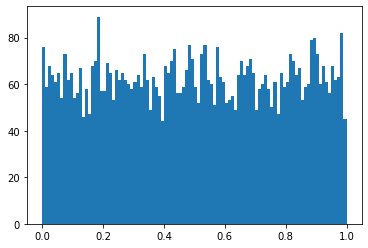

In [42]:
## this is equivalent to: D_Fe->Draw("h1_ph>>h(100,0,1)"), ok!
plt.hist(df['D_Fe']['h1_ph'],bins=100,range=(0,1.0))
df['D_Fe'].shape[0]  ## shape[0] return the number of rows of the array (number electrons)



In [44]:
#df['D_C'].query('h2_z>0.2').hist(figsize=(20,20),bins=100,column=['dphi_lab','dphi','h1_ph','h2_ph','h1_cm_ph','h2_cm_ph'])
#plt.savefig('plot_test.png', bbox_inches='tight')
#plt.show()


In [ ]:
df['D_Pb_mix'].query('h2_z>0.2').hist(figsize=(20,20),bins=100,column=['h1_cm_pt','dphi_lab','dphi','h1_ph','h2_ph','h1_cm_ph','h2_cm_ph','h2_pid'])
plt.savefig('plot_test2.png', bbox_inches='tight')
plt.show()


In [5]:
import root_pandas
from root_pandas import read_root
from root_pandas import to_root


In [43]:
for target in ['Fe']:
    to_root(df['%s'%target],'Pairs_%s.root'%target, key='%s'%target)
    to_root(df['%s_mix'%target],'Pairs_%s.root'%target, key='%s_mix'%target,mode='a')
    to_root(df['%s_trigger'%target],'Pairs_%s.root'%target, key='%s_trigger'%target, mode='a')
    to_root(df['D_%s'%target],'Pairs_%s.root'%target, key='D_%s'%target,mode='a')
    to_root(df['D_%s_mix'%target],'Pairs_%s.root'%target, key='D_%s_mix'%target,mode='a')
    to_root(df['D_%s_trigger'%target],'Pairs_%s.root'%target, key='D_%s_trigger'%target, mode='a')

# Simulations

In [16]:

path = '/home/seba/di-hadron/simul/Pb/'
#path = '/home/seba/di-hadron/simul/'
Files = listdir(path) 
df_mc['Pb'],df_mc['Pb_mix'], df_mc['Pb_trigger'] = [None,None,None]
count =0
for name in Files:
    print('done with: ', count, ' files')
    count=count+1
    if( '.root' not in name): continue
    
    filename = path+name
    print(filename)
    pairs, pairs_mix, trigger = getDataframes(filename,tree_name='ntuple_sim',Target=1,isMC=True)
    df_mc['Pb'] = pd.concat([ df_mc['Pb'], pairs])
    df_mc['Pb_mix'] = pd.concat([ df_mc['Pb_mix'], pairs_mix])
    df_mc['Pb_trigger'] = pd.concat([ df_mc['Pb_trigger'], trigger])

    print('Entries in the dataframe so far are ', df_mc['Pb'].shape[0])
    print('Entries in the MIXED dataframe so far are ', df_mc['Pb_mix'].shape[0])
    print('Entries in the trigger dataframe so far are ', df_mc['Pb_trigger'].shape[0])


done with:  0  files
/home/seba/di-hadron/simul/Pb/Pb4.root
/home/seba/di-hadron/simul/Pb/Pb4.root  has  9320000  entries
About to loop over  9320000  entries
Processed in 463.43520879745483 seconds
Number of triggers with z>0.4,   219816
Number of pairs with z>0.4,  624724
Entries in the dataframe so far are  219816
Entries in the MIXED dataframe so far are  391826
Entries in the trigger dataframe so far are  624724
done with:  1  files
/home/seba/di-hadron/simul/Pb/Pb9.root
/home/seba/di-hadron/simul/Pb/Pb9.root  has  9940000  entries
About to loop over  9940000  entries
Processed in 494.6588923931122 seconds
Number of triggers with z>0.4,   235133
Number of pairs with z>0.4,  667420
Entries in the dataframe so far are  454949
Entries in the MIXED dataframe so far are  809781
Entries in the trigger dataframe so far are  1292144
done with:  2  files
/home/seba/di-hadron/simul/Pb/Pb2.root
/home/seba/di-hadron/simul/Pb/Pb2.root  has  9940000  entries
About to loop over  9940000  entries

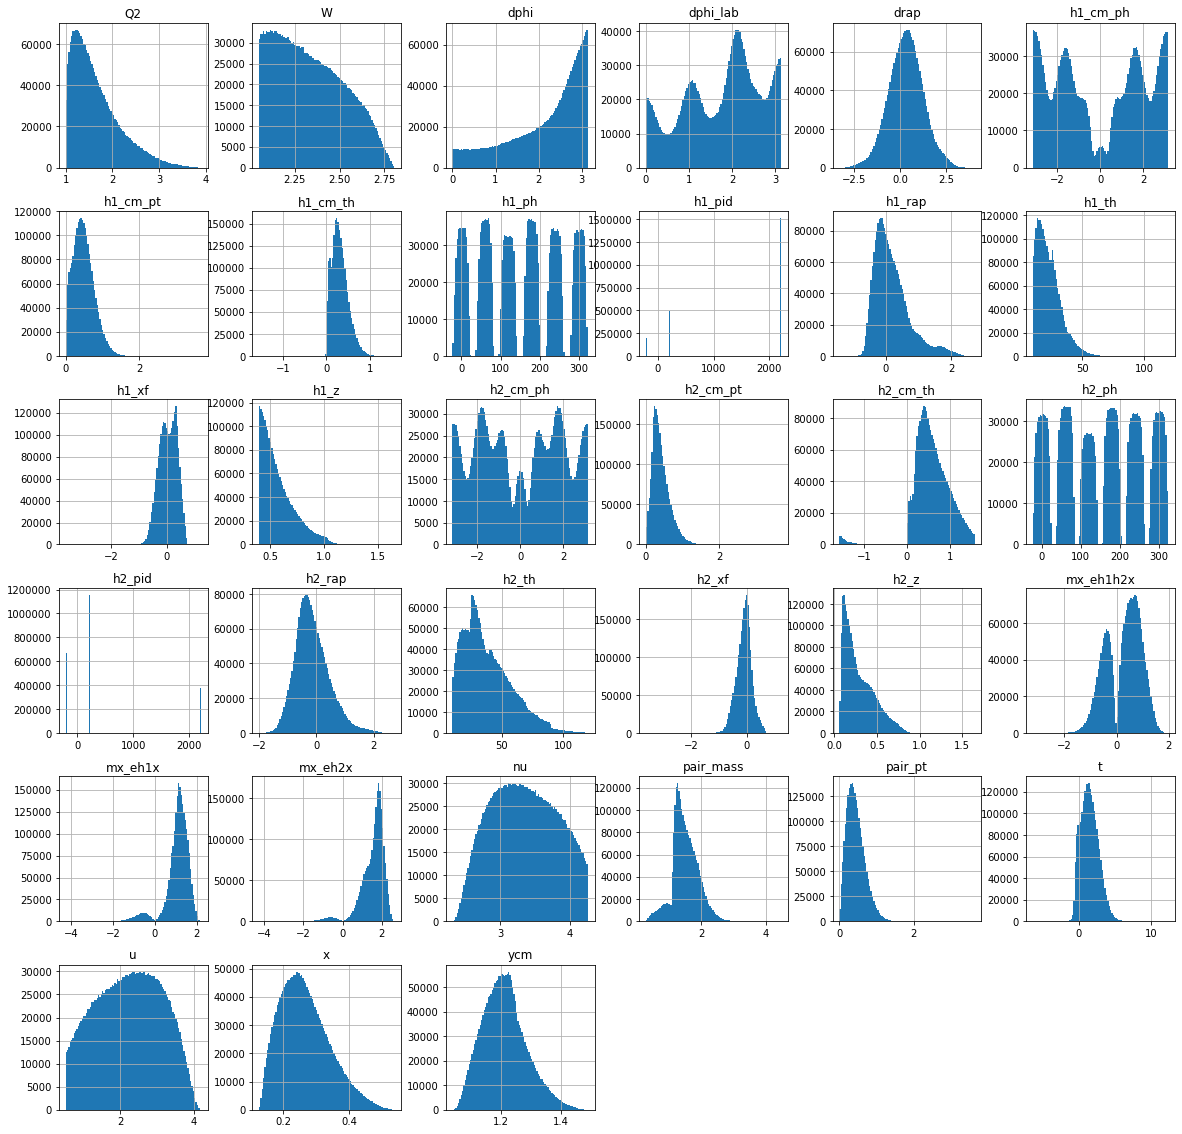

In [12]:
df_mc['D'].hist(figsize=(20,20),bins=100)
plt.show()

# Saving the MC file

In [17]:
for target in ['Pb']:
    to_root(df_mc['%s'%target],'MC_Pairs_%s.root'%target, key='%s'%target)
    to_root(df_mc['%s_mix'%target],'MC_Pairs_%s.root'%target, key='%s_mix'%target,mode='a')
    to_root(df_mc['%s_trigger'%target],'MC_Pairs_%s.root'%target, key='%s_trigger'%target, mode='a')

In [ ]:
for kk in range(5):
    print('inside the loop',kk)
print('outside the loop',kk)    

In [ ]:
    for ievt  in range(mytree.GetEntries()):
        mytree.GetEntry(ievt)   
        particles = []  ## this is how you define a list in python, this is created for each event
        for i in range(len(mytree.pid)):
            i_part = particle(mytree.pid[i], i_lv, virtual_photon, mytree.ThetaPQ[i], mytree.Nphe[i], mytree.deltaZ[i], mytree.FidCheckCutPiPlus[i])     
            particles.append(i_part)
            if i_part.Zh > 0.4: #only save triggers and do correlations if they have z>0.4
                #tupla_trigger['h1_th'].append(mytree.ThetaLab[i])#i_part.LorentzVector.Theta())
                #for j in range(len(mytree.pid)): 
                #    if i==j: continue
                #    tupla['dphi'].append(dphi)
                #print(ievt,i,j)
                for mixparticle in ParticlesFromPrevious:
                    print('inside mixparticle loop')
                    #print(i,mixparticle, ParticlesFromPrevious)
                    dphi = abs(ROOT.TVector2.Phi_mpi_pi(i_part.PhiPQ-mixparticle.PhiPQ))
                    tupla_mix['dphi_norot'].append(dphi)

                    mixparticle.redefine(virtual_photon) #recalculates variables in this' event photon frame (not in the previous one)
                    tupla_mix['h2_th'].append(mytree.ThetaLab[j])
        #print (' Exiting main loop over particles (i loop, not over all entries)')
        ParticlesFromPrevious = particles
        #print ' going for next event'    
        #print ' particles in event', len(particles
        ##end loop over events correlations    
    end = time.time()
    return df, df_mix, df_trigger        
        
        
        